In [1]:
%load_ext autoreload
%autoreload 2

In [2]:


# Imports for most of the notebook
import pandas
import torch
import numpy as np
import spacy
from typing import Dict, List, Optional, Tuple
from util import load_training_data

In [3]:
train_arg_path = "../data/arguments-training.tsv"
train_label_path = "../data/labels-training.tsv"
validation_arg_path = "../data/arguments-validation.tsv"
validation_label_path = "../data/labels-validation.tsv"

In [4]:
df_train_arguments, df_train_labels = load_training_data(train_arg_path, train_label_path)

df_train_labels = df_train_labels[["Argument ID", "Self-direction: action"]]
df_train_arguments = df_train_arguments.merge(df_train_labels, on='Argument ID')
df_train_arguments.head()

Argument ID                      Conclusion       Stance  \
0      A01001  Entrapment should be legalized  in favor of   
1      A01002     We should ban human cloning  in favor of   
2      A01003      We should abandon marriage      against   
3      A01004       We should ban naturopathy      against   
4      A01005         We should ban fast food  in favor of   

                                             Premise  Self-direction: action  
0  if entrapment can serve to more easily capture...                       0  
1  we should ban human cloning as it will only ca...                       0  
2  marriage is the ultimate commitment to someone...                       1  
3        it provides a useful income for some people                       0  
4  fast food should be banned because it is reall...                       0

In [5]:
df_vali_arguments, df_vali_labels = load_training_data(validation_arg_path, validation_label_path)

df_vali_labels = df_vali_labels[["Argument ID", "Self-direction: action"]]
df_vali_arguments = df_vali_arguments.merge(df_vali_labels, on='Argument ID')
df_vali_arguments.head()

Argument ID                                       Conclusion       Stance  \
0      A01001                   Entrapment should be legalized  in favor of   
1      A01012  The use of public defenders should be mandatory  in favor of   
2      A02001                    Payday loans should be banned  in favor of   
3      A02002                       Surrogacy should be banned      against   
4      A02009                   Entrapment should be legalized      against   

                                             Premise  Self-direction: action  
0  if entrapment can serve to more easily capture...                       0  
1  the use of public defenders should be mandator...                       0  
2  payday loans create a more impoverished societ...                       0  
3  Surrogacy should not be banned as it is the wo...                       1  
4                  entrapment is gravely immoral and                       0

In [6]:
def generate_input(dataset: pandas.core.frame.DataFrame) -> List[str]:
    
    premise, stance, conclusion, label = ([] for i in range(4))
    premise = ("LSEPL " + dataset["Premise"] + " LSEPL " + dataset["Stance"] + " LSEPL " + dataset["Conclusion"]).tolist()
    label = dataset["Self-direction: action"].tolist()
        
    return premise, label

In [8]:
class Tokenizer:
    """Tokenizes and pads a batch of input sentences."""

    def __init__(self, pad_symbol: Optional[str] = "<PAD>"):
        """Initializes the tokenizer

        Args:
            pad_symbol (Optional[str], optional): The symbol for a pad. Defaults to "<PAD>".
        """
        self.pad_symbol = pad_symbol
        self.nlp = spacy.load("en_core_web_sm")
    
    def __call__(self, batch: List[str]) -> List[List[str]]:
        """Tokenizes each sentence in the batch, and pads them if necessary so
        that we have equal length sentences in the batch.

        Args:
            batch (List[str]): A List of sentence strings

        Returns:
            List[List[str]]: A List of equal-length token Lists.
        """
        batch = self.tokenize(batch)
        batch = self.pad(batch)

        return batch

    def tokenize(self, sentences: List[str]) -> List[List[str]]:
        """Tokenizes the List of string sentences into a Lists of tokens using spacy tokenizer.

        Args:
            sentences (List[str]): The input sentence.

        Returns:
            List[str]: The tokenized version of the sentence.
        """
        tokens = []
        for sentence in sentences:
            doc = self.nlp(sentence)
            temp = ["<SOS>"]
            for t in doc:
                if t.text == "LSEPL":
                    temp.append("<SEP>")
                else:
                    temp.append(t.text)
            temp.append("<EOS>")
            tokens.append(temp)
        print(tokens)
        return tokens

    def pad(self, batch: List[List[str]]) -> List[List[str]]:
        """Appends pad symbols to each tokenized sentence in the batch such that
        every List of tokens is the same length. This means that the max length sentence
        will not be padded.

        Args:
            batch (List[List[str]]): Batch of tokenized sentences.

        Returns:
            List[List[str]]: Batch of padded tokenized sentences. 
        """
        padded_batch = []
        
        maxlen = len(max(batch, key=len))

        for token_list in batch:
            padded_batch.append(token_list + [self.pad_symbol]*(maxlen-len(token_list)))

        return padded_batch

In [11]:
# create the vocabulary of the dataset: use both training and test sets here

SPECIAL_TOKENS = ['<UNK>', '<PAD>', '<SOS>', '<EOS>', '<SEP>']

train, _ = generate_input(df_train_arguments)
vali, _ = generate_input(df_vali_arguments)
all_data =  train + vali
tokenizer = Tokenizer()

tokenized_data = tokenizer.tokenize(all_data)
vocab = sorted(set([w for ws in tokenized_data + [SPECIAL_TOKENS] for w in ws]))

with open('../embeddings/vocab.txt', 'w', encoding="utf-8") as vf:
    vf.write('\n'.join(vocab))

[['<SOS>', '<SEP>', 'if', 'entrapment', 'can', 'serve', 'to', 'more', 'easily', 'capture', 'wanted', 'criminals', ',', 'then', 'why', 'should', "n't", 'it', 'be', 'legal', '?', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'human', 'cloning', 'as', 'it', 'will', 'only', 'cause', 'huge', 'issues', 'when', 'you', 'have', 'a', 'bunch', 'of', 'the', 'same', 'humans', 'running', 'around', 'all', 'acting', 'the', 'same', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'the', 'ultimate', 'commitment', 'to', 'someone', ',', 'if', 'people', 'want', 'it', 'they', 'should', 'be', 'allowrd', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'provides', 'a', 'useful', 'income', 'for', 'some', 'people', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'

In [12]:
# Not going to put embeddings into the github, added to .gitignore
vocab_path = "../embeddings/vocab.txt"
embeddings_path = "../embeddings/glove.6B.300d.txt"
def read_pretrained_embeddings() -> Tuple[Dict[str, int], torch.FloatTensor]:
    """Read the embeddings matrix and make a dict hashing each word.

    Note that we have provided the entire vocab for train and test, so that for practical purposes
    we can simply load those words in the vocab, rather than all 27B embeddings

    Args:
        embeddings_path (str): _description_
        vocab_path (str): _description_

    Returns:
        Tuple[Dict[str, int], torch.FloatTensor]: _description_
    """
    word2i = {}
    vectors = []
    
    with open(vocab_path, "r", encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()]) 
    
    print(f"Reading embeddings from {embeddings_path}...")
    with open(embeddings_path, "r", encoding='utf8') as f:
        i = 0
        for line in f:
            word, *weights = line.rstrip().split(" ")
            if word in vocab:
                word2i[word] = i
                vectors.append(torch.tensor([float(w) for w in weights], dtype=torch.float))
                i += 1
    return word2i, torch.stack(vectors)

def get_oovs(word2i: Dict[str, int]) -> List[str]:
    """Find the vocab items that do not exist in the glove embeddings (in word2i).
    Return the List of such (unique) words.

    Args:
        vocab_path: List of batches of sentences.
        word2i (Dict[str, int]): _description_

    Returns:
        List[str]: _description_
    """
    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()])
    
    glove_and_vocab = set(word2i.keys())
    vocab_and_not_glove = vocab - glove_and_vocab
    return list(vocab_and_not_glove)

def intialize_new_embedding_weights(num_embeddings: int, dim: int) -> torch.FloatTensor:
    """xavier initialization for the embeddings of words in train, but not in gLove.

    Args:
        num_embeddings (int): _description_
        dim (int): _description_

    Returns:
        torch.FloatTensor: _description_
    """
    # Initialize a num_embeddings x dim matrix with xiavier initiialization
    #      That is, a normal distribution with mean 0 and standard deviation of dim^-0.5
    return torch.nn.init.xavier_normal_(torch.zeros([num_embeddings, dim], dtype=torch.float))

def update_embeddings(
    glove_word2i: Dict[str, int],
    glove_embeddings: torch.FloatTensor,
    oovs: List[str]
) -> Tuple[Dict[str, int], torch.FloatTensor]:
    # TODO: Add the oov words to the dict, assigning a new index to each

    # TODO: Concatenate a new row to embeddings for each oov
    #       initialize those new rows with `intialize_new_embedding_weights`

    # TODO: Return the tuple of the dictionary and the new embeddings matrix
    i: int = len(glove_word2i)
    for word in oovs:
        glove_word2i[word] = i
        i += 1
    
    return glove_word2i, torch.cat((glove_embeddings,intialize_new_embedding_weights(len(oovs),300)))

In [13]:
def chunk(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def chunk_multi(lst1, lst2, n):
    for i in range(0, len(lst1), n):
        yield lst1[i: i + n], lst2[i: i + n]

def make_batches(sequences: List[str], batch_size: int) -> List[List[str]]:
    """Yield batch_size chunks from sequences."""
    batches = []
    for i in range(0, len(sequences), batch_size):
        batches.append(sequences[i:i+batch_size])
    return batches

train_arguments, train_labels = generate_input(df_train_arguments)
dev_arguments, dev_labels = generate_input(df_vali_arguments)

# Set your preferred batch size
batch_size = 8
tokenizer = Tokenizer()

# We make batches now and use those.
batch_tokenized = []
# Note: Labels need to be batched in the same way to ensure
# We have train sentence and label batches lining up.
for batch in make_batches(train_arguments, batch_size):
    batch_tokenized.append(tokenizer(batch))


glove_word2i, glove_embeddings = read_pretrained_embeddings()

# Find the out-of-vocabularies
oovs = get_oovs(glove_word2i)

# Add the oovs from training data to the word2i encoding, and as new rows
# to the embeddings matrix
word2i, embeddings = update_embeddings(glove_word2i, glove_embeddings, oovs)

[['<SOS>', '<SEP>', 'if', 'entrapment', 'can', 'serve', 'to', 'more', 'easily', 'capture', 'wanted', 'criminals', ',', 'then', 'why', 'should', "n't", 'it', 'be', 'legal', '?', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'human', 'cloning', 'as', 'it', 'will', 'only', 'cause', 'huge', 'issues', 'when', 'you', 'have', 'a', 'bunch', 'of', 'the', 'same', 'humans', 'running', 'around', 'all', 'acting', 'the', 'same', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'the', 'ultimate', 'commitment', 'to', 'someone', ',', 'if', 'people', 'want', 'it', 'they', 'should', 'be', 'allowrd', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'provides', 'a', 'useful', 'income', 'for', 'some', 'people', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'

[['<SOS>', '<SEP>', 'school', 'prayer', 'can', 'not', 'account', 'for', 'the', 'array', 'of', 'beliefs', 'or', 'non', '-', 'beliefs', 'students', 'may', 'hold', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'as', 'everyone', 'has', 'a', 'right', 'to', 'keep', 'guns', 'as', 'a', 'mean', 'of', 'protection', 'as', 'stated', 'in', 'the', 'constitution', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'are', 'nothing', 'but', 'a', 'cult', 'and', 'manipulate', 'their', 'members', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'more', 'organs', 'than', 'people', 'donate', 'so', 'legalizing', 'it', 'would', 'be', 'a', 'good', 'thing', '<SE

[['<SOS>', '<SEP>', 'some', 'people', 'are', 'highly', 'intelligent', 'but', 'do', "n't", 'do', 'well', 'on', 'testing', 'so', 'intelligence', 'tests', 'ca', "n't", 'measure', 'a', 'true', 'value', 'if', 'it', "'s", 'only', 'testing', 'with', 'one', 'method', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'why', 'should', 'homosexuals', 'have', 'a', 'pride', 'parade?heterosexuals', 'do', "n't", 'have', 'them', '!', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'allowing', 'children', 'to', 'pray', 'and', 'take', 'some', 'quiet', 'time', 'in', 'school', 'can', 'be', 'beneficial', 'for', 'their', 'mental', 'health', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', 'as', 'the', 'current', 'two', 'party', 'sys

[['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'is', 'unnecessary', 'and', 'dangerous', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympic', 'games', 'cause', 'turmoil', 'and', 'a', 'lot', 'of', 'money', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', ' ', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'affirmative', 'action', 'in', 'favor', 'of', 'we', 'should', 'end', 'affirmative', 'action', 'because', 'it', 'just', 'caters', 'to', 'people', 'that', 'feel', 'like', 'they', 'were', 'discriminated', '<EOS>'], ['<SOS>', '<SEP>', 'what', 'one', 'chooses', 'to', 'believe', 'or', 'not', 'to', 'believe', 'should', 'be', 'at', 'their', 'discretion', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'Legalizing', 'marijuana', 'would', 'lead', 'to', 'a'

[['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'for', 'minors', 'should', 'be', 'banned', 'because', 'they', 'are', 'not', 'finished', 'growing', 'no', 'do', 'they', 'have', 'a', 'mature', 'enough', 'background', 'to', 'make', 'a', 'sound', 'decision', 'towards', 'this', 'procedure', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'two', '-', 'party', 'system', 'is', 'cheaper', 'and', 'easier', 'to', 'operate', 'that', 'any', 'multi', '-', 'party', 'system', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'human', 'cloning', 'should', 'be', 'banned', 'because', 'it', 'allows', 'designer', 'humans', 'to', 'be', 'grown', 'according', 'to', 'the', 'parents', 'wishes', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'a', 'religious', 'instituti

[['<SOS>', '<SEP>', 'a', 'surrogate', 'carrying', 'a', 'baby', 'could', 'try', 'to', 'keep', 'it', 'since', 'they', 'gave', 'birth', 'to', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'itself', 'is', 'not', 'the', 'cause', 'of', 'the', 'negative', 'consequences', ',', 'it', 'is', 'human', 'nature', '.', 'the', 'platform', 'merely', 'provides', 'unrivaled', 'access', 'to', 'information', 'and', 'potential', 'connections', 'with', 'other', 'people', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', 'since', 'it', 'puts', 'so', 'much', 'pressure', 'on', 'them', '.', 'they', 'should', 'be', 'growing', 'up', 'with', 'a', 'stable', 'life', 'and', 'just', 'enjoy', 'being', 'a', 'kid', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'ch

[['<SOS>', '<SEP>', 'entrapment', 'is', 'sometimes', 'a', 'necessary', 'tool', 'to', 'get', 'the', 'needed', 'proof', 'of', 'criminal', 'activity', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'exists', 'for', 'vanity', 'purposes', 'doctors', 'who', 'offer', 'the', 'service', 'should', 'focus', 'on', 'treating', 'people', 'with', 'real', 'illnesses', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'church', 'of', 'scientology', 'is', 'a', 'cult', 'that', 'is', 'harming', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'is', 'no', 'need', 'to', 'subsidize', 'a', 'site', 'that', 'is', "n't", 'necessary', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', '

[['<SOS>', '<SEP>', 'people', 'have', 'freedom', 'of', 'speech', ',', 'and', 'ignorance', 'does', 'not', 'equal', 'a', 'criminal', 'offense', '.', 'if', 'that', 'was', 'true', ',', 'too', 'many', 'people', 'would', 'be', 'criminals', 'based', 'on', 'the', 'amoint', 'of', 'ignorance', 'out', 'there', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'banning', 'telemarketing', 'has', 'no', 'approval', 'anywhere', 'as', 'customers', 'will', 'not', 'be', 'able', 'to', 'see', 'new', 'products', 'available', 'to', 'buy', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'people', 'choose', 'naturopathy', 'over', 'conventional', 'medicine', ',', 'that', 'is', 'their', 'right', '.', ' ', 'medical', 'care', 'can', 'not', 'be', 'forced', 'on', 'anyone', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'], ['<SOS>', '<SEP>', 'we',

[['<SOS>', '<SEP>', 'intelligence', 'test', 'can', 'cause', 'certain', 'students', 'to', 'be', 'pigeon', 'holed', 'and', 'cause', 'them', 'to', 'have', 'low', 'opinions', 'of', 'themselves', 'because', 'they', 'can', 'not', 'score', 'as', 'high', 'as', 'others', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'their', 'will', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', 'in', 'favor', 'of', 'the', 'church', 'of', 'scientology', 'encourages', 'the', 'isolation', 'of', 'it', "'s", 'members', '.', 'this', 'may', 'lead', 'to', 'some', 'members', 'essentially', 'being', 'help', '<EOS>'], ['<SOS>', '<SEP>', 'no', 'matter', 'how', 'much', 'suffering', 'we', 'have', 'in', 'life', 'nothing', 'justifies', 'death', 'in', 'the', 'same', 'way', 'i', 'think', 'that', 'a', 'sick', 'person', 'is', 'not', 'in', 'the', 'capacity', 'of', 'whether', 'he', 'wants', 't

[['<SOS>', '<SEP>', 'researchers', 'found', 'that', 'in', 'schools', 'across', 'the', 'world', 'with', 'uniform', 'policies', 'students', 'are', 'more', 'disciplined', 'and', 'concentrated', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'abolishing', 'the', 'three', 'strikes', 'law', 'would', 'save', 'money', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'has', 'some', 'harms', 'but', 'brings', 'more', 'good', '.', 'it', 'makes', 'people', 'happy', ',', 'otherwise', 'they', 'would', "n't", 'use', 'it', '.', 'also', ',', 'it', 'allows', 'people', 'to', 'connect', 'from', 'all', 'around', 'the', 'world', 'which', 'increases', 'social', 'awareness', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'iq', 'tests', 'are', 'great', 'f

[['<SOS>', '<SEP>', 'social', 'media', 'helps', 'in', 'fast', 'dessimination', 'of', 'vital', 'information', 'across', 'to', 'people', 'all', 'over', 'the', 'world', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'should', 'not', 'abolish', 'zoos', 'since', 'many', 'are', 'in', 'danger', 'of', 'extinction', ',', 'which', 'need', 'strategic', 'places', 'for', 'scientific', 'study', 'or', 'the', 'collection', 'of', 'funds', 'to', 'finance', 'projects', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'capital', 'punishment', 'is', 'seen', 'as', 'a', 'cruel', 'and', 'inhumane', 'way', 'of', 'treating', 'prisoners', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'zero', '-', 'tolerance', 'policies', 'keep', 'schools', 'safer', 'by', 'immediately', 'removing', 'the', 'problem', '<SE

[['<SOS>', '<SEP>', 'Zoos', 'are', 'too', 'small', 'and', 'do', 'not', 'provide', 'animals', 'with', 'the', 'space', 'and', 'habitat', 'that', 'they', 'are', 'born', 'to', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'are', 'exploiting', 'the', 'youth', 'purely', 'for', 'entertainment', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'is', 'an', 'ancient', 'law', 'that', 'is', 'a', 'cruel', 'requirement', ' ', 'defying', 'a', 'natural', 'part', 'of', 'a', 'human', "'s", 'life', 'and', 'often', 'deters', 'people', 'from', 'entering', 'certain', 'professions', 'and', 'this', 'should', 'be', 'abandoned', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abolish', 'safe', 'spaces', 'because', 'those', 'who', 'a

[['<SOS>', '<SEP>', 'a', 'multi', '-', 'party', 'system', 'allows', 'for', 'more', 'options', 'and', 'candidates', 'that', 'are', 'more', 'in', 'line', 'with', 'certain', 'populations', 'as', 'not', 'everyone', 'has', 'the', 'same', 'political', 'views', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'death', 'penalty', 'is', 'an', 'old', '-', 'fashioned', ',', 'outdated', ',', 'inhumane', 'practice', 'and', 'must', 'be', 'abolished', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abolish', 'zoos', 'because', 'it', 'dangerous', 'and', 'not', 'good', 'for', 'the', 'animals', 'to', 'be', 'out', 'of', 'their', 'natural', 'habitat', 'just', 'for', 'the', 'purpose', 'of', 'human', 'entertainment', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'social',

[['<SOS>', '<SEP>', 'factory', 'farming', 'reduces', 'the', 'cost', 'of', 'food', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'to', 'subsidize', 'space', 'exploration', 'in', 'order', 'to', 'find', 'an', 'inhabitable', 'planet', 'we', 'can', 'live', 'on', 'when', 'we', 'finally', 'destroy', 'the', 'one', 'we', 'live', 'on', 'now', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'holocaust', 'denial', 'spreads', 'harmful', 'misinformation', 'that', 'creates', 'an', 'unsafe', 'environment', 'for', 'minorities', ',', 'especially', 'jewish', 'people', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'affirmative', 'action', 'is', 'no', 'longer', 'needed', 'in', 'today', "'s", 'society', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'aff

[['<SOS>', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', 'because', 'they', 'put', 'public', 'funding', 'for', 'universities', 'at', 'risk', ',', 'due', 'to', 'backlash', 'from', 'right', 'wing', 'legislatures', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'making', 'a', 'child', 'work', 'as', 'an', 'actor', 'deprives', 'them', 'of', 'childhood', 'experiences', 'and', 'interactions', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'prostitution', 'was', 'legal', 'then', 'the', 'people', 'would', 'be', 'able', 'to', 'be', 'better', 'protected', 'and', 'diseases', 'could', 'be', 'controlled', 'more', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'private', 'military', 'companies', 'should', 'be', 'banned', 'as', 'they', 'are', 'not', 'subject', 't

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'adopt', 'gender', '-', 'neutral', 'language', 'because', 'no', 'reason', 'to', 'change', 'the', 'way', 'people', 'have', 'been', 'speaking', 'for', 'hundreds', 'of', 'years', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'necessary', 'in', 'our', 'society', 'as', 'a', 'way', 'to', 'control', 'and', 'protect', 'the', 'environment', 'in', 'which', 'the', 'animals', 'are', 'living', 'so', 'they', 'are', 'not', 'subjected', 'to', 'disease', 'and', 'predators', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'foster', 'care', 'gives', 'kids', 'who', 'would', 'otherwise', 'not', 'have', 'any', 'parental', 'figures', 'in', 'their', 'lives', 'have', 'a', 'chance', 'at', 'a', 'somewhat', 'normal', 'life', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', '

[['<SOS>', '<SEP>', 'libertarianism', 'allows', 'the', 'expression', 'of', 'free', 'will', 'and', 'would', 'make', 'society', 'more', 'interesting', 'by', 'allowing', 'people', 'to', 'be', 'as', 'they', 'truly', 'are', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'truth', 'remains', 'that', 'some', 'races', 'are', 'more', 'likely', 'to', 'commit', 'certain', 'crimes', ',', 'such', 'as', 'terrorism', ',', 'which', 'justifies', 'racial', 'profiling', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'bannabis', 'should', 'be', 'legalized', 'as', 'it', 'has', 'been', 'proven', 'to', 'have', 'medical', 'benefits', 'that', 'outweigh', 'any', 'negative', 'effects', '.', 'it', 'will', 'also', 'remove', 'it', 'from', 'the', 'control', 'of', 'criminals', 'and', 'gangsters', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>']

[['<SOS>', '<SEP>', 'it', 'costs', 'too', 'much', 'to', 'build', 'for', 'the', 'games', 'and', 'never', 'use', 'those', 'buildings', 'again', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'sale', 'of', 'cannabis', 'should', 'not', 'be', 'legalized', 'because', 'it', 'is', 'a', 'dangerous', 'drug', 'and', 'as', 'such', 'is', 'a', 'public', 'health', 'concern', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'is', 'an', 'unjust', 'form', 'of', 'capturing', 'criminals', 'as', 'it', 'is', 'tempting', 'someone', 'to', 'do', 'something', 'wrong', '<SEP>', 'against', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'libertarianism', 'promotes', 'political', 'freedom', 'of', 'choice', 'as', 'its', 'core', 'value', ',', 'and', 'is', 'the', 'ultimate', 'expression', 'of', 'democracy', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>'

[['<SOS>', '<SEP>', 'The', 'blockade', 'inspires', 'increased', 'terror', 'attacks', 'on', 'the', 'part', 'of', 'individuals', 'enraged', 'by', 'the', 'situation', 'in', 'Palestine', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'subsidize', 'wikipedia', 'because', 'wikipedia', 'helps', 'people', 'to', 'learn', 'about', 'any', 'and', 'everything', 'they', 'want', 'to', 'learn', 'about', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'all', 'schools', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'as', 'kids', 'need', 'to', 'know', 'they', 'can', 'not', 'act', 'inappropriately', 'at', 'any', 'given', 'moment', 'when', 'in', 'school', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'a', 'multi

[['<SOS>', '<SEP>', 'marriage', 'is', 'still', 'valid', 'for', 'those', 'who', 'belief', 'in', 'the', 'commitment', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'compulsory', 'voting', 'ensures', 'that', 'our', 'leaders', 'reflect', 'the', 'will', 'of', 'all', 'people', ',', 'not', 'just', 'those', 'who', 'were', 'able', '/', 'motivated', 'enough', 'to', 'make', 'it', 'to', 'the', 'polls', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'parents', 'agree', 'for', 'their', 'kids', 'to', 'do', 'acting', ',', 'i', 'can`t', 'see', 'any', 'problem', 'with', 'it', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'do', "n't", 'subsidize', 'stay', '-', 'at', '-', 'home', 'moms', ',', 'so', 'subsidizing', 'stay', '-', 'at', '-', 'home', 'dads', 'would', 'be', 'incredibly', 'sexist

[['<SOS>', '<SEP>', 'foster', 'care', 'provides', 'temporary', 'shelter', 'for', 'children', 'who', 'would', 'otherwise', 'be', 'on', 'the', 'streets', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Public', 'defenders', 'cost', 'the', 'state', 'too', 'much', 'money', '.', '<SEP>', 'against', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'Citizens', 'should', 'be', 'allowed', 'to', 'defend', 'themselves', 'with', 'lethal', 'force', 'in', 'a', 'life', '-', 'or', '-', 'death', 'situation', 'because', 'the', 'police', 'are', 'typically', 'slow', 'to', 'respond', 'to', 'such', 'situations', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>'], ['<SOS>', '<SEP>', 'merit', 'alone', 'should', 'be', 'the', 'deciding', 'factor', 'in', 'whether', 'a', 'person', 'is', 'given', 'a', 'career

[['<SOS>', '<SEP>', 'Creating', 'such', 'a', 'secluded', 'environment', 'for', 'this', 'detention', 'camp', 'has', 'encouraged', 'and', 'legitimized', 'unlawful', 'and', 'immoral', 'behaviour', 'on', 'the', 'part', 'of', 'the', 'soldiers', 'in', 'charge', 'of', 'the', 'detainees', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'space', 'exploration', 'has', 'the', 'ability', 'to', 'solve', 'the', 'problem', 'of', 'limited', 'materials', 'on', 'earth', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'government', 'must', 'use', 'least', 'restrictive', 'means', 'to', 'avoid', 'encroaching', 'on', 'people', "'s", 'freedoms', '.', 'As', 'such', 'they', 'should', 'educate', 'and', 'regulate', 'cosmetic', 'surgery', 'for', 'minors', 'instead', 'of', 'banning', 'it', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban',

[['<SOS>', '<SEP>', 'safe', 'spaces', 'are', 'a', 'place', 'where', 'minorities', 'of', 'any', 'sort', 'are', 'safe', 'to', 'be', 'who', 'they', 'are', 'and', 'are', 'safe', 'from', 'discrimination', ',', 'negative', 'comments', 'and', 'harassment', 'and', 'in', 'today', "'s", 'intolerant', 'society', 'are', 'much', 'needed', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'racial', 'profiling', 'can', 'be', 'beneficial', 'in', 'medical', 'research', 'as', 'it', 'has', 'been', 'identified', 'that', 'some', 'drugs', 'work', 'better', 'on', 'white', 'patients', 'and', 'some', 'on', 'blacks', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'ban', 'naturopathy', 'because', 'although', 'it', 'is', 'of', 'no', 'medical', 'benefit', 'pepople', 'are', 'entitled', 'to', 'make', 'wrong', 'choices', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'nat

[['<SOS>', '<SEP>', 'The', 'foster', 'system', 'provides', 'incentives', 'for', 'parents', 'to', 'adopt', 'when', 'children', 'are', 'orphaned', ',', 'such', 'as', 'free', 'college', 'tuition', ',', 'financial', 'assistance', ',', 'and', 'other', 'tax', 'benefits', ',', 'which', 'allows', 'more', 'children', 'to', 'be', 'adopted', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Private', 'military', 'companies', 'have', 'their', 'bottom', 'line', 'as', 'a', 'priority', 'rather', 'than', 'the', 'safety', 'of', 'the', 'country', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'private', 'military', 'companies', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'because', 'people', 'would', 'be', 'left', 'defenseless', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EO

[['<SOS>', '<SEP>', 'human', 'cloning', 'is', 'unnatural', 'and', 'should', 'be', 'banned', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'over', '-', 'policed', 'communities', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', 'in', 'favor', 'of', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', 'because', 'they', 'discriminate', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', "n't", 'prohibit', 'school', 'prayer', 'because', 'is', 'important', 'for', 'religious', 'education', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'a', 'form', 'of', 'harassment', 'to', 'be', 'contacted', 'constantly', 'by', 'telemarketers', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'could', 'help', 'people', 'make', 'bet

[['<SOS>', '<SEP>', 'the', 'holy', 'scriptures', 'say', 'many', 'things', 'that', 'are', 'not', 'accepted', 'by', 'the', 'traditions', 'of', 'the', 'church', ',', 'so', 'that', 'the', 'man', 'who', 'wants', 'to', 'remain', 'holy', 'must', 'be', 'celibate', '.', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'destroys', 'natural', 'habits', ',', 'impacting', 'negatively', 'the', 'environment', 'and', 'endangering', 'many', 'native', 'species', 'of', 'animals', ',', 'plants', 'and', 'insect', 'life', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'naturopathy', 'is', 'the', 'only', 'answer', 'for', 'some', 'people', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'adopt', 'an', 'austerity', 'regime', 'so', 'that', 'future', 'generations', 'are', 'not', 'left', 't0', '

[['<SOS>', '<SEP>', 'the', 'church', 'of', 'scientology', 'is', 'a', 'cult', 'and', 'it', 'should', 'be', 'banned', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'safe', 'spaces', 'create', 'an', 'unrealistic', 'environment', 'that', 'does', "n't", 'exist', 'in', 'the', 'real', 'world', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'just', 'because', 'someone', 'has', 'reached', 'the', 'age', 'of', 'retirement', ',', 'they', 'are', 'still', 'able', 'to', 'provide', 'a', 'vaulable', 'service', 'with', 'expertise', 'and', 'a', 'vast', 'knowledge', 'of', 'experience', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'holocaust', 'denial', 'should', "n't", 'be', 'a', 'criminal', 'offense', 'because', 'it', 'goes', '<SEP>', 'against', '<SEP>', 'Holocaust', 'den

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'abolish', 'zoos', 'as', 'they', 'contribute', 'to', 'the', 'breeding', 'of', 'endangered', 'species', 'and', 'the', 'reintroduction', 'of', 'animals', 'to', 'the', 'wild', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'couples', 'who', 'can`t', 'have', 'their', 'own', 'kids', 'this', 'is', 'the', 'only', 'way', 'to', 'get', 'them', 'and', 'should', 'not', 'be', 'banned', 'by', 'all', 'means', '.', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'promotes', 'peace', 'and', 'sportsmanship', 'amongst', 'countries', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'holocaust', 'was', 'a', 'serious', 'event', 'that', 'affected', 'many', ',', 'and', 'denying', 'that', 'it', 'happened', 'is', 'an', 'insult', 'to', 'those', 'who', 'died', 'during', 'it', ',', 'those', 'who', 'live

[['<SOS>', '<SEP>', 'mandatory', 'retirement', 'is', 'harsh', '.', ' ', 'it', 'pushes', 'workers', 'who', 'might', 'still', 'be', 'viable', 'out', 'of', 'the', 'workforce', 'for', 'no', 'other', 'reason', 'than', 'their', 'age', ',', 'often', 'leaving', 'them', 'to', 'struggle', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', ',', 'if', 'it', "'s", 'subsidised', 'it', 'could', 'mean', 'better', 'journalism', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'surrogacy', 'allows', 'women', 'to', 'be', 'a', 'mother', 'and', 'love', 'a', 'child', 'she', 'normally', 'could', "n't", '.', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'elections', 'are', 'supposed', 'to', 'be', 'won', 'by', 'the', 'opinion', 'of', 'the', 'people', '.', ' ', 'if', 'only', 'a', 'select', 'few', 'people', 'vote',

[['<SOS>', '<SEP>', 'assisted', 'suicide', 'is', 'unethical', 'how', 'do', 'we', 'know', 'that', 'the', 'person', 'who', 'is', 'assisting', 'the', 'suicide', 'has', 'nt', 'got', 'something', 'to', 'gain', 'from', 'the', 'death', 'of', 'the', 'other', 'person', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'be', 'able', 'to', 'keep', 'weapons', 'as', 'a', 'form', 'self', 'defence', 'to', 'defend', 'their', 'property', 'and', 'themselves', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>'], ['<SOS>', '<SEP>', 'absolutely', 'not', '.', ' ', 'the', 'great', 'president', 'donald', 'trump', 'is', 'turning', 'the', 'country', 'around', 'and', 'saving', 'us', 'from', 'the', 'financial', 'disaster', 'that', 'the', 'last', 'eight', 'years', 'were', 'leading', 'the', 'united', 'states', 'towards', '.', '<SEP>', 'against', '

[['<SOS>', '<SEP>', 'this', 'country', 'was', 'founded', 'by', 'the', 'freedom', 'of', 'religion', ',', 'so', 'people', 'should', 'have', 'the', 'right', 'to', 'follow', 'any', 'church', 'they', 'want', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'have', 'already', 'caused', 'multiple', 'fatalities', 'and', 'are', 'being', 'used', 'on', 'public', 'roads', 'right', 'now', 'without', 'being', 'adequately', 'tested', '.', 'the', 'makers', 'are', 'literally', 'using', 'human', 'lives', 'to', 'beta', 'test', 'their', 'products', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'Legalizing', 'the', 'organ', 'trade', 'would', 'allow', 'more', 'patients', 'to', 'receive', 'the', 'organ', 'transplant', 'they', 'need', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 

[['<SOS>', '<SEP>', 'if', 'undertaken', 'by', 'unscrupulous', 'officers', ',', 'racial', 'profiling', 'can', 'lead', 'to', 'racism', 'and', 'discrimination', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', 'is', 'a', 'private', 'entity', 'and', 'is', 'responsible', 'for', 'its', 'own', 'operating', 'costs', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'journalists', 'get', 'paid', 'enough', ',', 'they', 'do', "n't", 'need', 'any', 'more', 'money', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'usage', 'of', 'child', 'actors', 'should', 'not', 'be', 'banned', 'as', 'they', 'are', 'an', 'important', 'part', 'of', 'the', 'acting', 'field', 'they', 'have', 'adults', 'who', 'can', 'make', 'rationale', 'decisions', 'for', 'them', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'th

[['<SOS>', '<SEP>', 'if', 'used', 'to', 'catch', 'people', 'where', 'insufficient', 'evidence', 'exists', 'it', 'should', 'be', 'allowed', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'everyone', 'should', 'have', 'a', 'choice', 'about', 'what', 'they', 'want', 'to', 'do', 'with', 'their', 'bodies', ',', 'and', 'if', 'selling', 'an', 'organ', 'is', 'one', 'of', 'them', ',', 'they', 'should', 'be', 'free', 'to', 'decide', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'must', 'have', 'more', 'options', 'to', 'choose', 'and', 'leave', 'this', 'bipartisan', 'dictatorship', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'States', 'have', 'an', 'obligation', 'to', 'their', 'citizens', 'to', 'protect', 'them', ',', 'the', 'existence', 'of', 'nuclear', 'weapons', 'anyw

[['<SOS>', '<SEP>', 'the', 'use', 'of', 'economic', 'sanctions', 'are', 'the', 'best', 'recourse', 'we', 'have', 'to', 'safeguard', 'ourselves', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'], ['<SOS>', '<SEP>', 'multi', '-', 'party', 'systems', 'help', 'decentralize', 'power', 'and', 'better', 'represent', 'the', 'various', 'interests', 'of', 'different', 'socio', '-', 'economic', 'strata', 'within', 'a', 'nation', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'is', 'violative', 'and', 'intrusive', '.', 'unwanted', 'calls', 'from', 'telemarketers', 'are', 'too', 'much', 'annoying', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'in', 'the', 'constitution', 'that', 'there', 'is', 'a', 'separation', 'between', 'church', 'and', 'state', 'and', 'since', 

[['<SOS>', '<SEP>', 'you', 'can', 'only', 'give', 'someone', 'so', 'many', 'chances', '.', 'if', 'they', 'have', 'not', 'learnt', 'by', 'the', 'third', 'time', 'it', 'is', 'unlikely', 'they', 'will', 'learn', 'at', 'all', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'i', 'agree', 'that', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', 'is', 'a', 'good', 'idea', 'since', 'it', 'would', 'mean', 'that', 'our', 'children', 'are', 'safer', 'when', 'they', 'go', 'to', 'school', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'was', 'your', 'decision', 'or', 'poor', 'decision', 'making', 'that', 'got', 'someone', 'pregnant', 'and', 'you', 'should', 'deal', 'with', 'the', 'consequences', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EO

[['<SOS>', '<SEP>', 'prayer', 'has', 'no', 'place', 'in', 'public', 'school', 'because', 'not', 'everyone', 'practices', 'the', 'same', 'religion', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'live', 'in', 'a', 'democratic', 'society', 'and', 'people', 'should', 'not', 'be', 'forced', 'to', 'vote', 'if', 'they', 'do', 'nt', 'want', 'to', '<SEP>', 'against', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'entrapment', 'is', 'the', 'only', 'way', 'to', 'ensure', 'that', 'criminals', 'are', 'captured', 'and', 'charged', ',', 'therefore', 'we', 'should', 'legalise', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'cultures', 'like', 'inuits', 'rely', 'on', 'whales', 'for', 'many', 'things', 'like', 'food', 'and', 'heating', ',', 'and', 'they', 'use', 'practically', 'the', 'ent

[['<SOS>', '<SEP>', 'compulsory', 'voting', 'will', 'be', 'difficult', 'to', 'enforce', 'on', 'the', 'elderly', 'and', 'others', 'who', 'will', 'have', 'a', 'difficult', 'time', 'voting', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'are', 'our', 'future', 'and', 'provide', 'many', 'benefits', '<SEP>', 'against', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'uniforms', 'create', 'equality', 'and', 'create', 'a', 'sense', 'of', 'belonging', 'in', 'the', 'group', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'outdated', 'and', 'truly', 'offers', 'no', 'benefits', 'in', 'this', 'society', '.', ' ', 'it', 'should', 'be', 'abandoned', 'and', 'laws', 'be', 'put', 'in', 'effect', 'to', 'mimic', 'the', 'few', 'benefits', 'it', 'has', 'finan

[['<SOS>', '<SEP>', 'autonomous', 'cars', 'strip', 'drivers', 'of', 'the', 'ability', 'to', 'drive', 'as', 'they', 'please', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'kids', 'should', 'be', 'in', 'school', 'to', 'learn', '.', 'no', 'one', 'should', 'force', 'religion', 'on', 'them', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'can', 'cause', 'distress', 'for', 'people', 'who', 'do', 'not', 'know', 'how', 'to', 'get', 'rid', 'of', 'the', 'callers', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'A', 'blockade', 'is', 'what', 'you', 'do', 'when', 'you', 'want', 'any', 'chance', 'for', 'peace', 'eliminated', 'and', 'for', 'both', 'nations', 'to', 'grow', 'suspicious', 'towards', 'each', 'other', '<SEP>', 'in', 'favor', 'of', '<SEP>'

[['<SOS>', '<SEP>', 'stem', 'cell', 'research', 'is', 'the', 'beginning', 'of', 'wanting', 'to', 'do', 'more', 'and', 'more', 'things', 'we', 'should', "n't", 'be', 'messing', 'with', 'and', 'it', 'should', 'be', 'stopped', 'now', 'before', 'it', 'goes', 'any', 'further', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'Affirmative', 'action', 'is', 'counter', 'productive', '-', 'instead', 'of', 'helping', 'minorities', 'it', 'simply', 'puts', 'them', 'in', 'a', 'permanent', 'position', 'of', 'neediness', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'affirmative', 'action', '<EOS>'], ['<SOS>', '<SEP>', 'School', 'uniforms', 'reinforce', 'a', 'gender', 'binary', 'by', 'often', 'requiring', 'women', 'to', 'wear', 'traditionally', 'feminine', 'clothing', 'like', 'skirts', 'and', 'dresses', 'and', 'men', 'to', 'wear', 'traditionally', 'masculine', 'pants', '.', '<SEP>', 'in', 'favor', 'of', '<S

[['<SOS>', '<SEP>', 'capital', 'punishment', 'should', 'be', 'abolished', 'as', 'man', 'has', 'no', 'right', 'to', 'decide', 'to', 'take', 'another', 'life', 'no', 'matter', 'that', 'that', 'person', 'has', 'done', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'when', 'prostitution', 'moves', 'into', 'a', 'neighborhood', ',', 'so', 'do', 'drugs', 'and', 'violence', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'human', 'cloning', 'will', 'provide', 'necessary', 'organs', 'when', 'there', 'are', 'few', 'resources', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'intellectual', 'property', 'right', 'stop', 'innovation', 'and', 'progress', 'by', 'not', 'allowing', 'general', 'development', 'of', 'an', 'idea', 'by', 'others', 'who', 'may', 'deserve', 'that', 'opportunity', '<SEP>', 'in', 'favor', 'of', '

[['<SOS>', '<SEP>', 'intelligence', 'tests', 'will', 'cause', 'children', 'with', 'alternative', 'learning', 'styles', 'to', 'fall', 'through', 'the', 'cracks', 'in', 'the', 'educational', 'system', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'helps', 'many', 'people', 'with', 'their', 'self', 'esteem', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'taking', 'responsibility', 'for', 'yourself', 'rather', 'than', 'relying', 'on', 'the', 'doctor', 'for', 'small', 'issues', 'like', 'a', 'cold', ',', 'and', 'treating', 'it', 'naturally', ',', 'can', 'be', 'very', 'beneficial', 'for', 'everyone', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'], ['<SOS>', '<SEP>', 'embryonic', 'stem', 'cell', 'research', 'may', 'lead', 'to', 'life', '-', 'saving', 'treatments', 'such', 'as', 'the',

[['<SOS>', '<SEP>', 'assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', 'because', 'killing', 'is', 'wrong', 'whether', 'it', 'is', 'willingly', 'or', 'not', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'executive', 'compensation', 'encourages', 'them', 'to', 'work', 'for', 'their', 'pay', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'algorithmic', 'trading', 'gives', 'an', 'unfair', 'advantage', 'to', 'those', 'who', 'have', 'access', 'to', 'such', 'technology', 'and', 'results', 'in', 'losses', 'for', 'the', '&', 'quot;little', 'guy&quot', ';', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'three', '-', 'strikes', 'law', 'is', 'a', 'deterrent', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'l

[['<SOS>', '<SEP>', 'We', 'should', 'not', 'abolish', 'safe', 'spaces', 'because', 'people', 'who', 'have', 'PTSD', 'will', 'disengage', 'from', 'universities', 'and', 'other', 'spaces', 'if', 'they', 'can', 'not', 'participate', 'safely', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'no', 'one', 'should', 'be', 'punished', 'because', 'he', 'or', 'she', 'does', "n't", 'believe', 'something', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'is', 'what', 'drives', 'the', 'religious', 'people', 'to', 'commit', 'crimes', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'Israel', "'s", 'military', 'and', 'economic', 'superiority', 'makes', 'the', 'blockade', 'an', 'imperialistic', 'action', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'allow', 'an', 'austerity', 'regime', 'because', 'it', 'will', 'completely', 'destroy', 'the', 'country', 'by', 'causing', 'worse', 'economic', 'demise', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'whaling', 'is', 'a', 'traditional', 'occupation', 'of', 'some', 'cultures', 'and', 'their', 'cultural', 'heritage', 'would', 'be', 'lost', 'if', 'they', 'were', 'not', 'able', 'to', 'continue', 'whaling', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'human', 'cloning', 'allows', 'for', 'the', 'study', 'of', 'genetic', 'disorders', ',', 'opening', 'the', 'door', 'for', 'huge', 'leaps', 'in', 'medical', 'science', 'and', 'disease', 'cures', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'assisted', 'suicide', 'is', 'murder', 'by', 'another', 'name', 'and', 'should', 're

[['<SOS>', '<SEP>', 'executive', 'compensation', 'is', 'simply', 'part', 'of', 'a', 'modern', 'remuneration', 'package', ',', 'and', 'just', 'as', 'with', 'basic', 'salaries', ',', 'and', 'attractive', 'compensation', 'scheme', 'is', 'needed', 'to', 'attract', 'the', 'best', 'talent', 'to', 'an', 'organisation', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'cruel', 'to', 'the', 'animals', 'that', 'are', 'forced', 'into', 'a', 'much', 'smaller', 'space', 'than', 'they', 'would', 'have', 'in', 'nature', '.', 'therefore', 'it', 'should', 'be', 'banned', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'adopt', 'gender', '-', 'neutral', 'language', 'because', 'it', 'is', 'stupid', 'to', 'change', 'the', 'way', 'people', 'been', 'speaking', 'for', 'hundreds', 'of', 'years', '<SEP>', 'against', '<SEP>',

[['<SOS>', '<SEP>', 'The', 'possibility', 'of', 'extinction', 'as', 'a', 'result', 'of', 'nuclear', 'war', 'justifies', 'their', 'abolition', 'as', 'a', 'precaution', 'which', 'protects', 'all', 'of', 'humanity', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', "n't", 'abolish', 'zoos', 'because', 'they', 'attract', 'visitors', 'and', 'money', 'to', 'be', 'able', 'to', 'put', 'back', 'into', 'the', 'zoo', 'for', 'animal', 'feed', 'and', 'vet', 'bills', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'When', 'nuclear', 'weapons', 'exist', 'in', 'one', 'place', ',', 'they', 'are', 'always', 'at', 'risk', 'of', 'proliferating', 'to', 'the', 'most', 'dangerous', 'of', 'regimes', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>'

[['<SOS>', '<SEP>', 'it', 'causes', 'more', 'harm', 'than', 'good', 'when', 'the', 'surgery', 'in', 'minors', 'is', 'not', 'for', 'health', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', ',', 'so', 'that', 'corporations', 'accused', 'of', 'criminal', 'misconduct', 'have', 'the', 'same', 'resources', 'that', 'an', 'individual', 'would', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'has', 'many', 'helpful', 'medicinal', 'qualities', 'such', 'as', 'helping', 'cancer', 'patients', 'keep', 'food', 'down', 'when', 'going', 'through', 'chemotherapy', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'algorithmic', 'trading', 'should', 'be', 'banned', 'as', 'the', 'software', 'ca

[['<SOS>', '<SEP>', 'embryonic', 'stem', 'cell', 'research', 'is', 'controversial', 'and', 'therefore', 'should', 'not', 'receive', 'government', 'funding', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'traditional', 'right', 'to', 'choose', 'your', 'own', 'defender', 'to', 'represent', 'you', 'has', 'worked', 'well', 'for', 'centuries', 'and', 'should', 'never', 'be', 'changed', '.', '<SEP>', 'against', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'is', 'an', 'easy', 'way', 'for', 'people', 'to', 'connect', 'with', 'consumers', 'that', 'are', 'interested', 'in', 'their', 'products', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympics', 'are', 'an', 'expensive', 'operation', 'and', 'the', 'city', 'selection', 'process', 'is', 'corrupt', '.', '<S

[['<SOS>', '<SEP>', 'making', 'the', 'use', 'of', 'public', 'defenders', 'madatory', 'would', 'increase', 'the', 'number', 'of', 'miscarriages', 'of', 'justice', 'since', 'the', 'best', 'and', 'most', 'able', 'defence', 'lawyers', 'would', 'go', 'to', 'areas', 'of', 'the', 'law', 'where', 'they', 'can', 'make', 'the', 'most', 'money', '<SEP>', 'against', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'naturopathy', 'has', 'been', 'providing', 'relief', 'for', 'hundreds', 'of', 'years', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'], ['<SOS>', '<SEP>', 'several', 'people', 'have', 'been', 'found', 'not', 'guilty', 'after', 'they', 'had', 'already', 'been', 'put', 'to', 'death', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'the', 'only', 'way', 'to', 'catch', 'a', 'criminal', 'is', 'by', 'entrapment',

[['<SOS>', '<SEP>', 'keeping', 'terrorists', 'locked', 'up', 'saves', 'lives', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'compulsory', 'voting', 'takes', 'away', 'an', 'individual', "'s", 'right', 'to', 'their', 'own', 'mind', '<SEP>', 'against', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'providing', 'more', 'funding', 'from', 'goverment', 'to', 'speed', 'up', 'embryonic', 'stem', 'cell', 'research', 'can', 'only', 'be', 'for', 'the', 'benefit', 'of', 'the', 'public', "'s", 'health', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'provides', 'us', 'with', 'all', 'the', 'food', 'we', 'take', 'for', 'granted', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'flag', 'burning', 'is', 'basic

[['<SOS>', '<SEP>', 'people', 'are', 'allowed', 'to', 'believe', 'and', 'practice', 'what', 'they', 'want', ',', 'we', 'ca', "n't", 'pick', 'and', 'choose', ',', 'so', 'no', ',', 'we', 'ca', "n't", 'ban', 'it', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'fast', 'food', 'should', 'not', 'be', 'banned', 'as', 'it', 'is', 'comforting', ',', 'allows', 'for', 'social', 'events', 'and', 'interaction', 'and', 'is', 'enjoyed', 'by', 'many', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'fast', 'food', '<EOS>'], ['<SOS>', '<SEP>', 'austerity', 'regimes', 'hid', 'the', 'poor', 'and', 'dependent', 'sections', 'of', 'society', 'disproportionally', 'hard', ',', 'and', 'they', 'are', 'those', 'least', 'able', 'to', 'withstand', 'such', 'reductions', 'in', 'spending', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'everybody', "'s", '

[['<SOS>', '<SEP>', 'algorithmic', 'trading', 'removes', 'the', 'human', 'element', 'of', 'common', 'sense', 'from', 'trading', 'patterns', ',', 'which', 'has', 'caused', 'many', 'wild', 'mini', '-', 'crashes', 'and', 'market', 'fluctuations', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'legalizing', 'prostitution', 'would', 'erode', 'moral', 'values', 'and', 'reduce', 'the', 'safety', 'of', 'women', 'so', 'it', 'should', 'never', 'be', 'legal', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'Intelligence', 'tests', 'can', 'help', 'to', 'identify', 'struggling', 'or', 'gifted', 'students', 'so', 'that', 'educators', 'can', 'accommodate', 'to', 'each', 'individuals', 'needs', '.', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Entrapment', 'can', 'be', 'a', 'useful', 'tool',

[['<SOS>', '<SEP>', 'pride', 'parades', 'cause', 'violence', 'and', 'hate', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'costs', 'people', 'thousands', ',', 'only', 'for', 'them', 'to', 'divorce', 'again', 'later', 'in', 'most', 'cases', 'nowadays', '.', 'if', 'marriage', 'was', 'abandoned', 'people', 'would', 'save', 'a', 'fortune', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'journalism', 'must', 'be', 'supported', 'by', 'the', 'central', 'government', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'Nuclear', 'Weapons', 'are', 'a', 'good', 'defense', 'and', 'allows', 'a', 'nation', 'to', 'protect', 'themselves', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'The', ' ', 'Middle', 'Eas

[['<SOS>', '<SEP>', 'The', 'alternative', 'to', 'having', 'a', 'system', 'of', 'payday', 'loans', 'is', 'that', 'people', 'are', 'unable', 'to', 'pay', 'their', 'bills', 'or', 'get', 'needed', 'immediate', 'assistance', ',', 'costing', 'both', 'long', 'and', 'short', 'term', 'harms', '.', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'Corporations', 'should', 'decide', 'for', 'themselves', 'whether', 'to', 'keep', 'a', 'worker', 'because', 'they', 'are', 'the', 'ones', 'directly', 'impacted', ',', 'mandatory', 'retirement', 'encroached', 'on', 'corporate', 'rights', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'costs', 'too', 'much', 'money', 'to', 'explor', 'space', ',', 'it', 'could', 'be', 'used', 'elsewhere', 'to', 'benefit', 'humans', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>'

[['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'is', 'necessary', 'for', 'those', 'embracing', 'a', 'religious', 'career', ',', 'it', 'helps', 'them', 'focusing', 'on', 'spiritual', 'matters', 'rather', 'than', 'physical', 'needs', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'legalize', 'prostitution', 'because', 'they', 'spread', 'too', 'many', 'deceases', 'so', 'we', 'need', 'to', 'get', 'rid', 'of', 'prostitution', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'polygamy', 'hurts', 'no', 'one', 'as', 'long', 'as', 'it', "'s", 'not', "'", 'frauded', "'", 'and', 'done', 'solely', 'to', 'gain', 'insurance', 'and', 'other', 'such', 'benefits', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'polygamy', '<EOS>'], ['<SOS>', '<SEP>', 'foster', 'care', 'families', 'become', 'a', 'dynamic', 'support', 'system', '

[['<SOS>', '<SEP>', 'factory', 'farming', 'brings', 'meat', 'down', 'to', 'a', 'price', 'affordable', 'to', 'the', 'poorest', 'in', 'our', 'community', 'on', 'a', 'regular', 'basis', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'funding', 'comes', 'with', 'overt', 'or', 'covert', 'strings', 'attached', ',', 'certain', 'criticisms', 'of', 'the', 'government', 'would', 'vanish', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'space', 'exploration', 'should', 'be', 'privatized', 'and', 'maybe', 'we', "'d", 'get', 'somewhere', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', 'not', 'prohibit', 'school', 'prayer', 'as', 'it', 'allows', 'students', 'to', 'practice', 'their', 'faith', 'in', 'their', 'everyday', 'life', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '

[['<SOS>', '<SEP>', 'fast', 'food', 'is', 'the', 'main', 'culprit', 'for', 'our', 'current', 'obesity', 'epidemic', '.', ' ', 'we', 'need', 'to', 'get', 'rid', 'of', 'it', 'to', 'restore', 'our', 'health', 'in', 'the', 'future', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'fast', 'food', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', 'by', 'focusing', 'on', 'strengths', 'and', 'weaknesses', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'There', 'can', 'not', 'be', 'justification', 'for', 'taking', 'a', 'human', 'life', '.', 'The', 'only', 'way', 'to', 'properly', 'deliver', 'this', 'message', 'is', 'to', 'abolish', 'death', 'penalty', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'freedom', 'of', 'religion', 'is', 'one', 'of', 'the', 'most', 'basi

[['<SOS>', '<SEP>', 'Social', 'media', 'brings', 'people', 'together', 'who', 'are', 'separated', 'by', 'great', 'distances', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'nuclear', 'weapons', 'should', 'be', 'abolished', 'because', 'they', 'are', 'just', 'an', 'easy', 'way', 'to', 'wipe', 'out', 'the', 'human', 'race', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'church', 'is', 'like', 'any', 'other', 'church', ',', 'and', 'after', 'all', ',', 'there', 'is', 'supposed', 'to', 'be', 'a', 'separation', 'of', 'church', 'and', 'state', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'not', 'be', 'judged', 'by', 'their', 'race', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'racial', 'pro

[['<SOS>', '<SEP>', 'assisted', 'suicide', 'should', 'not', 'be', 'a', 'criminal', 'defense', 'because', 'in', 'some', 'cases', ',', 'like', 'people', 'who', 'have', 'terminal', 'cancer', ',', 'you', 'are', 'doing', 'them', 'a', 'mercy', 'and', 'saving', 'them', 'from', 'suffering', '.', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'zoos', 'are', 'an', 'educational', 'and', 'entertaining', 'tool', 'and', 'the', 'animals', 'are', 'well', 'fed', 'and', 'cared', 'for', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'because', 'times', 'are', 'changing', 'and', 'people', 'are', 'not', 'sure', 'of', 'their', 'gender', 'anymore', 'so', 'it', 'stops', 'people', 'being', 'offended', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'i', 'think', 'it', 'takes', 'up'

[['<SOS>', '<SEP>', 'holocaust', 'denial', ' ', 'is', 'offensive', 'to', 'jewish', 'people', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'due', 'to', 'the', 'history', 'of', 'abuses', 'at', 'this', 'base', 'it', 'should', 'be', 'closed', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'blockade', 'is', 'a', 'waste', 'of', 'political', 'and', 'economic', 'capital', 'which', 'could', 'be', 'used', 'for', 'valuable', 'reforms', 'inside', 'of', 'Israel', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'provides', 'ways', 'for', 'people', 'to', 'connect', 'where', 'they', 'might', 'not', 'be', 'able', 'to', 'otherwise', '.', 'reconnecting', 'with', 'old', 'friends', ',', 'new', 'colleagues', ','

[['<SOS>', '<SEP>', 'children', 'have', 'a', 'right', 'to', 'bodily', 'autonomy', 'just', 'like', 'adults', ',', 'and', 'banning', 'cosmetic', 'surgery', 'is', 'a', 'violation', 'of', 'this', 'freedom', 'of', 'expression', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'cannabis', 'can', 'help', 'alleviate', 'many', 'medical', 'issues', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'other', 'places', 'can', 'provide', 'information', 'for', 'free', 'so', 'why', 'should', 'wikipedia', 'get', 'money', 'for', 'doing', 'the', 'same', 'thing', '?', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'is', 'no', 'one', 'right', 'belief', 'for', 'all', 'people', 'and', 'insisting', 'that', 'everyone', 'is', 'a', 'libertarian', 'deprive', 'free', 'choice', '<SEP>', 'against', '<SEP>', 'We', 'sho

[['<SOS>', '<SEP>', 'flag', 'burning', 'is', 'disrespectable', 'to', 'our', 'country', ',', 'our', 'liberties', 'and', 'our', 'history', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'flag', 'burning', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'basis', 'of', 'family', 'in', 'this', 'country', 'is', 'two', 'people', 'as', 'a', 'couple', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'polygamy', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'three', '-', 'strikes', 'laws', 'can', 'keep', 'some', 'people', 'from', 'having', 'a', 'chance', 'to', 'get', 'out', 'and', 'reform', 'themselves', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'school', 'prayer', 'has', 'traditionally', 'brought', 'all', 'pupils', 'together', 'to', 'give', 'thanks', 'to', 'god', 'and', 'prohibiting', 'this', 'removes', 'a', 'tradition', 'many', 'find', 'a', 'comforting', 'start', 'to', 'their', 'da

[['<SOS>', '<SEP>', 'Sport', 'does', 'nothing', 'for', 'the', 'survival', 'of', 'the', 'human', 'race', 'and', 'yet', 'masses', 'of', 'resources', 'are', 'still', 'ploughed', 'into', 'it', 'for', 'events', 'like', 'the', 'Olympic', 'Games', 'while', 'issues', 'like', 'poverty', 'are', 'swept', 'under', 'the', 'carpet', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'subsidization', 'may', 'allow', 'those', 'providing', 'the', 'finances', 'to', 'have', 'influence', 'on', 'entries', 'that', 'are', 'in', 'their', 'interest', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', 'not', 'abolish', 'safe', 'spaces', 'because', 'people', 'with', 'PTSD', 'need', 'these', 'spaces', 'to', 'overcome', 'their', 'trauma', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'zoos', 'keep', 'wild', 'animal

[['<SOS>', '<SEP>', 'safe', 'spaces', 'restrict', 'freedom', 'of', 'expression', 'and', 'should', 'be', 'prohibited', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'this', 'form', 'of', 'trading', 'removes', 'the', 'human', 'element', 'which', 'can', 'have', 'dangerous', 'consequences', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'to', 'keep', 'it', 'as', 'a', 'source', 'of', 'information', 'and', 'because', 'it', 'does', 'not', 'receive', 'funding', 'it', 'ought', 'to', 'be', 'subsidized', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'is', 'a', 'useful', 'source', 'of', 'sales', 'for', 'many', 'businesses', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'minors', 'are', 'too', 'young', 'to', 'make', 'these', 'ch

[['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'causes', 'unnecessary', 'risks', 'to', 'the', 'patient', 'for', 'a', 'purely', 'narcissistic', 'procedure', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'human', 'cloning', 'because', 'cloning', 'takes', 'away', 'from', 'the', 'unique', 'individuality', 'of', 'a', 'person', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'naturopathy', 'because', 'it', 'is', 'not', 'proven', 'to', 'work', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'], ['<SOS>', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', 'so', 'that', 'it', 'is', 'possible', 'for', 'liberal', 'democratic', 'societies', 'to', 'crack', 'down', 'on', 'fascism', 'early', ',', 'rather', 'than', 'let', 'it', 'grow', 'like', 'a', 'weed', '.', '

[['<SOS>', '<SEP>', 'separation', 'of', 'church', 'and', 'state', 'applies', 'here', 'since', 'schools', 'are', 'sponsored', 'by', 'the', 'state', '.', 'mandatory', 'prayer', 'would', 'be', 'a', 'major', 'violation', 'of', 'this', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', 'because', 'it', 'creates', 'a', 'gender', 'neutral', 'role', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'having', 'a', 'belief', 'is', 'not', 'illegal', 'and', 'we', 'should', 'not', 'ban', 'or', 'discriminate', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'everyone', 'should', 'be', 'allowed', 'to', 'practice', 'their', 'own', 'faith', 'wherever', 'they', 'are', ',', 'many', 'people', 'rely', 'on', 'prayer

[['<SOS>', '<SEP>', 'intelligence', 'test', 'are', 'not', 'fully', 'accurate', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'it', '<SEP>', 'against', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'denying', 'the', 'holocaust', 'is', 'deeply', 'offensive', 'to', 'survivors', 'and', 'their', 'family', 'and', 'should', 'not', 'be', 'allowed', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', 'is', 'not', 'a', 'reliable', 'source', 'for', 'information', 'and', 'we', 'should', 'not', 'waste', 'money', 'on', 'it', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'zoos', 'help', 'protect', 'animals', 'that', 'are', 'in', 'danger', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS

[['<SOS>', '<SEP>', 'subsidizing', 'a', 'parent', 'at', 'home', 'would', 'allow', 'parents', 'the', 'ability', 'to', 'spend', 'more', 'time', 'with', 'their', 'children', 'while', 'they', 'are', 'young', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'is', 'too', 'often', 'a', 'waste', 'of', 'time', '.', ' ', 'in', 'an', 'age', 'where', 'most', 'people', 'have', 'ways', 'to', 'see', 'who', 'is', 'calling', ',', 'the', 'calls', 'rarely', ',', 'if', 'ever', ',', 'actually', 'get', 'through', '.', ' ', 'it', "'s", 'time', 'to', 'find', 'a', 'new', 'way', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'israel', 'is', 'threatened', 'by', 'terrorists', 'operating', 'in', 'the', 'gaza', 'strip', ',', 'the', 'blockade', 'is', 'necessary', 'to', 'starve', 'these', 'forces', 'of', 'funds', '.', '<SEP>', 'against', '<SEP>

[['<SOS>', '<SEP>', 'Yes', ',', 'because', 'it', 'is', 'murder', 'practically', 'and', 'this', 'is', 'considered', 'a', 'crime', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'cooperation', 'among', 'countries', 'is', 'essential', 'nowadays', '.', 'avoiding', 'armed', 'conflict', 'when', 'one', 'country', "'s", 'terrorizing', 'others', 'by', 'the', 'use', 'of', 'economic', 'sanctions', 'is', 'a', 'great', 'solution', 'to', 'return', 'that', 'country', 'back', 'more', 'cooperation', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'], ['<SOS>', '<SEP>', 'algorithmic', 'trading', 'is', 'legal', ',', 'and', 'all', 'traders', 'have', 'access', 'to', 'some', 'sort', 'of', 'computer', '-', 'aided', 'tools', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'you', 'can', 'require', 'voting',

[['<SOS>', '<SEP>', 'telemarketing', 'can', 'help', 'companies', 'reach', 'a', 'wider', 'audience', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'payday', 'loans', 'should', 'not', 'be', 'banned', 'because', 'sometimes', 'people', 'need', 'the', 'money', 'ahead', 'of', 'time', 'for', 'emergencies', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'human', 'cloning', 'is', 'far', 'from', 'being', 'perfected', 'and', 'can', 'lead', 'to', 'major', 'unethical', 'behavior', 'by', 'geneticists', 'that', 'can', 'result', 'in', 'grave', 'mistakes', 'and', 'horrific', 'experiments', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'you', 'kill', 'or', 'rape', 'someone', 'you', 'deserve', 'to', 'die', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>',

[['<SOS>', '<SEP>', 'we', 'should', 'adopt', 'gender', '-', 'neutral', 'language', 'so', 'nobody', 'will', 'get', 'offended', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'women', 'in', 'are', 'just', 'as', 'capable', 'as', 'men', 'combat', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'austerity', 'regimes', 'can', 'cause', 'widespread', 'unemployment', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'space', 'exploration', 'is', 'a', 'good', 'adventure', '.', 'our', 'planet', 'is', 'in', 'a', 'future', 'risk', 'of', 'extinct', 'and', 'we', 'should', 'best', 'prepare', 'our', 'refuge', 'in', 'space', 'exploration', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'surrogacy', 'should', 'not', 'be', 'ban

[['<SOS>', '<SEP>', 'consensus', 'can', 'become', 'difficult', 'in', 'multi', 'party', 'systems', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'libertarianism', 'is', 'better', 'than', 'anything', 'else', 'at', 'keeping', 'peace', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'Legalizing', 'prostitution', 'will', 'make', 'sex', 'workers', 'safer', 'because', 'they', 'will', 'no', 'longer', 'have', 'to', 'hide', ',', 'be', 'ruled', 'by', 'criminals', 'or', 'judged', 'as', 'ones', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'is', 'a', 'possibility', 'that', 'the', 'servers', 'could', 'be', 'hacked', 'and', 'alter', 'algorithmic', 'programming', ',', 'which', 'would', 'cause', 'widespread', 'panic', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorith

[['<SOS>', '<SEP>', 'in', 'a', 'society', 'full', 'of', 'freedoms', 'should', 'not', 'impose', 'a', 'unique', 'way', 'of', 'manifesting', 'religious', 'beliefs', ',', 'therefore', 'praying', 'should', 'be', 'something', 'that', 'is', 'done', 'at', 'home', ',', 'not', 'at', 'school', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympic', 'games', 'promotes', 'racism', 'and', 'social', 'exclusion', 'in', 'favour', 'of', 'a', 'good', "'", 'public', 'image', "'", 'for', 'the', 'host', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'be', 'free', 'to', 'choose', 'for', 'themselves', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'Naturopathic', 'medicine', 'is', 'an', 'exploitative', 'industry', 'that', 'frequently', 'makes', 'unfounded', 'claims', 'about', 'i

[['<SOS>', '<SEP>', 'safe', 'spaces', 'allow', 'for', 'those', 'who', 'are', 'triggered', 'to', 'go', 'somewhere', 'to', 'seek', 'a', 'space', 'free', 'of', 'triggers', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'easing', 'someone', "'s", 'suffering', 'should', 'not', 'be', 'a', 'criminal', 'offence', '.', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'could', 'increase', 'accidents', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'can', 'do', 'more', 'harm', 'than', 'good', '.', 'it', 'has', 'ruined', 'people', "'s", 'looks', 'for', 'life', 'and', 'thus', 'ruined', 'people', "'s", 'lives', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', 'not'

[['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'should', 'be', 'banned', 'for', 'minors', 'because', 'their', 'bodies', 'have', "n't", 'even', 'finished', 'developing', 'yet', 'so', 'anything', 'done', 'to', 'correct', 'issues', 'with', 'appearance', 'may', 'be', 'undone', 'by', 'nature', 'anyway', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'Cosmetic', 'surgery', 'promotes', 'a', 'superficial', 'society', 'that', 'cares', 'more', 'about', 'appearance', 'than', 'personality', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'pride', 'parades', 'are', 'offensive', 'to', 'a', 'lot', 'of', 'people', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', 'because', 'it', 'can', 'hurt', 'them', 'ment

[['<SOS>', '<SEP>', 'Intelligence', 'tests', 'allow', 'employers', 'and', 'schools', 'to', 'locate', 'areas', 'where', 'test', 'takers', 'need', 'to', 'improve', '.', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'should', "n't", 'be', 'abandoned', 'for', 'the', 'divinity', 'and', 'holy', 'spirit', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympic', 'games', 'should', 'not', 'be', 'abolished', 'as', 'they', 'bring', 'the', 'world', 'together', 'to', 'see', 'outstanding', 'sport', 'and', 'encouges', 'young', 'people', 'to', 'take', 'up', 'sport', 'andd', 'strive', 'for', 'success', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'organ', 'trade', 'should', 'not', 'be', 'legalized', 'as', 'it', 'would', 'invariably', 'lead', '

[['<SOS>', '<SEP>', 'guantanamo', 'bay', 'has', 'a', 'reputation', 'that', 'the', 'usa', 'needs', 'to', 'get', 'away', 'from', 'and', 'so', 'needs', 'to', 'close', 'it', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'good', 'than', 'harm', 'because', 'they', 'equalize', 'students', 'from', 'rich', 'and', 'poor', 'backgrounds', ',', 'since', 'money', 'can', 'not', 'buy', 'intelligence', '.', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Safe', 'spaces', 'create', 'an', 'echo', 'chamber', 'where', 'only', 'currently', 'accepted', 'ideas', 'are', 'allowed', 'to', 'be', 'spoken', 'and', 'any', 'dissent', 'is', 'blocked', 'out', ',', 'preventing', 'change', 'and', 'growth', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<S

[['<SOS>', '<SEP>', 'school', 'unifoorm', 'creates', 'a', 'sense', 'of', 'community', 'and', 'takes', 'away', 'some', 'aspects', 'that', 'can', 'lead', 'to', 'bullying', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'in', 'the', 'world', 'where', 'everybody', 'seeking', 'equality', ',', 'can`t', 'see', 'why', 'we', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'mothers', 'and', 'not', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '?', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'Holocaust', 'denial', 'propagates', 'negative', 'Jewish', 'stereotypes', 'and', 'encourages', 'Anti', '-', 'Semitism', '.', 'It', 'must', 'be', 'stopped', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'intellectual', 'prope

[['<SOS>', '<SEP>', 'we', 'should', 'cancel', 'pride', 'parades', 'because', 'they', 'entice', 'people', 'who', 'oppose', 'that', 'ideology', 'to', 'cause', 'riots', 'and', 'disrupt', 'the', 'general', 'peace', 'of', 'citizens', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'a', 'cost', 'effective', 'method', 'of', 'food', 'production', 'which', 'allows', 'everyone', 'to', 'access', 'expensive', 'foods', 'at', 'a', 'better', 'price', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', "n't", 'limit', 'executive', 'compensation', '.', 'the', 'whole', 'point', 'of', 'becoming', 'an', 'executive', 'is', 'working', 'up', 'the', 'ladder', 'for', 'years', 'in', 'order', 'to', 'receive', 'the', 'six', 'figure', 'salary', 'and', 'lucrative', 'bonuses', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'executive', 'comp

[['<SOS>', '<SEP>', 'it', 'has', 'been', 'reported', 'that', 'many', 'stay', 'at', 'home', 'fathers', 'succumb', 'to', 'depression', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'provides', 'a', 'faster', 'mass', 'production', 'of', 'food', 'and', 'gives', 'us', 'a', 'way', 'to', 'feed', 'more', 'people', 'than', 'we', 'would', 'if', 'we', 'banned', 'it', '.', 'there', 'will', 'be', 'less', 'hunger', 'in', 'the', 'world', 'so', 'we', 'should', "n't", 'ban', 'it', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', 'legalize', 'the', 'organ', 'trade', 'so', 'that', 'operations', 'are', 'performed', 'safely', 'by', 'licensed', 'physicians', 'in', 'hospitals', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'should', 'n

[['<SOS>', '<SEP>', 'pride', 'parade', 'has', 'become', 'a', 'symbol', 'of', 'freedom', 'and', 'embracing', 'difference', 'for', 'everyone', ',', 'not', 'just', 'the', 'LGBT', 'community', '<SEP>', 'against', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'limit', 'executive', 'compensation', 'because', 'the', 'money', 'should', 'be', 'put', 'to', 'better', 'use', 'such', 'as', 'medical', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'at', 'this', 'time', 'many', 'people', 'are', 'dying', 'because', 'they', 'do', 'not', 'get', 'an', 'organ', 'transplant', '.', 'organ', 'trade', 'would', 'incentivize', 'people', 'to', 'be', 'more', 'prepared', 'to', 'have', 'their', 'relatives', 'organs', 'transplanted', 'to', 'save', 'others', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'cosmetic', 'surgery

[['<SOS>', '<SEP>', 'we', 'should', "n't", 'adopt', 'libertarianism', 'because', 'not', 'everyone', 'seems', 'to', 'think', 'about', 'things', 'in', 'the', 'same', 'way', ',', 'some', 'people', 'have', 'no', 'interest', 'in', 'politics', 'at', 'all', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'scientology', 'is', 'a', 'cult', 'that', 'brainwashes', 'people', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'facial', 'surgery', 'is', 'a', 'common', 'reconstruction', 'for', 'people', 'who', 'get', 'involved', 'in', 'car', 'accidents', '.', 'cosmetic', 'surgeries', 'is', 'the', 'only', 'solution', 'for', 'them', 'to', 'recover', 'their', 'face', 'they', 'destroyed', 'in', 'the', 'accident', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'only', 'entangles', 'those', 'that', 'were', '

[['<SOS>', '<SEP>', 'the', 'psychological', 'consequences', 'of', 'celibacy', 'are', 'evident', 'after', 'several', 'cases', 'of', 'pedophilia', ',', 'i', 'do', 'not', 'think', 'the', 'church', 'should', 'persist', 'in', 'this', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'adopt', 'this', ',', 'it', 'would', 'be', 'confusing', 'to', 'young', 'children', '.', 'the', 'way', 'we', "'ve", 'done', 'things', 'still', 'works', 'and', 'there', "'s", 'no', 'need', 'to', 'change', 'it', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'threat', 'of', 'nuclear', 'weapons', 'can', 'keep', 'some', 'of', 'the', 'more', 'radical', 'governments', 'in', 'check', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'uni

[['<SOS>', '<SEP>', 'social', 'media', 'connects', 'and', 'assists', 'people', 'in', 'an', 'emergency', 'situation', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'space', 'exploration', 'can', 'be', 'private', 'and', 'get', 'money', 'from', 'private', 'funds', ',', 'why', 'should', 'we', 'keep', 'it', '?', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'blocking', 'the', 'gaza', 'strip', 'is', 'an', 'effective', 'means', 'of', 'notifying', 'the', 'government', 'that', 'their', 'actions', 'are', 'not', 'supported', 'by', 'others', '.', 'economic', 'miseries', 'are', 'the', 'only', 'way', 'to', 'send', 'this', 'message', 'without', 'bloodshed', '.', '<SEP>', 'against', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'Denying', 'that', 'Holocaust', 'in', 'front', 'of', 'people', 'who',

[['<SOS>', '<SEP>', 'we', 'should', 'ban', 'factory', 'farming', 'as', 'it', 'poses', 'a', 'huge', 'health', 'risk', 'by', 'passing', 'on', 'diseases', 'and', 'bacteria', 'to', 'people', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'polygamy', 'does', 'not', 'harm', 'anyone', 'and', 'the', 'rights', 'of', 'those', 'who', 'wish', 'to', 'engage', 'in', 'polygamy', 'should', 'have', 'the', 'freedom', 'to', 'live', 'how', 'they', 'wish', 'even', 'if', 'it', 'does', 'not', 'fit', 'the', 'norm', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'polygamy', '<EOS>'], ['<SOS>', '<SEP>', 'whaling', 'should', 'be', 'banned', 'because', 'we', 'need', 'to', 'protect', 'whales', 'from', 'becoming', 'extinct', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'far', 'too', 'few', 'people', 'actually', 'vote', ',', 'meaning', 'that', 'those', 'in', 'g

[['<SOS>', '<SEP>', 'intelligence', 'test', 'ensure', 'people', 'are', 'competent', '.', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'allows', 'easier', 'access', 'to', 'essential', 'services', 'such', 'as', 'healthcare', 'and', 'education', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'church', 'of', 'scientology', 'is', 'a', 'corrupt', 'organization', 'that', 'preaches', 'extreme', 'values', 'and', 'is', 'detrimental', 'to', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', 'is', 'the', 'only', 'free', 'source', 'of', 'information', 'with', 'references', 'that', "'s", 'guaranteed', 'to', 'be', 'accurate', '.', 'it', "'s", 'needed', ',', 'especially', 'for', 'those', 'who', 'ca', "n't", 'afford', 'anything', 'else', '.', '<S

[['<SOS>', '<SEP>', 'surrogacy', 'is', 'often', 'the', 'last', 'hope', 'of', 'people', 'struggling', 'to', 'conceive', 'and', 'should', "n't", 'be', 'banned', ',', 'just', 'more', 'heavily', 'regulated', '.', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'fight', 'urbanization', 'as', 'its', 'a', 'good', 'thing', 'for', 'people', ',', 'businesses', 'and', 'the', 'environment', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'an', 'out', '-', 'dated', 'patriarchal', 'system', 'of', 'female', 'ownership', 'that', 'has', 'no', 'place', 'in', 'a', 'modern', 'equal', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'is', 'an', 'outdated', 'tradition', 'that', 'deters', 'otherwise', 'eligible', 'men', 'from', 'priesthood', '<SEP>', 'in', 'fav

[['<SOS>', '<SEP>', 'IQ', 'testing', 'limits', 'children', 'by', 'putting', 'them', 'into', 'stereotyped', 'categories', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'cannabis', 'should', 'be', 'not', 'be', 'legalized', 'because', 'it', 'is', 'a', 'mind', '-', 'altering', 'drug', 'that', 'has', 'many', 'negative', 'side', 'effects', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'executive', 'compensation', 'is', 'a', 'joke', '.', 'it', "'s", 'executives', 'rewarding', 'themselves', 'on', 'the', 'backs', 'of', 'shareholders', 'regardless', 'of', 'how', 'well', 'a', 'company', 'performs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'whales', 'are', 'necessary', 'for', 'ecological', 'sustainability', 'of', 'the', 'oceans', '<SEP>', 'in', 'favor', 'of', '<SEP>

[['<SOS>', '<SEP>', 'whaling', 'has', 'been', 'an', 'intergral', 'part', 'of', 'many', 'cultures', 'for', 'centuries', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'necessary', 'to', 'sustain', 'the', 'current', 'population', 'level', 'and', 'is', 'needed', 'in', 'order', 'to', 'make', 'farming', 'profitable', 'at', 'this', 'time', 'in', 'history', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'are', 'so', 'many', 'bogus', 'cosmetic', 'surgery', 'out', 'there', 'that', 'it', 'needs', 'to', 'be', 'banned', 'before', 'we', 'have', 'a', 'bunch', 'of', 'freaks', 'walking', 'the', 'earth', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'to', 'do', 'away', 'with', 'intellectual', 'property', 'rights', 'so', 'it', 'does', "n't", 'slow', 'down', 'innovation', '

[['<SOS>', '<SEP>', 'adopting', 'an', 'austerity', 'regime', 'is', 'the', 'best', 'way', 'for', 'the', 'country', 'to', 'reduce', 'its', 'huge', 'debt', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'there', 'are', '3', 'minor', 'offenses', 'there', 'is', 'no', 'need', 'to', 'overly', 'punish', 'someone', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'racial', 'profiling', 'serves', 'no', 'purpose', 'and', 'is', 'intrusive', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'help', 'to', 'identify', 'people', 'that', 'need', 'extra', 'help', 'and', 'therefore', 'are', 'an', 'essential', 'tool', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'sh

[['<SOS>', '<SEP>', 'public', 'defenders', 'ensure', 'the', 'common', 'man', 'has', 'a', 'chance', 'of', 'a', 'fair', 'trial', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'foster', 'care', 'ensures', 'that', 'children', 'have', 'a', 'stable', 'home', 'which', 'can', 'not', 'be', 'given', 'with', 'their', 'parents', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'old', 'days', 'of', 'labeling', 'careers', 'as', 'a', 'mailman', ',', 'etc', 'are', 'sexist', 'and', 'outdated', '.', ' ', 'women', 'can', 'do', 'anything', 'men', 'can', ',', 'and', 'adopting', 'a', 'gender', 'neutral', 'language', 'would', 'reinforce', 'that', 'concept', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'fast', 'food', 'should', 'be', 'banned', 'bec

[['<SOS>', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', 'because', 'they', 'are', 'not', 'held', 'to', 'the', 'same', 'standards', 'as', 'loans', 'for', 'middle', 'class', 'people', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'libertarianism', 'should', 'not', 'be', 'adopted', 'as', 'rules', 'are', 'needed', 'to', 'ensure', 'law', 'and', 'order', 'and', 'the', 'continued', 'status', 'quo', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'provides', 'jobs', '.', 'the', 'economy', 'is', 'already', 'unstable', 'and', 'lacking', 'jobs', '.', 'what', 'are', 'these', 'people', 'supposed', 'to', 'do', 'if', 'their', 'job', 'is', 'banned', '?', 'no', 'one', 'forces', 'you', 'to', 'talk', 'to', 'them', '.', 'just', 'hang', 'up', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', '

[['<SOS>', '<SEP>', 'everybody', 'is', 'different', '&', 'many', 'people', 'like', 'to', 'express', 'themselves', 'using', 'clothes', ',', 'by', 'wearing', 'the', 'same', 'uniform', 'as', 'others', 'it', 'does', "n't", 'allow', 'a', 'person', 'their', 'own', 'individuality', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'destroys', 'wildlife', 'and', 'nature', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'gender', 'characteristics', 'are', 'part', 'of', 'a', 'person', "'s", 'identity', ',', 'by', 'using', 'gender', 'neutral', 'language', 'we', 'invalidate', 'those', 'characteristics', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'should', 'nt', 'be', 'banned', ',', 'it', "'s", 'just', 'people', 'coming', 'together', 'and', 'expressing',

[['<SOS>', '<SEP>', 'With', 'telemarketing', ',', 'you', 'get', 'immediate', 'feedback', 'on', 'your', 'product', 'or', 'service', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'capital', 'punishment', 'provides', 'a', 'firm', 'sense', 'of', 'closure', 'for', 'victim', "'s", 'families', 'and', 'the', 'lack', 'thereof', 'may', 'harm', 'them', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'can', 'not', 'close', 'zoos', 'that', 'can', 'help', 'preserve', 'endangered', 'species', 'from', 'extinction', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'the', 'church', 'of', 'scientology', 'because', 'any', 'church', 'that', 'has', '&', 'quot;cult', 'like&quot', ';', 'teachings', 'should', 'never', 'be', 'allowed', 'to', 'exist', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', '

[['<SOS>', '<SEP>', 'Adopting', 'an', 'austerity', 'regime', 'lowers', 'people', "'s", 'confidence', 'in', 'the', 'economy', 'and', 'discourages', 'investment', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'surgeries', 'are', 'important', 'for', 'people', 'who', 'were', 'in', 'accidents', 'or', 'have', 'birth', 'defects', 'and', 'surgery', 'can', 'help', 'transition', 'them', 'to', 'a', 'normal', 'life', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'a', 'viable', 'option', 'to', 'catch', 'some', 'criminals', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'marriages', 'have', 'been', 'a', 'tradition', 'for', 'years', ',', 'and', 'it', "'s", 'a', 'tradition', 'that', 'can', 'go', 'on', 'forever', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], [

[['<SOS>', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', 'so', 'that', 'public', 'defenders', 'are', 'no', 'long', 'stigmatized', ',', 'which', 'will', 'make', 'them', 'more', 'effective', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'because', 'it', 'protects', 'the', 'rights', 'of', 'the', 'individual', 'to', 'live', 'as', 'they', 'see', 'fit', ',', 'it', 'promotes', 'acceptance', 'of', 'the', 'rights', 'of', 'all', 'individuals', 'within', 'society', ',', 'creating', 'a', 'more', 'inclusive', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', 'provides', 'a', 'wealth', 'of', 'information', 'on', 'any', 'subject', 'you', 'can', 'think', 'of', '.', 'this', 'is', 'highly', 'benificial', 'to', 'the', 'education', 'system', 'and', 'should', 'be', 'subsidized', '.', '<

[['<SOS>', '<SEP>', 'organ', 'trade', 'opens', 'up', 'a', 'new', 'crime', 'opportunity', 'with', 'people', 'killing', 'to', 'obtain', 'organs', 'needed', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'algorithms', 'can', 'be', 'hacked', 'and', 'therefore', 'the', 'data', 'is', "n't", 'safe', ',', 'and', 'should', 'therefore', 'be', 'banned', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'measuring', 'human', 'intelligence', 'based', 'only', 'on', 'a', 'standard', 'iq', 'test', 'is', 'highly', 'deceptive', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Human', 'cloning', 'could', 'provide', 'a', 'great', 'benefit', 'to', 'mankind', 'by', 'eradicating', 'illnesses', 'and', 'disease', 'through', 'replication', 'of', 'people', 'known', 'to', 'be', 'fit', ',', 'well', 'and

[['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'for', 'minors', 'is', 'dangerous', 'as', 'they', 'may', 'not', 'be', 'emotionally', 'advanced', 'enough', 'to', 'understand', 'the', 'long', 'term', 'implications', 'and', 'effects', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'for', 'longer', 'term', 'economic', 'benefits', ',', 'short', 'term', 'sacrifices', 'are', 'necessary', 'to', 'dig', 'the', 'country', 'out', 'of', 'debt', ',', 'and', 'an', 'austerity', 'regime', 'is', 'the', 'only', 'way', 'to', 'achieve', 'this', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'the', 'only', 'place', 'an', 'oppressed', 'person', 'can', 'go', 'to', 'is', 'a', 'safe', 'space', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'by', 'using', 'economic', 'sanctions'

[['<SOS>', '<SEP>', 'capital', 'punishment', 'is', 'barbaric', 'and', 'should', 'be', 'abolished', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'Organ', 'sales', 'creates', 'an', 'incentive', 'for', 'people', 'to', 'remain', 'healthy', 'so', 'they', 'can', 'sell', 'their', 'organs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'Gendered', 'language', 'has', 'served', 'us', 'for', 'centuries', 'in', 'literature', 'and', 'culture', ',', 'there', 'is', 'no', 'need', 'to', 'change', 'now', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'intellectual', 'property', 'rights', 'should', 'never', 'be', 'abolished', 'in', 'order', 'to', 'protect', 'the', 'successes', 'of', 'a', 'businesses', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'pro

[['<SOS>', '<SEP>', 'due', 'to', 'so', 'much', 'controversy', 'and', 'contraband', 'of', 'this', 'substance', ',', 'it', 'would', 'save', 'many', 'deaths', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'Mandatory', 'retirement', 'ensures', 'that', 'companies', 'and', 'professions', 'are', 'constantly', 'infusing', 'their', 'workforces', 'with', 'fresh', 'talent', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'payday', 'loans', 'may', 'off', 'the', 'only', 'solution', 'for', 'someone', 'that', 'does', 'not', 'have', 'any', 'other', 'means', 'to', 'avoid', 'a', 'monetary', 'emergency', '.', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympics', 'is', 'an', 'important', 'international', 'competition', 'that', 'represents', 'peaceful', 'cooperation', 'and', 'brings', 'together', 'the', 'world', 'i

[['<SOS>', '<SEP>', 'this', 'camp', 'is', 'necessary', 'to', 'prevent', 'the', 'enemy', 'from', 'harming', 'the', 'country', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', 'because', 'they', 'are', 'used', 'to', 'launder', 'money', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'have', 'the', 'right', 'to', 'decide', 'for', 'themselves', 'what', 'they', 'want', 'to', 'eat', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'fast', 'food', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'more', 'government', 'and', 'less', 'libertarianism', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'would', 'lead', 'to', 'governments', 'better', 'reflecting', 'the', 'public', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce',

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'legalize', 'prostitution', 'because', 'people', 'should', 'only', 'be', 'with', 'one', 'other', 'person', 'in', 'a', 'marriage', 'relationship', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', "n't", 'ban', 'whaling', 'because', 'people', 'living', 'in', 'poverty', 'filled', 'countries', 'rely', 'on', 'whaling', 'as', 'there', 'only', 'source', 'of', 'food', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'will', 'always', 'have', 'the', 'possibility', 'to', 'glitch', 'out', 'like', 'any', 'other', 'computer', ',', 'however', 'in', 'this', 'instance', 'the', 'consequences', 'are', 'much', 'more', 'severe', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'school', 'prayer', 'does', 'not', 'adhere', 'to'

[['<SOS>', '<SEP>', 'executives', 'make', 'a', 'huge', 'salary', ',', 'so', 'their', 'total', 'compensation', 'should', 'be', 'limited', 'in', 'order', 'to', 'allow', 'for', 'better', 'pay', 'for', 'the', 'lower', 'levels', 'of', 'employees', 'in', 'their', 'organizations', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'journalism', 'is', 'dead', 'as', 'many', 'new', 'outlets', 'are', 'heavily', 'biased', 'and', 'strive', 'for', 'sensational', 'news', 'rather', 'than', 'accurate', 'news', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'compulsory', 'voting', 'could', 'improve', 'peoples', 'knowledge', 'of', 'politics', 'if', 'they', 'knew', 'they', 'had', 'to', 'vote', 'they', 'might', 'learn', 'more', 'about', 'politics', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'shou

[['<SOS>', '<SEP>', 'to', 'obtain', 'embryonic', 'stem', 'cells', ',', 'the', 'early', 'embryo', 'has', 'to', 'be', 'destroyed', ',', 'this', 'means', 'destroying', 'a', 'potential', 'human', 'life', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'an', 'efficient', 'way', 'of', 'providing', 'affordable', 'for', 'for', 'people', '.', 'without', 'it', 'the', 'price', 'of', 'meat', 'will', 'escalate', 'and', 'will', 'be', 'beyond', 'the', 'pocket', 'of', 'many', 'people', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'prohibit', 'school', 'prayer', 'because', 'this', 'country', 'was', 'founded', 'and', 'based', 'on', 'the', 'christian', 'belief', 'system', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'prohibit', 'flag

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'ban', 'human', 'cloning', 'because', 'the', 'potential', 'scientists', 'can', 'find', 'a', 'cure', 'for', 'a', 'disease', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'canceling', 'pride', 'parades', 'will', 'be', 'supportive', 'to', 'all', 'of', 'us', 'who', 'think', 'that', 'the', 'only', 'marriage', 'which', 'should', 'be', 'followed', 'is', 'between', 'man', 'and', 'women', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'can', 'do', 'more', 'harm', 'than', 'good', 'because', 'it', 'labels', 'the', 'takers', 'as', 'gifted', 'or', 'failure', 'and', 'do', "n't", 'cover', 'other', 'forms', 'of', 'intelligence', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'If', 'it', 'helps', 'us', 'understand', 'and

[['<SOS>', '<SEP>', 'private', 'military', 'companies', 'are', 'more', 'efficient', 'than', 'government', 'run', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'private', 'military', 'companies', '<EOS>'], ['<SOS>', '<SEP>', 'this', 'practice', 'insures', 'students', 'are', 'all', 'equal', 'in', 'dress', 'and', 'ensures', 'students', 'will', 'not', 'come', 'to', 'school', 'in', 'inappropriate', 'clothing', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'adopting', 'now', 'an', 'austerity', 'regime', 'will', 'help', 'future', 'generations', 'to', 'cope', 'with', 'the', 'limited', ' ', 'resources', ' ', 'we', 'have', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'is', 'merely', 'the', 'price', 'for', 'economic', 'development', ',', 'and', 'is', 'one', 'worth', 'paying', 'in', 'both', 'the', 'short', 'and'

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'ban', 'whaling', 'are', 'not', 'animals', 'in', 'the', 'process', 'of', 'extinction', 'and', 'their', 'meat', 'is', 'nitritiva', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'men', 'are', 'physically', 'superior', 'to', 'women', '.', 'we', 'should', 'only', 'have', 'the', 'strongest', 'people', 'in', 'combat', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'burning', 'your', 'flag', 'should', 'be', 'a', 'right', 'for', 'people', 'who', 'want', 'to', 'do', 'that', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'flag', 'burning', '<EOS>'], ['<SOS>', '<SEP>', 'banning', 'the', 'church', 'of', 'scientology', ' ', 'would', 'be', 'good', 'because', 'it', 'is', 'very', 'cult', 'like', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'hav

[['<SOS>', '<SEP>', 'targeted', 'killing', 'is', 'like', 'hiring', 'a', 'hitman', 'except', 'the', 'government', 'gets', 'away', 'with', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'subsidizing', 'vocational', 'education', 'would', 'prepare', 'people', 'for', 'careers', 'and', 'jobs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'Vocational', 'schools', 'teach', 'students', '-', 'in', 'a', 'relatively', 'short', 'amount', 'of', 'time', '-', 'professions', 'that', 'have', 'high', 'earning', 'potential', '.', 'In', 'two', 'years', 'or', 'less', ',', 'graduates', 'can', 'already', 'be', 'working', 'and', 'making', 'money', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'adopting', 'atheism', 'would', 'put', 'a', 'stop', 'to', 'conflicts', 'that',

[['<SOS>', '<SEP>', 'Atheism', 'should', 'be', 'adopted', 'because', 'many', 'people', 'do', 'not', 'believe', 'in', 'God', 'or', 'a', 'higher', 'power', ',', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'television', 'is', 'still', 'an', 'important', 'medium', 'for', 'many', 'people', 'such', 'as', 'the', 'elderly', 'to', 'receive', 'their', 'news', 'or', 'to', 'keep', 'them', 'company', ',', 'especially', 'if', 'they', 'have', 'no', 'access', 'to', 'internet', 'shows', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'targeted', 'killing', 'may', 'be', 'necessary', 'in', 'very', 'limited', 'circumstances', 'where', 'there', 'is', 'an', 'immediate', 'threat', 'to', 'life', 'of', 'civilians', 'or', 'military', 'personnel', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', ' ', 'not', 'ban', 'targeted', 'killin

[['<SOS>', '<SEP>', 'if', 'everyone', 'adopted', 'atheism', 'it', 'would', 'bring', 'more', 'social', 'cohesion', 'and', 'less', 'wars', '.', 'most', 'conflicts', ',', 'whether', 'official', 'wars', 'or', 'not', ',', 'usually', 'relate', 'back', 'to', 'religious', 'beliefs', 'and', 'convictions', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'we', 'need', 'to', 'eliminate', 'threats', 'from', 'afar', 'and', 'not', 'risk', 'putting', 'people', 'in', 'more', 'danger', 'so', 'target', 'killing', 'is', 'necessary', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'targeted', 'killing', 'is', 'useless', 'and', 'just', 'unfair', ',', 'no', 'violence', 'should', 'ever', 'be', 'allowed', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'targeted', 'killing', 'because', 'it'

[['<SOS>', '<SEP>', 'targeted', 'killing', 'is', 'a', 'barbaric', 'practice', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'atheism', 'is', 'a', 'legitimate', 'belief', 'system', 'that', 'allows', 'a', 'person', 'to', 'think', 'for', 'himself', 'and', 'figure', 'life', 'out', 'in', 'his', 'own', 'way', '.', 'it', 'should', 'be', 'adopted', 'the', 'same', 'as', 'other', 'belief', 'systems', 'are', 'adopted', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'to', 'provide', 'people', 'with', 'the', 'training', 'they', 'need', 'to', 'get', 'jobs', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'vocational', 'education', 'should', 'be', 'no', 'more', 'subsidised', 'than', 'academic', 'education', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', '

[['<SOS>', '<SEP>', 'one', 'of', 'the', 'most', 'basic', 'human', 'rights', 'is', 'the', 'freedom', 'of', 'religion', ',', 'and', 'asking', 'anyone', 'to', 'give', 'up', 'that', 'right', 'to', 'believe', 'in', 'whatever', 'they', 'choose', 'is', 'wrong', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abandon', 'television', 'because', 'it', 'causes', 'screen', 'addictions', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'education', 'of', 'all', 'types', 'is', 'already', 'being', 'paid', 'for', 'by', 'the', 'cities', 'where', 'the', 'schools', 'are', 'located', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'abandon', 'television', 'because', 'it', 'helps', 'us', 'to', 'experience', 'what', 'is', 'happening', 'in', 'the', 'world', 'and', 'also', 'provides', 'entertainm

[['<SOS>', '<SEP>', 'vocational', 'education', 'should', 'not', 'be', 'subsidized', 'people', 'should', 'fund', 'themselves', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'have', 'the', 'freedom', 'to', 'believe', 'in', 'a', 'way', 'of', 'their', 'choice', '.', 'atheism', 'forces', 'people', 'to', ' ', 'believe', 'in', 'one', 'way', 'and', 'this', 'is', 'not', 'the', 'principle', 'of', 'freedom', ' ', 'the', 'usa', 'was', 'founded', 'upon', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'be', 'able', 'to', 'believe', 'whatever', 'they', 'want', 'and', 'not', 'be', 'forced', 'into', 'atheism', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'television', 'is', 'part', 'of', 'the', 'entertainment', 'of', 'people', 'and', 'should', 'not', 'be', 'prohibited', '<SEP>', 'against', '<

[['<SOS>', '<SEP>', 'television', 'is', 'bad', 'for', 'your', 'eyes', 'and', 'should', 'be', 'banned', 'to', 'save', 'the', 'population', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'targeted', 'killing', 'is', 'the', 'same', 'thing', 'as', 'murder', 'and', 'should', 'be', 'banned', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'this', 'would', 'be', 'an', 'expensive', 'exercise', 'and', 'probably', 'not', 'affordable', 'for', 'any', 'government', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'pay', 'for', 'their', 'own', 'vocational', 'education', 'in', 'the', 'way', 'that', 'students', 'pay', 'for', 'their', 'own', 'university', 'studies', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'subs

[['<SOS>', '<SEP>', 'gender', 'selection', 'is', 'essentially', 'playing', 'god', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'judicial', 'activism', 'allows', 'for', 'common', 'sense', 'to', 'be', 'applied', 'where', 'necessary', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'sex', 'selection', 'is', 'the', 'perfect', 'solution', 'to', 'a', 'family', 'that', 'has', 'a', 'history', 'of', 'all', 'one', 'gender', '.', ' ', 'many', 'families', 'want', 'the', 'perfect', 'one', 'and', 'one', 'so', 'it', "'s", 'perfect', 'for', 'those', 'as', 'well', '.', ' ', 'it', "'s", 'a', 'win', 'no', 'matter', 'how', 'you', 'look', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'have', 'a', 'right', 'to', 'education', 'and', 'ignorant', 'parents', 'that', 'think', 'they', 'are', 'more', 'qual

[['<SOS>', '<SEP>', 'judicial', 'activism', 'is', 'an', 'important', 'part', 'of', 'our', 'country', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'collectivism', 'removes', 'an', 'individual', "'s", 'right', 'to', 'promote', 'their', 'private', 'interests', 'and', 'exercise', 'autonomy', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'judicial', 'activism', 'must', 'be', 'supported', 'by', 'all', 'means', 'because', 'judges', ' ', 'knows', 'law', 'and', 'they', 'acting', 'inside', 'the', 'law', 'by', 'judicial', 'activism', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'collectivism', 'does', "n't", 'allow', 'people', 'to', 'stand', 'up', 'on', 'their', 'own', 'for', 'what', 'they', 'believe', 'in', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<S

[['<SOS>', '<SEP>', 'modern', 'days', 'require', 'modern', 'measures', 'and', 'judicial', 'activism', 'brings', 'present', 'day', 'thinking', 'and', 'opinions', 'into', 'important', 'cases', 'to', 'stay', 'up', 'to', 'date', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'does', 'not', 'give', 'a', 'child', 'time', 'away', 'from', 'home', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'collectivism', 'is', 'a', 'communist', 'strategy', 'and', 'we', 'must', 'reject', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'support', 'collectivism', 'because', 'it', 'helps', 'people', 'find', 'common', 'goals', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'Homeopathy', 'is', 'not', 'legally', 'regulated', 'and', 'there', 

[['<SOS>', '<SEP>', 'collectivism', 'is', 'morally', 'wrong', 'and', 'a', 'form', 'of', 'slavery', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'judicial', 'activism', 'should', 'be', 'limited', 'because', 'a', 'judge', 'should', 'not', 'be', 'making', 'all', 'decisions', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'collectivism', 'bands', 'people', 'together', 'to', 'solve', 'problems', 'in', 'their', 'communities', '<SEP>', 'against', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'has', 'been', 'proven', 'to', 'have', 'a', 'successful', 'effect', 'on', 'many', 'people', ',', 'so', 'if', 'the', 'end', 'results', 'are', 'good', 'it', 'has', 'to', 'be', 'worth', 'a', 'shot', '.', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 's

[['<SOS>', '<SEP>', 'homeopathy', 'is', 'sometimes', 'used', 'by', 'people', 'instead', 'of', 'traditional', 'medicine', '.', 'this', ' ', 'could', 'lead', 'to', 'unnecessary', 'deaths', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Collectivism', 'would', 'be', 'good', 'in', 'situations', 'where', 'it', 'must', 'be', 'a', 'group', 'decision', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'In', 'societies', 'where', 'sex', 'selection', 'happens', ',', 'men', 'are', 'favored', 'over', 'women', ',', 'resulting', 'in', 'a', 'lopsided', 'sex', 'ratio', '.', 'This', 'leads', 'to', 'many', 'men', 'being', 'unable', 'to', 'we', 'd.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'is', 'an', 'affordable', 'way', 'to', 'treat', 'yourself', '.', '<SEP>', 'against', '<SEP>', 'Homeopa

[['<SOS>', '<SEP>', 'a', 'parent', 'knows', 'best', 'what', 'is', 'good', 'for', 'their', 'kid', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'missionary', 'work', 'disrupts', 'an', 'indigenous', 'culture', "'s", 'natural', 'development', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'is', 'best', 'for', 'children', 'where', 'the', 'schools', 'in', 'the', 'area', 'are', 'not', 'conducive', 'to', 'learning', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'sex', 'selection', 'is', 'a', 'choice', 'between', 'parents', 'and', 'their', 'doctor', ';', 'if', 'the', 'parents', 'insist', 'on', 'having', 'a', 'boy', 'to', ',', 'say', ',', 'balance', 'out', 'a', 'family', 'full', 'of', 'girls', ',', 'then', 'what', "'s", 'the', 'problem', 'with', 'that', '?', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We

[['<SOS>', '<SEP>', 'homeopathy', 'is', 'dangerous', 'when', 'used', 'as', 'the', 'only', 'method', 'to', 'take', 'care', 'of', 'illnesses', '.', 'it', 'just', 'works', 'as', 'a', 'placebo', ',', 'not', 'as', 'a', 'real', 'effective', 'cure', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'these', 'people', 'but', 'not', 'if', 'they', 'are', 'a', 'nuisance', 'and', 'try', 'to', 'criticize', 'our', 'personal', 'beliefs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathic', 'treatments', 'generally', 'do', "n't", 'improve', 'the', 'patients', "'", 'conditions', 'and', 'are', 'often', 'used', 'as', 'a', 'replacement', 'for', 'conventional', 'care', ',', 'which', 'would', 'be', 'more', 'helpful', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<

[['<SOS>', '<SEP>', 'it', 'should', 'not', 'be', 'legal', ',', 'it', 'is', ' ', 'costly', 'and', 'morally', 'wrong', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'our', 'laws', 'need', 'to', 'evolve', 'with', 'the', 'times', 'we', 'are', 'living', 'in', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'Student', 'loan', 'costs', 'are', 'becoming', 'outrageous', 'putting', 'people', 'in', 'debt', 'for', 'life', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'no', 'two', 'people', 'are', 'entirely', 'alike', '.', ' ', 'ignoring', 'individual', 'differences', 'and', 'needs', 'does', 'not', 'best', 'serve', 'the', 'whole', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'missionary', 'work', 'puts', 'people', 'into', 'dangerous', 'places'

[['<SOS>', '<SEP>', 'it', 'should', 'be', 'banned', 'because', 'it', 'forces', 'people', 'to', 'believe', 'in', 'the', 'church', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'as', 'homeopathy', 'is', 'unregulated', ',', 'it', 'can', 'be', 'dangerous', 'because', 'nobody', 'really', 'knows', 'the', 'quality', ',', 'safety', 'or', 'efficacy', 'of', 'the', 'products', 'that', 'are', 'on', 'sale', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'every', 'judge', 'is', 'trusted', 'to', 'give', 'their', 'own', 'interpretation', 'of', 'the', 'constitution', ';', 'there', 'is', 'no', 'way', 'to', 'prevent', 'implicit', 'biases', 'from', 'coming', 'up', 'in', 'their', 'decisions', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'with', 'collectivism', ',', 'there', 'is', 'less', 'motiv

[['<SOS>', '<SEP>', 'judges', 'are', 'to', 'base', 'decisions', 'on', 'the', 'laws', 'of', 'the', 'country', 'not', 'on', 'their', 'personal', 'beliefs', '.', ' ', 'when', 'a', 'judge', 'puts', 'his', 'bias', 'to', 'a', 'case', 'it', 'can', 'change', 'laws', 'and', 'not', 'support', 'the', 'rights', 'of', 'the', 'individual', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'Homeopathic', 'and', 'naturalistic', 'propaganda', 'has', 'spillover', 'harms', 'such', 'as', 'reducing', 'vaccine', 'usage', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'when', 'no', 'effective', 'alternatives', 'exist', 'the', 'placebo', 'effects', 'of', 'homeopathy', 'are', 'to', 'be', 'supported', '.', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'is', 'better', 'that', '

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'legalize', 'sex', 'selection', 'because', 'it', 'might', 'cause', 'an', 'unbalanced', 'society', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'study', 'of', 'over', '100', 'trials', ',', 'which', 'proves', 'that', 'homeopathic', 'treatment', 'does', "n't", 'work', 'and', 'is', 'no', 'better', 'than', 'placebo', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'if', 'not', 'used', 'correctly', 'for', 'many', 'ailments', 'could', 'make', 'them', 'worse', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Because', 'most', 'of', 'its', 'formulations', 'are', 'heavily', 'diluted', ',', 'most', 'homeopathic', 'treatments', 'are', 'safe', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'goo

[['<SOS>', '<SEP>', 'homeopathy', 'has', 'no', 'scientific', 'evidence', 'of', 'efficacy', 'and', 'is', 'equivalent', 'to', 'simply', 'taking', 'no', 'medical', 'action', 'at', 'all', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'most', 'people', 'ca', "n't", 'afford', 'to', 'go', 'to', 'college', ',', 'and', 'we', 'do', "n't", 'want', 'them', 'to', 'graduate', 'with', 'massive', 'debts', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'many', 'people', 'do', "n't", 'trust', 'doctors', 'and', 'would', 'rather', 'take', 'matters', 'into', 'their', 'own', 'hands', ';', 'it', "'s", 'their', 'body', 'and', 'they', 'can', 'try', 'whatever', 'homeopathic', 'remedy', 'they', 'want', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'religion', 'has', 'caused', 'so', 'many', 'conf

[['<SOS>', '<SEP>', 'activist', 'judges', 'are', 'an', 'important', 'part', 'of', 'bringing', 'about', 'legislative', 'change', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'graduates', 'should', 'not', 'have', 'to', 'start', 'their', 'career', 'with', 'a', 'massive', 'debt', 'to', 'pay', 'off', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'collectivism', 'is', 'society', 'working', 'for', 'the', 'benefit', 'of', 'the', 'masses', 'and', 'not', 'for', 'individual', 'gain', '<SEP>', 'against', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'helping', 'younger', 'generations', 'is', 'obligatory', 'for', 'us', 'and', 'helping', 'them', 'we', 'helping', 'our', 'future', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'China', "'s", '996', 'overtime', 'sy

[['<SOS>', '<SEP>', 'In', 'the', 'era', 'of', 'IoT', 'sharing', 'economy', ',', 'because', 'of', 'linking', 'people', 'and', 'people', ',', 'people', 'and', 'things', ',', 'and', 'things', 'and', 'things', ',', 'the', 'probability', 'of', 'the', 'system', 'being', 'exploited', 'and', 'hacked', 'is', 'also', 'increased', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'protect', 'our', 'privacy', 'in', 'the', 'Internet', 'age', '.', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'leaked', 'personal', 'information', 'will', 'be', 'defrauded', 'by', 'fraud', 'gangs', 'to', 'gain', 'trust', 'and', 'carry', 'out', 'fraudulent', 'activities', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'protect', 'our', 'privacy', 'in', 'the', 'Internet', 'age', '.', '<EOS>'], ['<SOS>', '<SEP>', 'Most', 'people', 'have', 'to', 'rely', 'on', 'centralized', 'information', 'distribution', 'and', 'dissemination', 'platforms', 'to', 'publish', 'information', '.', 'It', 'is', 'easy', 'to', 'contro

[['<SOS>', '<SEP>', 'Anti', '-', 'capital', 'monopoly', 'prevents', 'operators', 'from', 'abusing', 'their', 'dominant', 'market', 'position', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'capital', 'monopoly', '.', '<EOS>'], ['<SOS>', '<SEP>', 'Monopoly', 'profits', 'are', 'the', 'driving', 'force', 'behind', 'technological', 'progress', 'in', 'areas', 'that', 'require', 'significant', 'investment', 'in', 'research', 'and', 'development', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'capital', 'monopoly', '.', '<EOS>'], ['<SOS>', '<SEP>', 'Monopolies', 'can', 'sometimes', 'protect', 'the', 'public', 'interest', 'in', 'infrastructure', 'areas', 'such', 'as', 'energy', 'and', 'transportation', ',', 'which', 'are', 'vital', 'to', 'the', 'livelihood', 'of', 'the', 'nation', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'capital', 'monopoly', '.', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'greatest', 'harm', 'of', 'monopoly', 'lies', 'i

[['<SOS>', '<SEP>', 'Climate', 'change', 'is', 'a', 'global', 'issue', 'facing', 'mankind', ',', 'and', 'with', 'carbon', 'dioxide', 'emissions', 'from', 'all', 'countries', ',', 'greenhouse', 'gases', 'are', 'surging', ',', 'posing', 'a', 'threat', 'to', 'life', 'systems', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Carbon', 'emissions', 'trading', 'should', 'be', 'limited', '.', '<EOS>'], ['<SOS>', '<SEP>', 'China', "'s", 'processing', 'capacity', 'is', 'increasing', ',', 'while', 'carbon', 'emissions', 'are', 'accelerating', '.', 'The', 'development', 'of', 'a', 'low', '-', 'carbon', 'economy', 'and', 'the', 'reshaping', 'of', 'the', 'energy', 'system', 'have', 'important', 'security', 'implications', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Carbon', 'emissions', 'trading', 'should', 'be', 'limited', '.', '<EOS>'], ['<SOS>', '<SEP>', 'No', 'one', 'can', 'stop', 'global', 'warming', ',', 'which', 'is', 'inherently', 'part', 'of', 'the', 'Earth', "'s", 'geological', 'cycle', '.',

[['<SOS>', '<SEP>', 'Reporters', 'often', 'try', 'to', 'make', 'victims', 'speak', 'on', 'the', 'incident', '.', 'Even', 'in', 'the', 'cases', 'of', 'death', ',', 'reporters', 'rush', 'to', 'the', 'incident', 'and', 'ask', 'questions', 'the', 'victim', "'s", 'family', ',', 'when', 'they', 'really', 'need', 'some', 'space', 'and', 'time', 'to', 'grieve', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'News', 'channels', 'are', 'breaking', 'rules', 'to', 'give', 'Breaking', 'news', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'curriculum', 'and', 'the', 'educational', 'procedure', 'in', 'any', 'MBA', 'institutes', 'lack', 'hands', '-', 'on', 'practice', 'over', 'live', 'projects', 'in', 'order', 'to', 'train', 'them', 'and', 'give', 'them', 'a', 'chance', 'to', 'work', 'on', 'their', 'leadership', 'skills', '.', 'Instead', 'of', 'focussing', 'on', 'the', 'technical', 'aspects', 'of', 'business', 'marketing', ',', 'development', 'of', 'leadership', 'along', 'with', 'interpersonal', 'skills', 'is', 'e

[['<SOS>', '<SEP>', 'If', 'any', 'business', 'depends', 'heavily', 'on', 'human', 'labour', ',', 'it', 'tends', 'to', 'fail', 'as', 'it', 'can', 'not', 'cope', 'up', 'with', 'the', 'competition', 'from', 'the', 'technologically', 'advanced', 'competitors', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Technology', 'is', 'rising', 'Unemployment', 'rates', '<EOS>'], ['<SOS>', '<SEP>', 'India', 'has', 'a', 'huge', 'trade', 'deficit', 'with', 'China', '.', 'For', 'the', 'year', '2017', '-', '18', ',', 'India', "'s", 'imports', 'from', 'China', 'are', 'worth', '$', '76.2', 'billion', 'dollars', ',', 'whereas', 'India', "'s", 'exports', 'to', 'China', 'are', 'worth', '$', '33', 'billion', 'dollars', '.', 'So', ',', 'there', 'is', 'a', 'need', 'to', 'reduce', 'this', 'trade', 'deficit', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Chinese', 'products', 'should', 'be', 'banned', 'in', 'India', '<EOS>'], ['<SOS>', '<SEP>', 'Imports', 'from', 'China', 'are', 'hurting', 'the', 'businesses', 'of', 

[['<SOS>', '<SEP>', 'Many', 'people', 'are', 'in', 'need', 'of', 'organ', 'replacement', 'surgeries', 'to', 'survive', '.', 'There', 'is', 'a', 'shortage', 'of', 'organ', 'donors', '.', 'Hence', 'compulsory', 'organ', 'donation', 'after', 'death', 'can', 'ensure', 'that', 'no', 'one', 'will', 'die', 'due', 'to', 'the', 'non', '-', 'availability', 'of', 'healthy', 'organs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Organ', 'donation', 'should', 'be', 'made', 'compulsory', '<EOS>'], ['<SOS>', '<SEP>', 'Caste', 'divisions', 'are', 'hatred', 'among', 'communities', 'is', 'increasing', 'due', 'to', 'reservations', '.', 'Many', 'communities', 'in', 'several', 'states', 'of', 'India', 'are', 'fighting', 'to', 'give', 'them', 'reservations', '.', 'And', 'the', 'consequence', 'is', 'people', 'are', 'increasingly', 'associating', 'with', 'their', 'caste', '.', 'The', 'interesting', 'fact', 'is', 'that', 'before', 'the', 'first', 'caste', 'census', 'by', 'British', 'government', '(', '1881', '

In [14]:
def encode_sentences(batch: List[List[str]], word2i: Dict[str, int]) -> torch.LongTensor:
    """Encode the tokens in each sentence in the batch with a dictionary

    Args:
        batch (List[List[str]]): The padded and tokenized batch of sentences.
        word2i (Dict[str, int]): The encoding dictionary.

    Returns:
        torch.LongTensor: The tensor of encoded sentences.
    """
    UNK_IDX = word2i["<UNK>"]
    tensors = []
    for sent in batch:
        tensors.append(torch.LongTensor([word2i.get(w, UNK_IDX) for w in sent]))
        
    return torch.stack(tensors)


def encode_labels(labels: List[int]) -> torch.FloatTensor:
    """Turns the batch of labels into a tensor

    Args:
        labels (List[int]): List of all labels in the batch

    Returns:
        torch.FloatTensor: Tensor of all labels in the batch
    """
    return torch.LongTensor([int(l) for l in labels])

In [15]:
import numpy as np
from numpy import logical_and, sum as t_sum

def precision(predicted_labels, true_labels, which_label=1):
    """
    Precision is True Positives / All Positives Predictions
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(pred_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def recall(predicted_labels, true_labels, which_label=1):
    """
    Recall is True Positives / All Positive Labels
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(true_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def f1_score(
    predicted_labels: List[int],
    true_labels: List[int],
    which_label: int
):
    """
    F1 score is the harmonic mean of precision and recall
    """
    P = precision(predicted_labels, true_labels, which_label=which_label)
    R = recall(predicted_labels, true_labels, which_label=which_label)
    if P and R:
        return 2*P*R/(P+R)
    else:
        return 0.


def macro_f1(
    predicted_labels: List[int],
    true_labels: List[int],
    possible_labels: List[int]
):
    scores = [f1_score(predicted_labels, true_labels, l) for l in possible_labels]
    # Macro, so we take the uniform avg.
    return sum(scores) / len(scores)

In [16]:
class Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embeddings, pad_idx, output_size, dropout_val = 0.3) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.pad_idx = pad_idx
        self.dropout_val = dropout_val
        self.output_size = output_size
        self.embeddings = torch.nn.Embedding.from_pretrained(embeddings=embeddings,freeze=True,padding_idx=pad_idx)
        # Dropout regularization
        # https://jmlr.org/papers/v15/srivastava14a.html
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_val, inplace=False)
        # Bidirectional 2-layer LSTM. Feel free to try different parameters.
        # https://colah.github.io/posts/2015-08-Understanding-LSTMs/
        self.lstm = torch.nn.LSTM(
            self.input_dim,
            self.hidden_dim,
            num_layers=2,
            dropout=dropout_val,
            batch_first=True,
            bidirectional=True,
        )
        # For classification over the final LSTM state.
        self.classifier = torch.nn.Linear(hidden_dim*2, self.output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=2)
    
    def encode_text(
        self,
        symbols: torch.Tensor
    ) -> torch.Tensor:
        """Encode the (batch of) sequence(s) of token symbols with an LSTM.
            Then, get the last (non-padded) hidden state for each symbol and return that.

        Args:
            symbols (torch.Tensor): The batch size x sequence length tensor of input tokens

        Returns:
            torch.Tensor: The final hiddens tate of the LSTM, which represents an encoding of
                the entire sentence
        """
        # First we get the embedding for each input symbol
        embedded = self.embeddings(symbols)
        embedded = self.dropout_layer(embedded)
        # Packs embedded source symbols into a PackedSequence.
        # This is an optimization when using padded sequences with an LSTM
        lens = (symbols != self.pad_idx).sum(dim=1).to("cpu")
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, lens, batch_first=True, enforce_sorted=False
        )
        # -> batch_size x seq_len x encoder_dim, (h0, c0).
        packed_outs, (H, C) = self.lstm(packed)
        encoded, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_outs,
            batch_first=True,
            padding_value=self.pad_idx,
            total_length=None,
        )
        # Now we have the representation of eahc token encoded by the LSTM.
        encoded, (H, C) = self.lstm(embedded)
        
        # This part looks tricky. All we are doing is getting a tensor
        # That indexes the last non-PAD position in each tensor in the batch.
        last_enc_out_idxs = lens - 1
        # -> B x 1 x 1.
        last_enc_out_idxs = last_enc_out_idxs.view([encoded.size(0)] + [1, 1])
        # -> 1 x 1 x encoder_dim. This indexes the last non-padded dimension.
        last_enc_out_idxs = last_enc_out_idxs.expand(
            [-1, -1, encoded.size(-1)]
        )
        # Get the final hidden state in the LSTM
        last_hidden = torch.gather(encoded, 1, last_enc_out_idxs)
        return last_hidden
    
    def forward(
        self,
        symbols: torch.Tensor,
    ) -> torch.Tensor:
        encoded_sents = self.encode_text(symbols)
        output = self.classifier(encoded_sents)
        return self.log_softmax(output)

In [17]:
def predict(model: torch.nn.Module, sents: torch.Tensor) -> List:
    logits = model(sents)
    return list(torch.argmax(logits, axis=2).squeeze().numpy())

In [18]:
from tqdm import tqdm_notebook as tqdm

import random
import matplotlib.pyplot as plt

def training_loop(
    num_epochs,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model,
):
    print("Training...")
    loss_func = torch.nn.NLLLoss()
    batches = list(zip(train_features, train_labels))
    random.shuffle(batches)
    loss_values = []
    f1_values = []
    for i in range(num_epochs):
        losses = []
        for features, labels in tqdm(batches):
            # Empty the dynamic computation graph
            optimizer.zero_grad()
            preds = torch.squeeze(model(features),1)
            #print(preds)
            #print(labels)
            loss = loss_func(preds, labels)
            # Backpropogate the loss through our model
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        loss_values.append(sum(losses)/len(losses))
        # Estimate the f1 score for the development set
        print("Evaluating dev...")
        all_preds = []
        all_labels = []
        for sents, labels in tqdm(zip(dev_features, dev_labels), total=len(dev_features)):
            pred = predict(model, sents)
            all_preds.extend(pred)
            all_labels.extend(list(labels.numpy()))

        dev_f1 = macro_f1(all_preds, all_labels, [0,1])
        f1_values.append(dev_f1)
        print(f"Dev F1 {dev_f1}")
    
    plt.figure(figsize=(6,4),dpi=200)
    plt.plot(f1_values,label='F1 Score', linewidth=0.5)
    plt.plot(loss_values, label='Loss', linewidth=0.5)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    # Return the trained model
    return model

[['<SOS>', '<SEP>', 'if', 'entrapment', 'can', 'serve', 'to', 'more', 'easily', 'capture', 'wanted', 'criminals', ',', 'then', 'why', 'should', "n't", 'it', 'be', 'legal', '?', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'human', 'cloning', 'as', 'it', 'will', 'only', 'cause', 'huge', 'issues', 'when', 'you', 'have', 'a', 'bunch', 'of', 'the', 'same', 'humans', 'running', 'around', 'all', 'acting', 'the', 'same', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'the', 'ultimate', 'commitment', 'to', 'someone', ',', 'if', 'people', 'want', 'it', 'they', 'should', 'be', 'allowrd', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'provides', 'a', 'useful', 'income', 'for', 'some', 'people', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'

[['<SOS>', '<SEP>', 'school', 'prayer', 'can', 'not', 'account', 'for', 'the', 'array', 'of', 'beliefs', 'or', 'non', '-', 'beliefs', 'students', 'may', 'hold', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'as', 'everyone', 'has', 'a', 'right', 'to', 'keep', 'guns', 'as', 'a', 'mean', 'of', 'protection', 'as', 'stated', 'in', 'the', 'constitution', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'are', 'nothing', 'but', 'a', 'cult', 'and', 'manipulate', 'their', 'members', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'more', 'organs', 'than', 'people', 'donate', 'so', 'legalizing', 'it', 'would', 'be', 'a', 'good', 'thing', '<SE

[['<SOS>', '<SEP>', 'naturopathy', 'may', 'have', 'no', 'scientific', 'evidence', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'], ['<SOS>', '<SEP>', 'a', 'person', 'accused', 'of', 'a', 'crime', 'should', 'have', 'the', 'right', 'to', 'pick', 'their', 'own', 'defense', ',', 'whether', 'that', 'is', 'to', 'pick', 'the', 'defender', 'they', 'think', 'will', 'be', 'most', 'capable', 'or', 'that', 'they', 'find', 'makes', 'them', 'more', 'comfortable', '.', '<SEP>', 'against', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'a', 'father', 'wants', 'to', 'stay', 'home', ',', 'he', 'can', ',', 'but', 'we', 'ca', "n't", 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', ',', 'there', 'is', 'no', 'need', 'in', 'a', 'modern', 'society', 'that', 'has', 'other', 'solutions', 'like', 'kindergartens', 'to', 'help', 'with', 'children', "'s", 'needs', '<SEP>', 'against', '<SEP>', 'We', 's

[['<SOS>', '<SEP>', 'subsidizing', 'wikipedia', 'could', 'be', 'a', 'back', 'gateway', 'to', 'some', 'form', 'of', 'governmental', 'control', ',', 'debasing', 'the', 'validity', 'of', 'the', 'articles', 'and', 'information', 'provided', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'pride', 'parades', 'encourage', 'people', 'to', 'claim', 'the', 'rights', 'and', 'freedoms', 'they', 'are', 'entitled', 'to', '<SEP>', 'against', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'pride', 'parades', 'can', 'show', 'everyone', 'that', 'we', 'tolerate', 'everyone', '<SEP>', 'against', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'is', 'a', 'deceptive', 'method', 'of', 'catching', 'criminals', 'and', 'wastes', 'time', 'and', 'resources', 'that', 'would', 'be', 'better', 'put', 'to', 'use', 'catching', 'active', 'criminals', '.', '<SEP>', 'against', '

[['<SOS>', '<SEP>', 'school', 'uniforms', 'cost', 'a', 'lot', 'and', 'might', 'not', 'be', 'affordable', 'for', 'everyone', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'Mandatory', 'retirement', 'lets', 'companies', 'more', 'easily', 'make', 'space', 'for', 'new', 'workers', 'that', 'have', 'more', 'of', 'an', 'incentive', 'to', 'work', 'hard', 'at', 'a', 'new', 'job', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'is', 'killing', 'off', 'habitats', 'and', 'therefore', ',', 'animals', 'overall', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'polygamy', 'can', 'lead', 'to', 'more', 'stable', 'households', ',', 'as', 'there', 'will', 'be', 'more', 'adults', 'per', 'child', 'than', 'in', 'typical', 'two', '-', 'parent', 'houses', '.', '<SEP>', 'in', 'favo

[['<SOS>', '<SEP>', 'we', 'can', 'not', 'abolish', 'intellectual', 'property', 'rights', 'because', 'artists', 'and', 'scientists', 'need', 'to', 'have', 'their', 'ideas', 'and', 'innovations', 'protected', 'so', 'that', 'they', 'can', 'earn', 'a', 'living', 'in', 'their', 'fields', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'property', 'rights', '<EOS>'], ['<SOS>', '<SEP>', 'with', 'so', 'much', 'sexual', 'freedom', 'these', 'days', 'prostitution', 'should', 'now', 'be', 'legal', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'can', 'cause', 'accidents', 'if', 'the', 'equipment', 'fails', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'cannabis', 'especially', 'the', 'skunk', 'variety', 'can', 'be', 'very', 'harmful', 'to', 'people', 'and', 'can', 'lead', 'on', 'to', 'them', 'using

[['<SOS>', '<SEP>', 'algorithmic', 'trading', 'gives', 'people', 'an', 'unfair', 'speed', 'advantage', 'over', 'the', 'rest', 'of', 'the', 'field', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'someone', 'has', "n't", 'learned', 'by', 'the', 'first', 'two', 'chances', 'then', 'they', 'are', "n't", 'going', 'to', 'stop', 'committing', 'crimes', '.', 'it', 'makes', 'more', 'sense', 'to', 'lock', 'them', 'away', 'than', 'to', 'let', 'them', 'keep', 'committing', 'crimes', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'be', 'free', 'to', 'believe', 'what', 'they', 'want', 'to', 'believe', 'about', 'it', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'adopt', 'libertarianism', 'because', 'it', 'will', 'allow

[['<SOS>', '<SEP>', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'should', 'be', 'abolished', 'because', 'too', 'many', 'people', 'die', 'from', 'gun', 'violence', 'in', 'america', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'school', 'uniform', 'is', 'outdated', 'and', 'takes', 'away', 'individual', 'personalities', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'three', 'strike', 'laws', 'perpetuate', 'the', 'for', 'profit', 'prison', 'industrial', 'complex', 'and', 'do', "n't", 'actually', 'address', 'the', 'underlying', 'issues', 'driving', 'people', 'to', 'commit', 'crimes', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'is', 'leading', 'to', 'increased', 'obesity', 'and', 'many'

[['<SOS>', '<SEP>', 'economic', 'sanctions', 'can', 'be', 'very', 'effective', 'in', 'bringing', 'about', 'social', 'change', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'], ['<SOS>', '<SEP>', 'mandatory', 'retirement', 'should', 'be', 'ended', 'as', 'it', 'is', 'unfair', 'on', 'older', 'people', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'an', 'individual', "'s", 'choice', 'and', 'personal', 'freedom', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'In', 'multi', '-', 'party', 'systems', ',', 'there', 'are', 'many', 'types', 'of', 'ideologies', '-', 'as', 'opposed', 'to', 'two', '-', 'party', 'systems', ',', 'where', 'the', 'nation', 'is', 'not', 'divided', 'into', 'two', 'rival', 'groups', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>',

[['<SOS>', '<SEP>', 'Animals', 'should', 'not', 'have', 'to', 'suffer', 'to', 'save', 'a', 'few', 'dollars', '.', '  ', 'Businesses', 'need', 'to', 'have', 'better', 'morals', 'and', 'treating', 'animals', 'with', 'care', 'should', 'be', 'a', 'top', 'priority', 'regardless', 'of', 'the', 'cost', '.', '  ', 'It', 'also', 'hurts', 'small', 'farmers', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'preys', 'on', 'people', 'who', 'are', 'vulnerable', 'and', 'easily', 'conned', ',', 'such', 'as', 'the', 'elderly', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'ending', 'the', 'blockade', 'of', 'the', 'gaza', 'strip', 'will', 'only', 'serve', 'to', 'destabilize', 'the', 'region', 'further', '.', '<SEP>', 'against', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not'

[['<SOS>', '<SEP>', 'multi', '-', 'party', 'systems', 'slow', 'down', 'what', 'gets', 'done', 'because', 'we', 'have', 'too', 'many', 'different', 'sides', 'trying', 'to', 'come', 'to', 'an', 'agreement', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'could', 'be', 'affected', 'because', 'the', 'father', 'could', 'not', 'offer', 'quality', 'time', 'by', 'dividing', 'into', 'several', 'homes', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'polygamy', '<EOS>'], ['<SOS>', '<SEP>', 'Guantanamo', 'Bay', 'is', ',', 'overall', ',', 'a', 'net', 'positive', 'in', 'the', 'fight', 'on', 'terrorism', '.', 'We', 'should', 'not', 'close', 'something', 'that', 'works', 'because', 'of', 'a', 'few', 'instances', 'of', 'bad', 'treatment', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'not', 'everyone', 'has', 'a', 'strong', 

[['<SOS>', '<SEP>', 'gender', '-', 'neutral', 'language', 'is', 'simply', 'a', 'natural', 'progression', 'in', 'a', 'society', 'based', 'on', 'sexual', 'equality', '-', 'there', 'is', 'no', 'reason', 'for', 'textual', 'dominance', ',', 'and', 'such', 'neutrality', 'serves', 'to', 'gradually', 'temper', 'preconceptions', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', 'because', 'it', 'is', 'necessary', 'for', 'the', 'betterment', 'of', 'the', 'human', 'race', '.', 'we', 'may', 'find', 'cures', 'for', 'aging', ',', 'diseases', ',', 'or', 'create', 'new', 'stronger', 'genes', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'Schools', 'now', 'contain', 'students', 'of', 'all', 'religions', 'and', 'of', 'none', ',', 'by', 'forcing', 'these',

[['<SOS>', '<SEP>', 'we', 'should', "n't", 'ban', 'the', 'church', 'of', 'scientology', 'because', 'it', 'is', 'a', 'way', 'to', 'study', 'the', 'nature', 'of', 'life', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'blockade', 'of', 'the', 'gaza', 'strip', 'is', 'a', 'humanitarian', 'crisis', ',', 'with', 'severe', 'economic', 'impacts', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'child', 'actors', 'should', 'be', 'allowed', 'to', 'work', 'and', 'contribute', 'their', 'talents', 'to', 'society', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympic', 'games', 'are', 'a', 'testament', 'to', 'the', 'spirit', 'of', 'amateur', 'athleticism', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<

[['<SOS>', '<SEP>', 'human', 'cloning', 'is', 'unethical', 'and', 'has', 'repercussions', 'that', 'we', 'do', 'not', 'even', 'know', 'yet', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'would', 'help', 'people', 'who', 'are', 'disabled', 'be', 'able', 'to', 'have', 'their', 'own', 'transportation', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'child', 'actors', 'miss', 'out', 'on', 'socialization', 'with', 'kids', 'their', 'own', 'age', 'and', 'fall', 'behind', 'in', 'school', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'are', 'meaner', 'to', 'each', 'other', 'online', 'because', 'they', 'ca', "n't", 'see', 'each', 'other', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm'

[['<SOS>', '<SEP>', 'abandoning', 'the', 'vow', 'goes', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'Stay', '-', 'at', '-', 'home', 'moms', 'have', ' ', 'never', 'been', 'paid', 'for', 'their', 'work', ',', 'so', 'why', 'should', 'stay', '-', 'at', '-', 'home', 'dads', 'be', 'subsidized', '?', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'whaling', 'is', 'part', 'of', 'a', 'great', 'number', 'of', 'cultures', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'allowing', 'people', 'to', 'falsely', 'believe', 'things', 'such', 'as', 'diet', 'can', 'cure', 'their', 'cancer', 'causes', 'them', 'to', 'pass', 'away', 'instead', 'of', 'seeking', 'treatment', 'that', 'likely', 'would', 'have', 'saved', 'them', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'

[['<SOS>', '<SEP>', 'People', 'have', 'the', 'right', 'to', 'free', 'speech', 'even', 'if', 'their', 'perspectives', 'are', 'vile', 'and', 'abhorrent', '.', 'This', 'means', 'the', 'state', 'ca', "n't", 'criminalize', 'holocaust', 'denial', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'women', 'can', 'make', 'a', 'military', 'contribution', 'by', 'serving', 'in', 'the', 'military', ',', 'allowing', 'them', 'the', 'dignity', 'of', 'defending', 'a', 'country', 'they', 'love', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'banning', 'fast', 'food', 'is', 'an', 'example', 'of', 'regulations', 'which', 'take', 'away', 'our', 'right', 'to', 'freedom', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'fast', 'food', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'as', 'th

[['<SOS>', '<SEP>', 'Allowing', 'assisted', 'suicide', 'would', 'enable', 'greedy', 'relatives', 'to', 'take', 'advantage', 'of', 'ill', 'relatives', 'for', 'their', 'own', 'financial', 'gain', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'most', 'whaling', 'is', 'done', 'under', 'controlled', 'situations', ',', 'and', 'is', 'done', 'for', 'research', 'purposes', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'strict', 'capital', 'punishment', 'brings', 'justice', 'and', 'closure', 'to', 'the', 'victim', "'s", 'family', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'zero', 'tolerance', 'leaves', 'no', 'room', 'for', 'individual', 'cases', 'where', 'it', 'may', 'do', 'more', 'harm', 'than', 'good', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'pol

[['<SOS>', '<SEP>', 'if', 'parents', 'ca', "n't", 'afford', 'for', 'one', 'to', 'stay', 'at', 'home', ',', 'they', 'need', 'to', 'pay', 'for', 'childcare', ',', 'not', 'receive', 'government', 'help', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'whaling', 'is', 'wiping', 'out', 'species', 'for', 'little', 'in', 'return', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'stay', 'at', 'home', 'dads', 'have', 'grown', 'so', 'much', 'because', 'women', 'like', 'to', 'get', 'back', 'into', 'the', 'workplace', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'subsidizing', 'journalism', 'could', 'raise', 'questions', 'about', 'bias', 'and', 'editorial', 'independence', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>

[['<SOS>', '<SEP>', 'prayer', 'is', 'a', 'personal', 'choice', '.', 'enforcing', 'school', 'prayer', 'may', 'expose', 'students', 'to', 'ideas', 'they', 'are', 'not', 'comfortable', 'with', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'Three', 'strikes', 'laws', 'destroy', 'families', 'by', 'taking', 'away', 'parents', 'and', 'children', 'for', 'the', 'rest', 'of', 'their', 'lives', 'with', 'no', 'chance', 'of', 'parole', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'economic', 'sanctions', 'do', 'help', 'western', 'countries', 'to', ' ', 'avoid', 'the', 'spread', 'of', 'terrorism', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'countries', 'regular', 'citizens', 'are', 'the', 'ones', 'who', 'are', 'hurt', 'the', 'most', 'by', 

[['<SOS>', '<SEP>', 'The', 'true', 'purposes', 'of', 'telemarketing', 'are', 'to', 'pressure', 'feeble', '-', 'minded', 'people', 'into', 'buying', 'things', 'they', 'do', "n't", 'really', 'want', ',', 'and', 'to', 'make', 'it', 'easier', 'to', 'get', 'away', 'with', 'fraud', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'legalising', 'prostitution', 'can', 'only', 'be', 'beneficial', 'to', 'the', 'sex', 'workers', 'and', 'their', 'clients', 'from', 'a', 'safety', 'and', 'health', 'point', 'of', 'view', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'more', 'voters', 'would', 'boost', 'voter', 'turnout', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'a', 'person', 'wants', 'to', 'continue', 'working', ',', 'that', 'is', 'their', 'right', '.', ' ', 'they', 'should', 'not',

[['<SOS>', '<SEP>', 'for', 'a', 'child', 'to', 'live', 'in', 'a', 'foster', 'home', 'must', 'be', 'better', 'than', 'alternatives', '.', ' ', 'they', 'have', 'a', 'chance', 'of', 'a', 'loving', 'home', 'and', 'even', 'adoption', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'subsidizing', 'wikipedia', 'will', 'lead', 'to', 'bias', 'in', 'the', 'contents', '.', 'content', 'creators', 'and', 'moderators', 'will', 'be', 'afraid', 'to', 'criticize', 'the', 'people', 'who', 'contribute', 'money', 'to', 'wikipedia', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'needed', 'in', 'order', 'to', 'feed', 'our', 'ever', 'increasing', 'population', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'should', 'be', 'abolished', 'becaus

[['<SOS>', '<SEP>', 'urbanization', 'increases', 'pollution', 'and', 'drains', 'resources', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'intellectual', 'property', 'rights', 'are', 'expensive', 'to', 'maintain', 'and', 'hold', 'back', 'the', 'spread', 'of', 'new', 'ideas', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'property', 'rights', '<EOS>'], ['<SOS>', '<SEP>', 'affirmative', 'action', 'should', 'be', 'ended', 'because', 'it', 'devalues', 'the', 'achievements', 'of', 'people', 'from', 'a', 'disadvantaged', 'background', 'who', 'have', 'got', 'to', 'where', 'they', 'are', 'through', 'their', 'own', 'merit', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'affirmative', 'action', '<EOS>'], ['<SOS>', '<SEP>', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', 'because', 'it', 'can', 'cause', 'accidents', 'due', 'to', 'the', 'laws', 'in', 'different', 'count

[['<SOS>', '<SEP>', 'we', 'should', 'legalize', 'prostitution', 'because', 'if', 'someone', 'really', 'wants', 'to', 'use', 'those', 'services', ',', 'they', 'should', 'have', 'the', 'right', 'to', 'do', 'so', '.', ' ', 'we', 'can', 'just', 'regulate', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'using', 'child', 'actors', 'keeps', 'the', 'children', 'out', 'of', 'school', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'voting', 'should', 'be', 'a', 'choice', 'for', 'every', 'person', '<SEP>', 'against', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'fast', 'food', 'because', 'all', 'of', 'the', 'chemicals', 'it', 'is', 'made', 'with', 'is', 'unhealthy', 'and', 'makes', 'you', 'obese', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'fast', 

[['<SOS>', '<SEP>', 'racial', 'profiling', 'should', 'end', 'because', 'it', 'places', 'unfair', 'emphasis', 'on', 'certain', 'minority', 'groups', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'fast', 'food', 'has', 'proven', 'to', 'be', 'detrimental', 'to', 'the', 'health', 'of', 'all', 'people', 'and', 'should', 'be', 'banned', 'immediately', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'fast', 'food', '<EOS>'], ['<SOS>', '<SEP>', 'According', 'to', 'multiple', 'studies', ',', 'children', 'who', 'go', 'through', 'the', 'foster', 'care', 'system', 'are', 'more', 'likely', 'to', 'deal', 'with', 'mental', 'health', 'issues', 'and', 'disorders', 'than', 'their', 'peers', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'should', 'be', 'compensated', 'for', 'the', 'household', 'work', 'and', 'child', 'raising

[['<SOS>', '<SEP>', 'intellectual', 'property', 'rights', 'create', 'a', 'monopoly', 'position', 'for', 'a', 'company', 'which', 'enables', 'them', 'to', 'charge', 'whatever', 'they', 'like', 'for', 'a', 'product', 'without', 'fear', 'of', 'competition', '.', 'it', 'prices', 'the', 'poor', 'out', 'of', 'markets', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'property', 'rights', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'states', 'have', 'already', 'done', 'it', 'so', 'we', 'might', 'as', 'well', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'may', 'choose', 'to', 'defend', 'themselves', ',', 'if', 'they', 'believe', 'it', 'to', 'be', 'in', 'their', 'best', 'interests', '<SEP>', 'against', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'is', 'important', 'in', 'kee

[['<SOS>', '<SEP>', 'Journalism', 'plays', 'an', 'essential', 'role', 'as', 'watchdog', 'of', 'democracy', ',', 'and', 'keeping', 'citizens', 'informed', '.', 'Such', 'a', 'valuable', 'industry', 'deserves', 'government', 'subsidization', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'when', 'teenagers', 'are', 'on', 'social', 'media', 'they', 'sometimes', 'bully', 'their', 'peers', 'which', 'is', 'a', 'reason', 'for', 'not', 'having', 'an', 'account', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'are', 'more', 'likely', 'to', 'share', 'their', 'organs', 'if', 'there', 'is', 'financial', 'benefit', 'to', 'them', ',', 'increasing', 'supply', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'natural', 'remedies', 'help', 'people', 'live', 'healthy', 

[['<SOS>', '<SEP>', 'the', 'three', '-', 'strikes', 'laws', 'offer', 'clarity', ',', 'and', 'their', 'mandatory', 'nature', 'makes', 'punishment', 'certain', ',', 'these', 'laws', 'prevent', 'inconsistency', 'in', 'the', 'criminal', 'justice', 'system', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'a', 'fact', 'that', 'the', 'holocaust', 'happened', ',', 'and', 'asserting', 'otherwise', 'not', 'only', 'a', 'lie', ',', 'but', 'dangerous', 'as', 'well', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'should', 'be', 'at', 'school', 'and', 'not', 'working', '.', 'we', 'do', 'not', 'allow', 'children', 'to', 'work', 'in', 'any', 'other', 'way', 'and', 'acting', 'should', 'be', 'no', 'different', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors

[['<SOS>', '<SEP>', 'the', 'use', 'of', 'school', 'uniforms', 'helps', 'the', 'poorest', 'to', 'attend', 'classes', 'without', 'the', 'problem', 'of', 'lack', 'of', 'clothing', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'pride', 'parades', 'are', 'an', 'important', 'part', 'of', 'society', 'to', 'promote', 'freedom', 'of', 'choice', ' ', 'and', 'acceptance', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'space', 'exploration', 'is', 'a', 'waste', 'of', 'taxpayers', 'money', 'and', 'should', 'be', 'funded', 'by', 'private', 'enterprises', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'Zero', '-', 'tolerance', 'policies', 'may', 'seem', 'unfair', 'to', 'the', 'individual', 'but', 'bad', 'and', 'risky', 'behavior', 'at', 'schools', 'spreads', 'faster', 'than', 'wildfire', '.',

[['<SOS>', '<SEP>', 'organs', 'are', 'expensive', ',', 'and', 'a', 'legal', 'trade', 'can', 'allow', 'for', 'someone', 'in', 'desperate', 'need', 'to', 'get', 'an', 'organ', 'without', 'money', 'or', 'wait', 'times', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'foster', 'care', 'is', 'the', 'safest', 'option', 'for', 'a', 'child', '.', 'it', 'is', 'far', 'better', 'to', 'remove', 'a', 'child', 'who', 'is', 'being', 'looked', 'after', 'by', 'parents', 'who', 'can', 'not', 'be', 'trusted', 'not', 'to', 'harm', 'the', 'child', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'racial', 'profiling', 'is', 'effective', 'in', 'combatting', 'terrorism', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'Child', 'actors', 'are', 'forced', 'to', 'grow', 'up', 'way', 'too', 'fast', ',

[['<SOS>', '<SEP>', 'The', 'risk', 'of', 'nuclear', 'war', 'has', 'made', 'great', 'powers', 'more', 'likely', 'to', 'turn', 'to', 'negotiation', 'and', 'cooperation', 'to', 'settle', 'disputes', ',', 'and', 'abolishing', 'nuclear', 'weapons', 'would', 'make', 'war', 'less', 'costly', 'and', 'more', 'likely', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'Mandatory', 'retirement', 'is', 'discriminatory', 'on', 'the', 'basis', 'of', 'age', ',', 'which', 'is', 'an', 'immutable', 'characteristic', 'much', 'like', 'gender', 'or', 'race', 'in', 'that', 'one', 'has', 'no', 'control', 'over', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'support', 'for', 'parents', 'is', 'woefully', 'lacking', 'in', 'this', 'country', ';', 'anything', 'that', 'eases', 'the', 'burden', 'on', 'families', 'should', 'be', 'considered',

[['<SOS>', '<SEP>', 'safe', 'spaces', 'are', 'often', 'used', 'to', 'stifle', 'free', 'expression', 'of', 'opinions', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'women', 'are', 'not', 'as', 'physically', 'strong', 'as', 'men', 'and', 'may', 'hinder', 'operations', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'libertarianism', 'is', 'a', 'selfish', 'and', 'dangerous', 'philosophy', ',', 'devoid', 'of', 'empathy', 'and', 'charity', '.', 'if', 'it', 'were', 'to', 'become', 'the', 'dominant', 'political', 'system', ',', 'we', 'would', 'see', 'a', 'huge', 'increase', 'in', 'social', 'inequality', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'without', 'further', 'research', 'we', 'wo', "n't", 'know', 'what', 'amazing', 'potential', 'we', 'have', 'with', 'embryonic', 'stem', 'cells',

[['<SOS>', '<SEP>', 'wedding', 'culture', 'has', 'actually', 'become', 'scary', 'and', 'only', 'benefits', 'hugely', 'expanded', 'wedding', 'industry', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'compulsory', 'voting', 'would', 'be', 'beneficial', 'because', 'more', 'people', 'would', 'take', 'an', 'interest', 'in', 'politics', ',', 'creating', 'a', 'more', 'fair', 'representation', 'in', 'government', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'provides', 'an', 'easy', 'way', 'for', 'people', 'to', 'bully', 'others', 'without', 'having', 'to', 'face', 'the', 'person', 'they', 'are', 'bullying', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'that', 'do', 'well', 'at', 'intelligence', 'tests', 'are', 'the', 'ones', 'supporting'

[['<SOS>', '<SEP>', 'wikipedia', 'is', 'a', 'valuable', 'resource', 'that', 'deserves', 'funding', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'a', 'way', 'of', 'producing', 'cheap', 'meat', '.', 'without', 'it', 'poorer', 'people', 'may', 'not', 'be', 'able', 'to', 'afford', 'it', 'and', 'may', 'become', 'malnourished', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'people', 'choose', 'not', 'to', 'vote', 'for', 'ethical', 'reasons', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'economic', 'sanctions', 'are', 'very', 'effective', 'in', 'dealing', 'with', 'countries', 'who', 'have', 'many', 'human', 'rights', 'abuses', 'on', 'their', 'record', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'], [

[['<SOS>', '<SEP>', 'this', 'helps', 'cover', 'more', 'issues', ';', 'the', 'current', 'government', 'is', 'too', 'short', 'staffed', 'to', 'deal', 'with', 'all', 'of', 'the', 'problems', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'private', 'military', 'companies', '<EOS>'], ['<SOS>', '<SEP>', 'normal', 'men', 'and', 'women', 'need', 'the', 'ability', 'to', 'respond', 'to', 'their', 'sexual', 'needs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'church', 'of', 'scientology', 'should', 'be', 'banned', 'simply', 'because', 'it', "'s", 'wrong', 'for', 'a', 'belief', 'system', 'to', 'dictate', 'how', 'your', 'medical', 'care', 'can', 'and', 'can', 'not', 'happen', '-', 'like', 'psychiatry', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'a', 'father', 'figure', 'that', 'takes', 'an', 'active', 

[['<SOS>', '<SEP>', 'abolishing', 'safe', 'spaces', 'has', 'to', 'be', 'recognized', 'because', 'people', 'who', 'has', 'such', 'a', 'problems', 'already', 'have', 'support', 'from', 'institutions', 'and', 'doctors', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'like', 'many', 'other', 'advances', 'in', 'science', 'the', 'government', 'should', 'not', 'have', 'to', 'subsidize', 'the', 'research', '.', ' ', 'if', 'the', 'benefits', 'are', 'there', 'the', 'private', 'sector', 'will', 'find', 'a', 'way', 'to', 'get', 'results', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympic', 'games', 'are', 'essential', 'to', 'allow', 'peaceful', 'competition', 'between', 'nations', ',', 'without', 'these', 'there', 'would', 'be', 'more', 'wars', 'and', 'battles', 'as', 'countries', 'tried', 'to', 'prove', 'they', 'were', 'better', 

[['<SOS>', '<SEP>', 'we', 'should', "n't", 'ban', 'human', 'cloning', 'as', 'it', 'could', 'help', 'aid', 'genetic', 'medical', 'problems', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'organ', 'trade', 'must', 'remain', 'illegal', '.', 'there', 'is', 'far', 'too', 'much', 'potential', 'for', 'corruption', 'and', 'human', 'trafficking', '/', 'murder', 'if', 'organs', 'can', 'be', 'sold', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'executive', 'compensation', 'is', 'not', 'always', 'effective', 'and', 'takes', 'away', 'from', 'the', 'rest', 'of', 'the', 'employees', 'who', 'do', 'most', 'of', 'the', 'strenuous', 'work', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'will', 'provide', 'a', 'way', 'for', 'people', 'who', 'are', 'blind', 'or', 'handicapped', 'a', 'way', 'to

[['<SOS>', '<SEP>', 'the', 'likelihood', 'of', 'unintended', 'deployment', 'of', 'nuclear', 'weapons', 'is', 'high', 'so', 'they', 'should', 'be', 'abolished', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'minors', 'can', 'not', 'be', 'trusted', 'to', 'make', 'decisions', 'about', 'cosmetic', 'surgery', 'that', 'may', 'affect', 'them', 'adversely', 'as', 'they', 'grow', 'up', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'can', 'be', 'a', 'useful', 'tool', 'to', 'bring', 'goods', 'to', 'the', 'attention', 'of', 'people', 'who', 'would', 'not', 'otherwise', 'access', 'the', 'information', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'a', 'two', '-', 'party', 'system', 'has', 'served', 'us', 'well', 'for', 'years', ';',

[['<SOS>', '<SEP>', 'safe', 'spaces', 'are', ' ', 'a', 'waste', 'of', 'time', ',', 'and', ',', 'honestly', ',', 'ca', "n't", 'even', 'really', 'be', 'considered', 'all', 'that', '&', 'quot;safe.&quot', ';', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'is', 'no', 'fast', 'food', 'that', 'is', 'healthy', 'so', 'banning', 'it', 'would', 'improve', 'public', 'health', 'immeasureably', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'fast', 'food', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'would', 'be', 'a', 'step', 'backwards', 'as', 'it', 'would', 'show', 'the', 'government', 'to', 'be', 'insecure', 'and', 'may', 'lead', 'to', 'the', 'banning', 'of', 'other', 'forms', 'of', 'protest', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'flag', 'burning', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'keep', 'it', 'because', 'it', 'is', 'almost', 'always', 'true', 'what', 'they', 'feel', '<S

[['<SOS>', '<SEP>', 'we', 'should', 'subsidize', 'space', 'exploration', 'because', 'it', 'is', 'beneficial', 'for', 'educational', 'purposes', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'closing', 'guantanamo', 'bay', 'would', 'release', 'dangerous', 'criminals', 'into', 'the', 'world', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'People', 'possess', 'many', 'different', 'forms', 'of', 'I', 'Q', ',', 'from', 'logical', 'IQ', 'to', 'emotional', 'IQ', 'and', 'that', 'might', 'not', 'always', 'be', 'highlighted', 'in', 'standard', 'IQ', 'tests', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Naturopathy', ',', 'especially', 'when', 'used', 'on', 'children', 'instead', 'of', 'real', 'treatment', ',', 'can', 'literally', 'cause', 'death', '.', '<S

[['<SOS>', '<SEP>', 'it', 'provides', 'more', 'jobs', 'for', 'people', 'that', 'need', 'to', 'earn', 'an', 'income', 'for', 'their', 'families', ',', 'so', 'mandatory', 'retirement', 'is', 'a', 'good', 'idea', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'and', 'if', 'we', 'forbid', 'it', ',', 'who', 'will', 'play', 'the', 'role', 'of', 'the', 'children', '?', 'this', 'is', 'a', 'decision', 'only', 'of', 'parents', 'and', 'children', ',', 'the', 'government', 'should', 'not', 'get', 'involved', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'gives', 'more', 'people', 'an', 'opportunity', 'to', 'improve', 'a', 'product', 'already', 'on', 'that', 'market', 'without', 'worrying', 'about', 'copyright', 'infringement', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'property', 'rights', '<EOS>'], ['<SOS>', '<SEP

[['<SOS>', '<SEP>', 'the', 'words', '&', 'quot;he&quot', ';', 'and', '&', 'quot;she&quot', ';', 'are', 'a', 'way', 'of', 'labeling', 'human', 'beings', 'and', 'not', 'everyone', 'feels', 'like', 'they', 'fit', 'into', 'either', 'of', 'these', 'categories', '.', 'by', 'doing', 'away', 'with', 'gender', 'specific', 'words', 'you', 'will', 'make', 'everyone', 'feel', 'the', 'same', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'to', 'keep', 'other', 'kids', 'safe', 'in', 'schools', 'by', 'enforcing', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '.', '  ', 'we', 'ca', "n't", 'have', 'drugs', 'or', 'weapons', 'in', 'our', 'schools', 'and', 'give', 'those', 'kids', 'a', 'pass', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'school', 'uniforms', 'do', 'not', 'allow', 'c

[['<SOS>', '<SEP>', 'The', 'free', 'market', 'knows', 'best', 'how', 'to', 'get', 'out', 'of', 'a', 'recession', '.', 'Any', 'government', 'involvment', 'would', 'worsen', 'the', 'economic', 'situation', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'the', 'only', 'way', 'we', 'currently', 'have', 'to', 'feed', 'the', 'masses', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'whaling', 'is', 'an', 'important', 'part', 'of', 'some', 'cultures', 'and', 'provides', 'jobs', '.', 'you', 'ca', "n't", 'take', 'that', 'away', 'from', 'people', 'that', 'rely', 'on', 'it', 'just', 'because', 'you', 'do', "n't", 'like', 'it', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'is', 'simply', 'no', 'need', ',', 'there', 'is', 'enough', 'money', 'in', 'journalism', 'and', 'plenty', 'of', 'valuable', ',',

[['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'puts', 'undue', 'pressure', 'on', 'priests', 'to', 'have', 'a', 'lifestyle', 'that', 'is', 'unnatural', 'and', 'has', 'been', 'linked', 'to', 'child', 'abuse', 'cases', 'because', 'of', 'their', 'frustration', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'subsidising', 'wikipedia', 'would', 'give', 'it', 'the', 'funds', 'needed', 'to', 'continue', 'this', 'valuable', 'informative', 'tool', 'without', 'needing', 'to', 'beg', 'for', 'funds', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'Wikipedia', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'people', 'fear', 'of', 'retribution', ' ', 'from', 'those', 'that', 'oppose', 'their', 'thoughts', 'and', 'ideas', '.', ' ', 'this', 'is', 'a', 'place', 'they', 'can', 'feel', 'safe', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>'

[['<SOS>', '<SEP>', 'the', 'future', 'of', 'the', 'human', 'race', 'will', 'rely', 'on', 'moving', 'to', 'other', 'planets', 'in', 'the', 'future', 'therefore', 'we', 'need', 'to', 'subsidize', 'space', 'exploration', 'to', 'speed', 'up', 'research', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'Helping', 'someone', 'to', 'commit', 'suicide', 'is', 'no', 'different', 'than', 'murder', 'and', 'needs', 'to', 'be', 'a', 'criminal', 'offence', '.', 'Life', 'is', 'sacred', 'and', 'must', 'always', 'be', 'seen', 'as', 'such', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'this', 'method', 'increases', 'meat', 'products', 'to', 'meet', 'the', 'high', 'demand', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'Economic', 'sanctions', 'are', 'immoral', 'and', 'hurt

[['<SOS>', '<SEP>', 'the', 'brain', 'of', 'a', 'child', 'is', "n't", 'fully', 'developed', 'and', 'it', 'is', "n't", 'fair', 'to', 'have', 'such', 'harsh', 'penalties', 'on', 'them', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'prostitution', 'is', 'a', 'dangerous', 'profession', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'let', 'the', 'free', 'market', 'determine', 'whether', 'telemarketing', 'is', 'a', 'viable', 'option', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'naturopathy', ' ', 'should', "n't", 'be', 'banned', 'because', 'it', 'can', 'help', 'people', 'live', 'a', 'healthy', 'lifestyle', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'naturopathy', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abandon', 'marriage', 'since', 'very', 'few', 'people', 'marry', 'th

[['<SOS>', '<SEP>', 'we', 'should', 'fight', 'urbanization', 'because', 'it', 'leads', 'to', 'more', 'harms', 'than', 'good', '.', 'cities', 'have', 'increased', 'pollution', ',', 'drug', 'use', ',', 'and', 'crime', 'as', 'opposed', 'to', 'rural', 'areas', '.', 'there', 'is', 'more', 'homeless', 'in', 'cities', 'as', 'well', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', 'not', 'end', 'affirmative', 'action', ',', 'we', 'should', 'dramatically', 'expand', 'it', 'to', 'create', 'a', 'more', 'equal', 'society', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'affirmative', 'action', '<EOS>'], ['<SOS>', '<SEP>', 'Capital', 'punishment', 'often', 'goes', 'wrong', 'and', 'leaves', 'people', 'suffering', 'but', 'still', 'alive', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'nt', 'abolish', 'intellectual', '

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'prohibit', 'school', 'prayer', 'because', 'the', 'constitution', 'gives', 'us', 'freedom', 'of', 'religion', 'and', 'prayer', 'does', 'not', 'infringe', 'on', 'others', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'saving', 'life', 'is', 'mandatory', 'for', 'all', 'of', 'us', 'and', 'organ', 'trade', 'is', 'one', 'way', 'plus', 'to', 'save', 'somebodies', 'life', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'Algorithmic', 'trading', 'causes', 'substantial', 'job', 'loss', 'for', 'employees', 'in', 'the', 'economic', 'sector', 'with', 'few', 'benefits', 'to', 'the', 'market', 'overall', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'people', 'are', 'very', 'intelligent', 'but', 'have', 'a', 'difficult', 'time', 'when', 'it'

[['<SOS>', '<SEP>', 'looking', 'at', 'the', 'current', 'state', 'of', 'politics', 'around', 'the', 'world', 'it', 'is', 'evident', 'that', 'democracy', 'only', 'exists', 'through', 'vigilance', '.', 'compulsory', 'voting', 'would', 'help', 'to', 'keep', 'democracy', 'alive', 'when', 'under', 'threat', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'space', 'exploration', 'is', 'an', 'extravagance', 'in', 'this', 'era', 'of', 'poverty', 'and', 'injustice', ',', 'we', 'should', 'concentrate', 'government', 'money', 'on', 'those', 'areas', 'instead', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'important', 'to', 'remember', 'the', 'atrocities', 'that', 'occurred', 'so', 'as', 'not', 'to', 'allow', 'the', 'same', 'thing', 'to', 'happen', 'again', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', '

[['<SOS>', '<SEP>', 'each', 'case', 'needs', 'to', 'be', 'reviewed', 'independently', 'and', 'punishments', 'then', 'established', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'still', 'the', 'ultimate', 'expression', 'of', 'commitment', ',', 'and', 'provides', 'a', 'valuable', 'legal', 'framework', 'for', 'recognition', 'and', 'possible', 'redress', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'safe', 'spaces', 'are', 'endorsing', 'segregation', 'instead', 'of', 'engouraging', 'debate', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'three', '-', 'strikes', 'law', 'is', 'effective', 'at', 'deterring', 'many', 'petty', 'criminals', 'from', 'continuing', 'on', 'their', 'path', 'and', 'should', 'be', 'allowed', 'to', 'stay', 'on', 'the', 'book

[['<SOS>', '<SEP>', 'legalizing', 'the', 'organ', 'trade', 'will', 'help', 'to', 'save', 'the', 'lives', 'of', 'large', 'numbers', 'of', 'people', 'that', 'current', 'do', "n't", 'have', 'access', 'to', 'organs', 'they', 'need', 'to', 'stay', 'alive', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'In', 'a', 'multi', '-', 'party', 'system', ',', 'minority', 'needs', 'are', 'better', 'catered', 'to', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'celibate', 'people', 'are', "n't", 'at', 'risk', 'of', 'sexually', 'transmitted', 'infections', 'or', 'diseases', 'and', 'therefore', 'are', 'healthier', ',', 'so', 'it', 'should', "n't", 'be', 'abandoned', '.', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'detractors', 'and', 'former', 'members', 'and', 'promotes', '

[['<SOS>', '<SEP>', 'We', 'should', 'not', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', ',', 'they', 'should', 'share', 'the', 'maternity', 'benefits', 'of', 'the', 'mother', 'if', 'they', 'wish', 'but', 'there', 'should', 'not', 'be', 'any', 'more', 'burden', 'on', 'the', 'state', 'to', 'provide', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>', '<SEP>', 'gender', '-', 'neutral', 'language', 'would', 'show', 'we', 'respect', 'peoples', 'choices', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'rights', 'to', 'privacy', 'should', 'be', 'protected', 'by', 'laws', ',', 'ensuring', 'that', 'they', 'will', 'have', 'the', 'freedom', 'to', 'live', 'life', 'the', 'way', 'they', 'wish', 'to', 'especially', 'when', 'it', 'comes', 'to', 'marrying', 'whom', 'they', 'love', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', '

[['<SOS>', '<SEP>', 'Subsidizing', 'journalism', 'will', 'enable', 'higher', 'salaries', 'be', 'paid', 'to', 'journalists', 'and', 'ensure', 'we', 'keep', 'good', ',', 'talented', 'newspeople', 'reporting', 'the', 'news', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'Algorithmic', 'trading', 'is', 'more', 'likely', 'to', 'be', 'traceable', ',', 'making', 'illegal', 'data', 'inputs', 'such', 'as', 'insider', 'information', 'more', 'difficult', 'to', 'use', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'have', 'been', 'too', 'many', 'terrible', 'shootings', 'where', 'the', 'perpetrator', 'has', 'found', 'it', 'easy', 'to', 'amass', 'weapons', '.', 'making', 'th', 'is', 'harder', 'may', 'limit', 'these', 'shootings', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>

[['<SOS>', '<SEP>', 'I.Q.', 'tests', 'are', 'much', 'too', 'narrow', 'and', 'potentially', 'dangerous', 'if', 'relied', 'on', 'to', 'classify', 'people', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'acting', 'takes', 'children', 'away', 'from', 'their', 'education', 'and', 'normal', 'childhood', 'pursuits', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'limiting', 'executive', 'compensation', 'would', 'allow', 'more', 'money', 'to', 'go', 'to', 'employees', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'them', 'because', 'it', 'is', 'a', 'cult', 'that', 'expects', 'members', 'to', 'pay', 'lots', 'of', 'money', 'to', 'join', ',', 'and', 'if', 'anyone', 'tries', 'to', 'leave', 'they', 'make', 'their', 'life', 'hell

[['<SOS>', '<SEP>', 'polygamy', 'is', 'a', 'requirement', 'of', 'some', 'religions', '.', 'not', 'allowing', 'polygamy', 'denies', 'these', 'people', 'freedom', 'of', 'religion', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'polygamy', '<EOS>'], ['<SOS>', '<SEP>', 'adopting', 'it', '.', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', 'in', 'favor', 'of', 'it', 'is', 'unfair', 'on', 'the', 'child', 'who', 'can', 'be', 'left', 'without', 'parents', 'if', 'they', 'decide', '<EOS>'], ['<SOS>', '<SEP>', 'no', 'doctor', 'should', 'take', 'part', 'in', 'killing', ',', 'it', 'is', 'their', 'job', 'to', 'heal', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'are', 'propagating', 'unnatural', 'and', 'unattainable', 'beauty', 'norms', 'by', 'fueling', 'an', 'industry', 'that', 'operates', 'on', 'those', 'that', 'can', 'afford', 'it', ',', 'to', 'look', 'as', 'clo

[['<SOS>', '<SEP>', 'a', 'piece', 'of', 'paper', 'does', 'not', 'keep', 'people', 'together', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'women', 'are', 'just', 'as', 'capable', 'at', 'defending', 'our', 'country', 'as', 'men', 'and', 'preventing', 'them', 'from', 'military', 'duties', 'is', 'equivacable', 'to', 'gender', 'inequality', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', 'because', 'they', 'have', 'no', 'effect', 'in', 'detering', 'crime', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'limit', 'the', 'possibilities', 'because', 'they', 'are', 'not', 'able', 'to', 'show', 'potential', ',', 'just', 'current', 'knowledge', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'In

[['<SOS>', '<SEP>', 'private', 'military', 'companies', 'are', 'in', 'it', 'for', 'the', 'financial', 'gain', 'and', 'does', 'not', 'adhere', 'to', 'the', 'morals', 'of', 'civilian', 'casualties', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'private', 'military', 'companies', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'is', 'no', 'viable', 'alternative', ',', 'we', 'need', 'the', 'function', 'of', 'a', 'detention', 'camp', 'not', 'on', 'us', 'soil', 'to', 'detain', 'national', 'security', 'threats', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'mandatory', 'retirement', 'is', 'age', 'discrimination', 'and', 'should', "n't", 'be', 'allowed', 'to', 'happen', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'can', 'cause', 'more', 'harm', 'then', 'good', 'and', 'if', 'not', 'done', 'properly', 'ca

[['<SOS>', '<SEP>', 'A', 'zero', 'tolerance', 'policy', 'in', 'schools', 'is', 'a', 'very', 'old', 'fashioned', 'theory', ',', 'and', 'it', 'has', 'failed', 'over', 'and', 'over', 'again', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'as', 'many', 'tools', 'as', 'possible', 'to', 'catch', 'illegal', 'activity', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'blockade', 'of', 'the', 'gaza', 'strip', 'should', 'not', 'be', 'ended', 'for', 'safety', 'and', 'security', 'reasons', '.', '<SEP>', 'against', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'leads', 'to', 'more', 'cars', 'and', 'more', 'pollution', '.', 'this', 'in', 'turn', 'leads', 'to', 'ill', 'health', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'u

[['<SOS>', '<SEP>', 'the', 'branding', 'of', 'a', 'child', 'by', 'intelligence', 'tests', 'at', 'an', 'early', 'age', 'can', 'cause', 'grave', 'damage', ',', 'all', 'for', 'no', 'proven', 'education', 'benefit', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'already', 'are', 'in', 'high', 'enough', 'debt', ',', 'we', 'do', "n't", 'need', 'to', 'make', 'it', 'worse', 'be', 'subsidizing', 'pointless', 'things', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'operating', 'personnel', 'of', 'these', 'companies', 'has', 'been', 'working', 'for', 'the', 'army', 'of', 'the', 'nation', '.', 'this', 'type', 'of', 'company', 'keeps', 'them', 'active', 'and', 'always', 'ready', 'to', 'defend', 'if', 'necessary', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'private', 'military', 'companies', '<EOS>'], ['<SOS>', '<SEP>', 'l

[['<SOS>', '<SEP>', 'this', 'measure', 'allows', 'to', 'move', 'pieces', 'in', 'the', 'companies', 'and', 'refresh', 'the', 'work', 'schemes', 'and', 'to', 'adapt', 'to', 'the', 'new', 'times', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', 'so', 'that', 'the', 'trial', 'system', 'can', 'be', 'streamlined', 'with', 'more', 'consistent', 'defense', 'practices', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'makes', 'bullying', 'easier', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'nuclear', 'weapons', 'prevent', 'certain', 'countries', 'being', 'attacked', 'and', 'help', 'to', 'keep', 'world', 'peace', '.', '<SEP>', 'against', '<SEP>', 'We', 

[['<SOS>', '<SEP>', 'we', 'should', "n't", 'have', 'to', 'change', 'the', 'british', 'language', 'to', 'conform', 'to', 'others', "'", 'needs', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'are', 'skewed', 'toward', 'upper', 'class', 'white', 'males', ',', 'making', 'the', 'test', 'not', 'a', 'true', 'measure', 'of', 'a', 'person', "'s", 'intelligence', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'racial', 'profiling', 'is', 'just', 'one', 'form', 'of', 'profiling', 'that', 'when', 'applied', 'with', 'others', 'can', 'be', 'effective', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'must', 'be', 'able', 'to', 'decide', 'what', 'to', 'do', 'or', 'not', 'with', 'their', 'lives', 'therefore', 'assisted', 'suicide', 'is', 'an', 'alterna

[['<SOS>', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', 'to', 'encourage', 'more', 'traditional', 'creditors', 'to', 'come', 'into', 'low', 'income', 'communities', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'international', 'law', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', 'in', 'favor', 'of', 'Guantanamo', 'uses', 'torture', ',', 'which', 'is', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'three', '-', 'strikes', 'law', 'is', 'a', 'powerful', 'deterrent', 'that', 'acts', 'as', 'a', 'fixed', 'punishment', 'for', 'people', 'not', 'to', 'develop', 'a', 'life', 'of', 'crime', 'as', 'they', 'are', 'always', 'aware', 'of', 'the', 'power', 'of', 'the', 'law', 'and', 'the', 'fixed', 'penalty', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'algorithmic', 'trading', 'gives', 'too', 'mu

[['<SOS>', '<SEP>', 'marriage', 'just', 'is', "n't", 'necessary', 'any', 'more', 'as', 'male', 'and', 'female', 'roles', 'have', 'changed', 'tremendously', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'Women', 'are', 'just', 'as', 'capable', 'as', 'men', 'are', 'in', 'every', 'department', 'and', 'there', 'is', 'absolutely', 'no', 'reason', 'they', 'should', 'be', 'banned', 'from', ' ', 'joining', 'the', 'military', 'if', 'they', 'so', 'wish', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'voting', 'is', 'what', 'drives', 'our', 'country', 'and', 'not', 'voting', 'means', 'that', 'the', 'most', 'preferred', 'people', 'do', 'not', 'get', 'elected', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'allows', 'for', 'increased', 'food', 'production', 'for', 

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'prohibit', 'flag', 'burning', 'because', 'freedom', 'of', 'speech', 'is', 'one', 'of', 'the', 'defining', 'rights', 'of', 'the', 'american', 'citizens', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'flag', 'burning', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'it', 'ai', "n't", 'broke', ',', 'do', "n't", 'fix', 'it', '.', 'it', 'is', 'working', 'and', 'has', 'for', 'a', 'long', 'time', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'multi', '-', 'party', 'system', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'provides', 'jobs', ',', 'and', 'people', 'should', 'be', 'allowed', 'to', 'use', 'telemarketing', 'to', 'earn', 'a', 'living', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'zero', '-', 'tolerance', 'policies', 'are', 'the', 'only', 'effective', 'system', 'to', 'keep', 'schools', 'safe', 'from', 'the', 'threats', 'of', 'drugs', 'and', 'school', 'shootings

[['<SOS>', '<SEP>', 'intellectual', 'property', 'rights', 'should', 'be', 'abolished', 'as', 'an', 'individual', "'s", 'thoughts', 'or', 'creative', 'abilities', 'are', 'their', 'own', 'and', 'should', 'not', 'be', 'controlled', 'or', 'owned', 'by', 'a', 'company', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'property', 'rights', '<EOS>'], ['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'helps', 'people', 'feel', 'better', 'about', 'their', 'appearance', ',', 'which', 'can', 'help', 'them', 'create', 'positive', 'changes', 'in', 'other', 'areas', 'of', 'their', 'life', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'Social', 'media', 'sucks', 'people', 'in', 'and', 'causes', 'them', 'to', 'waste', 'time', 'they', 'could', 'be', 'using', 'productively', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'it'

[['<SOS>', '<SEP>', 'we', 'need', 'journalists', 'to', 'keep', 'us', 'informed', 'as', 'to', 'what', 'is', 'going', 'on', 'in', 'the', 'world', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'without', 'ip', 'rights', ',', 'the', 'market', 'would', 'be', 'awash', 'with', 'cheap', 'imitations', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'property', 'rights', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'adopt', 'a', 'zero', 'tolerance', 'because', 'it', 'will', 'keep', 'the', 'children', 'in', 'check', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'should', 'not', 'be', 'legalized', 'because', 'you', 'are', 'unfairly', 'goading', 'someone', 'into', 'committing', 'a', 'crime', 'that', 'they', 'otherwise', 'might', 'not', 'commit', '.', '<SEP>', 'against', '<SEP>', 'Entrapmen

[['<SOS>', '<SEP>', 'libertarianism', 'is', 'the', 'ideal', 'for', 'society', '.', 'it', 'increases', 'freedom', 'and', 'responsibilities', '.', 'society', 'would', 'flourish', ',', 'people', 'would', 'be', 'happier', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympic', 'games', 'create', 'a', 'tourism', 'boom', 'for', 'the', 'host', 'city', 'which', 'injects', 'a', 'lot', 'of', 'cash', 'which', 'can', 'be', 'used', 'to', 'better', 'locals', 'so', 'it', 'should', "n't", 'be', 'abolished', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'only', 'ones', 'that', 'suffer', 'with', 'economic', 'sanctions', 'are', 'the', 'regular', 'citizens', 'of', 'the', 'countries', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'], ['<SOS>', '<SEP>', 'freedom', 'of', 'religion', '

[['<SOS>', '<SEP>', 'we', 'should', 'adopt', 'an', 'austerity', 'regime', 'because', 'it', 'would', 'help', 'to', 'reduce', 'unnecessary', 'spending', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'poor', 'and', 'less', 'fortunate', 'will', 'always', 'be', 'hurt', 'unfairly', 'by', 'austerity', 'measures', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'most', 'obvious', 'reason', 'to', 'oppose', 'is', 'the', 'danger', 'that', 'an', 'innocent', 'person', 'is', 'killed', 'due', 'to', 'the', 'fact', 'that', 'mistakes', 'are', 'made', '.', 'witnesses', 'can', 'be', 'wrong', 'in', 'what', 'they', 'saw', 'and', 'lawyers', 'can', 'make', 'a', 'hash', 'of', 'defending', 'a', 'case', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'traditional', 'family', 'dynamics'

[['<SOS>', '<SEP>', 'marriage', 'helps', 'to', 'ensure', 'the', 'both', 'parties', 'and', 'their', 'children', 'receive', 'the', 'support', 'that', 'is', 'needed', 'in', 'life', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'end', 'affirmative', 'action', 'because', 'it', 'helps', 'less', 'privileged', 'people', 'advance', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'affirmative', 'action', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'use', 'of', 'economic', 'sanctions', 'should', 'be', 'ended', 'because', 'it', 'is', 'important', 'to', 'keep', 'a', 'good', 'relationship', 'with', 'the', 'countries', 'we', 'trade', 'with', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'have', 'a', 'right', 'to', 'vote', 'and', 'they', 'also', 'have', 'a', 'right', 'not', 'to', 'vote', 'if', 'they', 'do', "n't", 'like

[['<SOS>', '<SEP>', 'there', 'are', 'always', 'exceptions', 'to', 'everything', 'so', 'zero', '-', 'tolerance', 'policies', 'are', 'not', 'good', 'because', 'it', 'does', "n't", 'allow', 'for', 'any', 'exceptions', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'a', 'zero', '-', 'tolerance', 'policy', 'in', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'whaling', 'because', 'it', 'is', 'leading', 'to', 'the', 'extinction', 'of', 'whales', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'Remaining', 'celibate', 'has', 'a', 'long', 'history', 'and', 'a', 'major', 'tenet', 'of', 'some', 'religions', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'will', 'prevent', 'misgendering', 'an', 'individual', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'c

[['<SOS>', '<SEP>', 'three', 'strikes', 'is', 'too', 'many', 'in', 'some', 'cases', '.', ' ', 'if', 'people', 'know', 'they', 'have', 'three', 'chances', ',', 'they', 'will', 'not', 'be', 'deterred', 'from', 'using', 'that', 'to', 'their', 'advantage', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'in', 'polygamy', 'families', ',', 'children', 'are', 'confused', 'having', 'many', 'mothers', 'instead', 'of', 'one', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'polygamy', '<EOS>'], ['<SOS>', '<SEP>', 'guantanamo', 'bay', 'allows', 'for', 'the', 'gathering', 'of', 'intelligence', 'that', 'can', 'prevent', 'attrocities', 'and', 'save', 'lives', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'mutually', 'assured', 'destruction', 'is', 'a', 'crucial', 'method', 'of', 'preventing', 'actual', 'conflict', 'and', '

[['<SOS>', '<SEP>', 'child', 'actors', 'are', 'important', 'so', 'programs', 'can', 'show', 'people', 'of', 'ages', 'and', 'are', 'reflective', 'of', 'society', '.', 'child', 'actors', 'are', 'an', 'important', 'part', 'of', ' ', 'the', 'industry', 'and', 'are', 'needed', 'to', 'reflect', 'people', 'accurately', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'use', 'of', 'child', 'actors', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'prevent', 'people', 'from', 'being', 'able', 'to', 'express', 'their', 'opinions', 'that', 'might', 'bother', 'someone', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'these', 'loans', 'are', 'predatory', 'and', 'contain', 'extremely', 'high', 'interest', 'rates', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'School', 'uniforms', 'do', 'not', 'limit', 'self', '-', 'expression', '.', 'Students', 'still', 'have', 'w

[['<SOS>', '<SEP>', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', 'is', 'antiquated', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'private', 'military', 'companies', 'because', 'they', 'have', 'an', 'unfair', 'monopoly', 'on', 'money', 'and', 'weapons', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'private', 'military', 'companies', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'in', 'foster', 'care', 'are', 'always', 'aware', 'that', 'they', 'are', 'outside', 'a', 'family', ',', 'the', 'meetings', 'about', 'them', ',', 'the', 'fact', 'that', 'they', 'do', 'not', 'live', 'with', 'a', 'parent', ',', 'this', 'leads', 'to', 'mental', 'health', 'issues', 'in', 'many', 'cases', 'in', 'adult', 'life', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'surrogacy'

[['<SOS>', '<SEP>', 'women', 'should', 'be', 'prohibited', 'in', 'combat', 'because', 'i', 'think', 'they', 'are', 'better', 'suited', 'at', 'home', 'and', 'in', 'the', 'community', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'mandatory', 'retirement', 'is', 'necessarily', ',', 'in', 'many', 'cases', ',', 'to', 'force', 'someone', 'out', 'of', 'a', 'job', 'that', 'their', 'age', 'dictates', 'they', 'can', 'no', 'longer', 'do', 'appropriately', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'in', 'some', 'cases', 'cosmetic', 'surgery', 'is', 'essential', ',', 'such', 'as', 'after', 'accidents', ',', 'and', 'therefore', 'should', "n't", 'be', 'banned', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'prostitution', 'is', 'a', 'means', 'for', 'low', 'income', 'or', '

[['<SOS>', '<SEP>', 'they', 'hold', 'a', 'very', 'high', 'title', 'to', 'which', 'they', 'agreed', 'to', 'be', 'held', 'by', 'all', 'rules', '.', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'prohibit', 'women', 'in', 'combat', 'because', 'it', 'will', 'be', 'distracting', 'for', 'the', 'men', 'who', 'will', 'feel', 'the', 'need', 'to', 'help', 'and', 'protect', 'them', 'in', 'times', 'of', 'battle', 'when', 'they', 'should', 'be', 'focused', 'on', 'the', 'battle', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'taxis', 'are', 'already', 'available', 'for', 'people', 'that', 'want', 'to', 'be', 'driven', 'so', 'autonomous', 'cars', 'are', "n't", 'necessary', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'IQ', 'tests', 'a

[['<SOS>', '<SEP>', 'embryonic', 'stem', 'cell', 'research', 'is', 'murder', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'stem', 'cell', 'research', 'is', 'seen', 'as', 'unethical', ' ', 'and', 'wrong', 'by', 'many', 'religions', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abolish', 'the', 'olympic', 'games', 'since', 'it', 'puts', 'a', 'huge', 'financial', 'strain', 'on', 'the', 'hosting', 'country', '.', 'much', 'money', 'is', 'spent', 'on', 'infrastructure', 'that', 'can', 'be', 'abandoned', 'after', 'the', 'games', 'are', 'over', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'foster', 'care', 'system', 'is', 'understaffed', ',', 'and', 'its', 'social', 'workers', 'are', 'overwhelmed', 'and', 'exhausted', '.', '<SE

[['<SOS>', '<SEP>', 'algorithmic', 'trading', 'is', 'unfair', 'to', 'the', 'market', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abolish', 'intellectual', 'property', 'rights', 'because', 'it', 'discourages', 'new', 'ideas', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'property', 'rights', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympic', 'games', 'is', 'now', 'redundant', 'as', 'a', 'sporting', 'competition', 'because', 'there', 'are', 'so', 'many', 'professional', 'competitions', 'for', 'sports', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'Olympic', 'Games', '<EOS>'], ['<SOS>', '<SEP>', 'you', 'should', "n't", 'have', 'to', 'share', 'what', 'you', 'have', 'with', 'other', 'places', 'who', 'do', 'things', 'that', 'are', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'the', 'use', 'of', 'economic', 'sanctions', '<EOS>'

[['<SOS>', '<SEP>', 'School', 'uniforms', 'keep', 'the', 'distraction', 'of', 'clothing', 'choice', 'comparison', 'from', 'affecting', 'the', 'education', 'of', 'the', 'children', 'negatively', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'racial', 'profiling', 'creates', 'animus', 'between', 'minority', 'groups', 'that', 'are', 'targeted', 'and', 'society', 'at', 'large', ',', 'usually', 'in', 'the', 'name', 'of', 'giving', 'a', 'false', 'sense', 'of', 'safety', 'or', 'security', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'can', 'help', 'those', 'without', 'the', 'capability', 'of', 'driving', 'be', 'able', 'to', 'have', 'consistent', 'transportation', 'when', 'they', 'do', "n't", 'otherwise', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EO

[['<SOS>', '<SEP>', 'prostitution', 'is', 'immoral', 'and', 'goes', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'can', 'determine', 'which', 'area', 'an', 'individual', 'excels', 'at', 'so', 'they', 'can', ' ', 'take', 'a', 'path', 'that', 'will', 'lead', 'them', 'to', 'their', 'greatest', 'success', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'a', 'county', 'wants', 'to', 'hunt', 'and', 'kill', 'whales', 'they', 'should', 'be', 'allowed', 'to', 'do', 'so', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'three', '-', 'strikes', 'law', 'is', 'unfair', 'to', 'those', 'whose', 'crimes', 'are', 'minimal', 'verses', 'those', 'whose', 'crimes', 'are', 'very', 'bad', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws',

[['<SOS>', '<SEP>', 'It', 'is', 'legitimate', 'to', 'criticize', 'the', 'government', 'and', 'protest', 'its', 'policies', 'but', 'flag', 'burning', 'is', 'an', 'act', 'of', 'treason', 'that', 'can', 'not', 'be', 'tolerated', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'flag', 'burning', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'should', 'be', 'abandoned', 'because', 'they', 'have', 'the', 'same', 'desires', 'as', 'every', 'human', 'has', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'stay', '-', 'at', '-', 'home', 'dads', 'are', 'an', 'integral', 'part', 'of', 'the', 'economy', '.', ' ', 'they', 'usually', 'allow', 'their', 'wives', 'to', ' ', 'work', 'unhampered', '.', ' ', 'thus', 'we', 'should', 'subsidize', 'the', 'stay', '-', 'at', 'home', 'dads', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'stay', '-', 'at', '-', 'home', 'dads', '<EOS>'], ['<SOS>'

[['<SOS>', '<SEP>', 'the', 'average', 'person', 'has', 'no', 'reason', 'to', 'need', 'a', 'firearm', ',', 'and', 'most', 'people', 'are', "n't", 'competent', 'enough', 'to', 'be', 'trusted', 'with', 'something', 'so', 'dangerous', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'right', 'to', 'keep', 'and', 'bear', 'arms', '<EOS>'], ['<SOS>', '<SEP>', 'nuclear', 'weapons', 'are', 'effective', 'in', 'creating', 'a', 'stand', '-', 'off', 'between', 'counties', 'that', 'have', 'them', '.', 'this', 'can', 'result', 'in', 'less', 'people', 'dying', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', 'as', 'there', 'are', 'many', 'children', 'and', 'babies', 'who', 'need', 'adopting', 'and', 'that', 'would', 'be', 'a', 'better', 'way', 'for', 'childless', 'couples', 'to', 'have', 'families', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>',

[['<SOS>', '<SEP>', 'The', 'blockade', 'increases', 'the', 'likelihood', 'of', 'terror', 'in', 'Israel', ',', 'harming', 'citizens', 'who', 'may', 'not', 'have', 'had', 'a', 'part', 'in', 'the', 'blockade', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'those', 'who', 'are', 'profiled', 'are', 'more', 'likely', 'to', 'commit', 'a', 'crime', 'anyways', '(', 'even', 'if', 'they', 'have', "n't", 'already', ')', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'crimes', 'are', 'so', 'despicable', 'that', 'death', 'is', 'the', 'only', 'appropriate', 'punishment', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'ban', 'cosmetic', 'surgery', 'because', 'some', 'people', 'need', 'it', 'done', 'to', 'improve', 'their', 'health', 'and', 'lifestyle', '<S

[['<SOS>', '<SEP>', 'Women', 'should', 'be', 'given', 'the', 'opportunity', 'to', 'serve', 'their', 'country', 'if', 'they', 'choose', 'to', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'because', 'it', 'is', 'a', 'cruel', 'way', 'of', 'killing', 'a', 'whale', 'and', 'causes', 'great', 'suffering', 'and', 'could', 'cause', 'the', 'extinction', 'of', 'some', 'species', 'of', 'whales', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'should', 'not', 'end', 'mandatory', 'retirement', 'because', 'it', 'opens', 'up', 'positions', 'to', 'women', ',', 'people', 'of', 'color', ',', 'and', 'immigrants', 'who', 'were', 'not', 'able', 'to', 'take', 'those', 'jobs', 'due', 'to', 'past', 'discrimination', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'fast', 'food', 'is', 'itself', 'not', 'harmful', 'but

[['<SOS>', '<SEP>', 'the', 'psychological', 'consequences', 'of', 'celibacy', 'are', 'evident', 'after', 'several', 'cases', 'of', 'pedophilia', ',', 'i', 'do', 'not', 'think', 'the', 'church', 'should', 'persist', 'in', 'this', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'adopt', 'this', ',', 'it', 'would', 'be', 'confusing', 'to', 'young', 'children', '.', 'the', 'way', 'we', "'ve", 'done', 'things', 'still', 'works', 'and', 'there', "'s", 'no', 'need', 'to', 'change', 'it', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'threat', 'of', 'nuclear', 'weapons', 'can', 'keep', 'some', 'of', 'the', 'more', 'radical', 'governments', 'in', 'check', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'for', 'the', 'abolition', 'of', 'nuclear', 'weapons', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'uni

[['<SOS>', '<SEP>', 'social', 'media', 'connects', 'and', 'assists', 'people', 'in', 'an', 'emergency', 'situation', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'space', 'exploration', 'can', 'be', 'private', 'and', 'get', 'money', 'from', 'private', 'funds', ',', 'why', 'should', 'we', 'keep', 'it', '?', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'space', 'exploration', '<EOS>'], ['<SOS>', '<SEP>', 'blocking', 'the', 'gaza', 'strip', 'is', 'an', 'effective', 'means', 'of', 'notifying', 'the', 'government', 'that', 'their', 'actions', 'are', 'not', 'supported', 'by', 'others', '.', 'economic', 'miseries', 'are', 'the', 'only', 'way', 'to', 'send', 'this', 'message', 'without', 'bloodshed', '.', '<SEP>', 'against', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'Denying', 'that', 'Holocaust', 'in', 'front', 'of', 'people', 'who',

[['<SOS>', '<SEP>', 'we', 'should', 'ban', 'factory', 'farming', 'as', 'it', 'poses', 'a', 'huge', 'health', 'risk', 'by', 'passing', 'on', 'diseases', 'and', 'bacteria', 'to', 'people', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'polygamy', 'does', 'not', 'harm', 'anyone', 'and', 'the', 'rights', 'of', 'those', 'who', 'wish', 'to', 'engage', 'in', 'polygamy', 'should', 'have', 'the', 'freedom', 'to', 'live', 'how', 'they', 'wish', 'even', 'if', 'it', 'does', 'not', 'fit', 'the', 'norm', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'polygamy', '<EOS>'], ['<SOS>', '<SEP>', 'whaling', 'should', 'be', 'banned', 'because', 'we', 'need', 'to', 'protect', 'whales', 'from', 'becoming', 'extinct', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'far', 'too', 'few', 'people', 'actually', 'vote', ',', 'meaning', 'that', 'those', 'in', 'g

[['<SOS>', '<SEP>', 'intelligence', 'test', 'ensure', 'people', 'are', 'competent', '.', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'allows', 'easier', 'access', 'to', 'essential', 'services', 'such', 'as', 'healthcare', 'and', 'education', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'church', 'of', 'scientology', 'is', 'a', 'corrupt', 'organization', 'that', 'preaches', 'extreme', 'values', 'and', 'is', 'detrimental', 'to', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', 'is', 'the', 'only', 'free', 'source', 'of', 'information', 'with', 'references', 'that', "'s", 'guaranteed', 'to', 'be', 'accurate', '.', 'it', "'s", 'needed', ',', 'especially', 'for', 'those', 'who', 'ca', "n't", 'afford', 'anything', 'else', '.', '<S

[['<SOS>', '<SEP>', 'surrogacy', 'is', 'often', 'the', 'last', 'hope', 'of', 'people', 'struggling', 'to', 'conceive', 'and', 'should', "n't", 'be', 'banned', ',', 'just', 'more', 'heavily', 'regulated', '.', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'fight', 'urbanization', 'as', 'its', 'a', 'good', 'thing', 'for', 'people', ',', 'businesses', 'and', 'the', 'environment', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'marriage', 'is', 'an', 'out', '-', 'dated', 'patriarchal', 'system', 'of', 'female', 'ownership', 'that', 'has', 'no', 'place', 'in', 'a', 'modern', 'equal', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'is', 'an', 'outdated', 'tradition', 'that', 'deters', 'otherwise', 'eligible', 'men', 'from', 'priesthood', '<SEP>', 'in', 'fav

[['<SOS>', '<SEP>', 'IQ', 'testing', 'limits', 'children', 'by', 'putting', 'them', 'into', 'stereotyped', 'categories', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'cannabis', 'should', 'be', 'not', 'be', 'legalized', 'because', 'it', 'is', 'a', 'mind', '-', 'altering', 'drug', 'that', 'has', 'many', 'negative', 'side', 'effects', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'executive', 'compensation', 'is', 'a', 'joke', '.', 'it', "'s", 'executives', 'rewarding', 'themselves', 'on', 'the', 'backs', 'of', 'shareholders', 'regardless', 'of', 'how', 'well', 'a', 'company', 'performs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'whales', 'are', 'necessary', 'for', 'ecological', 'sustainability', 'of', 'the', 'oceans', '<SEP>', 'in', 'favor', 'of', '<SEP>

[['<SOS>', '<SEP>', 'whaling', 'has', 'been', 'an', 'intergral', 'part', 'of', 'many', 'cultures', 'for', 'centuries', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'necessary', 'to', 'sustain', 'the', 'current', 'population', 'level', 'and', 'is', 'needed', 'in', 'order', 'to', 'make', 'farming', 'profitable', 'at', 'this', 'time', 'in', 'history', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'are', 'so', 'many', 'bogus', 'cosmetic', 'surgery', 'out', 'there', 'that', 'it', 'needs', 'to', 'be', 'banned', 'before', 'we', 'have', 'a', 'bunch', 'of', 'freaks', 'walking', 'the', 'earth', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'to', 'do', 'away', 'with', 'intellectual', 'property', 'rights', 'so', 'it', 'does', "n't", 'slow', 'down', 'innovation', '

[['<SOS>', '<SEP>', 'adopting', 'an', 'austerity', 'regime', 'is', 'the', 'best', 'way', 'for', 'the', 'country', 'to', 'reduce', 'its', 'huge', 'debt', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'there', 'are', '3', 'minor', 'offenses', 'there', 'is', 'no', 'need', 'to', 'overly', 'punish', 'someone', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'the', 'three', '-', 'strikes', 'laws', '<EOS>'], ['<SOS>', '<SEP>', 'racial', 'profiling', 'serves', 'no', 'purpose', 'and', 'is', 'intrusive', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'end', 'racial', 'profiling', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'help', 'to', 'identify', 'people', 'that', 'need', 'extra', 'help', 'and', 'therefore', 'are', 'an', 'essential', 'tool', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'sh

[['<SOS>', '<SEP>', 'public', 'defenders', 'ensure', 'the', 'common', 'man', 'has', 'a', 'chance', 'of', 'a', 'fair', 'trial', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'foster', 'care', 'ensures', 'that', 'children', 'have', 'a', 'stable', 'home', 'which', 'can', 'not', 'be', 'given', 'with', 'their', 'parents', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'old', 'days', 'of', 'labeling', 'careers', 'as', 'a', 'mailman', ',', 'etc', 'are', 'sexist', 'and', 'outdated', '.', ' ', 'women', 'can', 'do', 'anything', 'men', 'can', ',', 'and', 'adopting', 'a', 'gender', 'neutral', 'language', 'would', 'reinforce', 'that', 'concept', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'fast', 'food', 'should', 'be', 'banned', 'bec

[['<SOS>', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', 'because', 'they', 'are', 'not', 'held', 'to', 'the', 'same', 'standards', 'as', 'loans', 'for', 'middle', 'class', 'people', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'libertarianism', 'should', 'not', 'be', 'adopted', 'as', 'rules', 'are', 'needed', 'to', 'ensure', 'law', 'and', 'order', 'and', 'the', 'continued', 'status', 'quo', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'telemarketing', 'provides', 'jobs', '.', 'the', 'economy', 'is', 'already', 'unstable', 'and', 'lacking', 'jobs', '.', 'what', 'are', 'these', 'people', 'supposed', 'to', 'do', 'if', 'their', 'job', 'is', 'banned', '?', 'no', 'one', 'forces', 'you', 'to', 'talk', 'to', 'them', '.', 'just', 'hang', 'up', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', '

[['<SOS>', '<SEP>', 'everybody', 'is', 'different', '&', 'many', 'people', 'like', 'to', 'express', 'themselves', 'using', 'clothes', ',', 'by', 'wearing', 'the', 'same', 'uniform', 'as', 'others', 'it', 'does', "n't", 'allow', 'a', 'person', 'their', 'own', 'individuality', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'destroys', 'wildlife', 'and', 'nature', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'fight', 'urbanization', '<EOS>'], ['<SOS>', '<SEP>', 'gender', 'characteristics', 'are', 'part', 'of', 'a', 'person', "'s", 'identity', ',', 'by', 'using', 'gender', 'neutral', 'language', 'we', 'invalidate', 'those', 'characteristics', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'they', 'should', 'nt', 'be', 'banned', ',', 'it', "'s", 'just', 'people', 'coming', 'together', 'and', 'expressing',

[['<SOS>', '<SEP>', 'With', 'telemarketing', ',', 'you', 'get', 'immediate', 'feedback', 'on', 'your', 'product', 'or', 'service', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'telemarketing', '<EOS>'], ['<SOS>', '<SEP>', 'capital', 'punishment', 'provides', 'a', 'firm', 'sense', 'of', 'closure', 'for', 'victim', "'s", 'families', 'and', 'the', 'lack', 'thereof', 'may', 'harm', 'them', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'can', 'not', 'close', 'zoos', 'that', 'can', 'help', 'preserve', 'endangered', 'species', 'from', 'extinction', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'zoos', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'the', 'church', 'of', 'scientology', 'because', 'any', 'church', 'that', 'has', '&', 'quot;cult', 'like&quot', ';', 'teachings', 'should', 'never', 'be', 'allowed', 'to', 'exist', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', '

[['<SOS>', '<SEP>', 'Adopting', 'an', 'austerity', 'regime', 'lowers', 'people', "'s", 'confidence', 'in', 'the', 'economy', 'and', 'discourages', 'investment', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'surgeries', 'are', 'important', 'for', 'people', 'who', 'were', 'in', 'accidents', 'or', 'have', 'birth', 'defects', 'and', 'surgery', 'can', 'help', 'transition', 'them', 'to', 'a', 'normal', 'life', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'is', 'a', 'viable', 'option', 'to', 'catch', 'some', 'criminals', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'marriages', 'have', 'been', 'a', 'tradition', 'for', 'years', ',', 'and', 'it', "'s", 'a', 'tradition', 'that', 'can', 'go', 'on', 'forever', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'marriage', '<EOS>'], [

[['<SOS>', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', 'so', 'that', 'public', 'defenders', 'are', 'no', 'long', 'stigmatized', ',', 'which', 'will', 'make', 'them', 'more', 'effective', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'because', 'it', 'protects', 'the', 'rights', 'of', 'the', 'individual', 'to', 'live', 'as', 'they', 'see', 'fit', ',', 'it', 'promotes', 'acceptance', 'of', 'the', 'rights', 'of', 'all', 'individuals', 'within', 'society', ',', 'creating', 'a', 'more', 'inclusive', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'wikipedia', 'provides', 'a', 'wealth', 'of', 'information', 'on', 'any', 'subject', 'you', 'can', 'think', 'of', '.', 'this', 'is', 'highly', 'benificial', 'to', 'the', 'education', 'system', 'and', 'should', 'be', 'subsidized', '.', '<

[['<SOS>', '<SEP>', 'organ', 'trade', 'opens', 'up', 'a', 'new', 'crime', 'opportunity', 'with', 'people', 'killing', 'to', 'obtain', 'organs', 'needed', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'algorithms', 'can', 'be', 'hacked', 'and', 'therefore', 'the', 'data', 'is', "n't", 'safe', ',', 'and', 'should', 'therefore', 'be', 'banned', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'algorithmic', 'trading', '<EOS>'], ['<SOS>', '<SEP>', 'measuring', 'human', 'intelligence', 'based', 'only', 'on', 'a', 'standard', 'iq', 'test', 'is', 'highly', 'deceptive', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Human', 'cloning', 'could', 'provide', 'a', 'great', 'benefit', 'to', 'mankind', 'by', 'eradicating', 'illnesses', 'and', 'disease', 'through', 'replication', 'of', 'people', 'known', 'to', 'be', 'fit', ',', 'well', 'and

[['<SOS>', '<SEP>', 'cosmetic', 'surgery', 'for', 'minors', 'is', 'dangerous', 'as', 'they', 'may', 'not', 'be', 'emotionally', 'advanced', 'enough', 'to', 'understand', 'the', 'long', 'term', 'implications', 'and', 'effects', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'cosmetic', 'surgery', 'for', 'minors', '<EOS>'], ['<SOS>', '<SEP>', 'for', 'longer', 'term', 'economic', 'benefits', ',', 'short', 'term', 'sacrifices', 'are', 'necessary', 'to', 'dig', 'the', 'country', 'out', 'of', 'debt', ',', 'and', 'an', 'austerity', 'regime', 'is', 'the', 'only', 'way', 'to', 'achieve', 'this', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'the', 'only', 'place', 'an', 'oppressed', 'person', 'can', 'go', 'to', 'is', 'a', 'safe', 'space', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'safe', 'spaces', '<EOS>'], ['<SOS>', '<SEP>', 'by', 'using', 'economic', 'sanctions'

[['<SOS>', '<SEP>', 'capital', 'punishment', 'is', 'barbaric', 'and', 'should', 'be', 'abolished', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abolish', 'capital', 'punishment', '<EOS>'], ['<SOS>', '<SEP>', 'Organ', 'sales', 'creates', 'an', 'incentive', 'for', 'people', 'to', 'remain', 'healthy', 'so', 'they', 'can', 'sell', 'their', 'organs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'organ', 'trade', '<EOS>'], ['<SOS>', '<SEP>', 'Gendered', 'language', 'has', 'served', 'us', 'for', 'centuries', 'in', 'literature', 'and', 'culture', ',', 'there', 'is', 'no', 'need', 'to', 'change', 'now', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'gender', '-', 'neutral', 'language', '<EOS>'], ['<SOS>', '<SEP>', 'intellectual', 'property', 'rights', 'should', 'never', 'be', 'abolished', 'in', 'order', 'to', 'protect', 'the', 'successes', 'of', 'a', 'businesses', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abolish', 'intellectual', 'pro

[['<SOS>', '<SEP>', 'due', 'to', 'so', 'much', 'controversy', 'and', 'contraband', 'of', 'this', 'substance', ',', 'it', 'would', 'save', 'many', 'deaths', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'cannabis', '<EOS>'], ['<SOS>', '<SEP>', 'Mandatory', 'retirement', 'ensures', 'that', 'companies', 'and', 'professions', 'are', 'constantly', 'infusing', 'their', 'workforces', 'with', 'fresh', 'talent', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'end', 'mandatory', 'retirement', '<EOS>'], ['<SOS>', '<SEP>', 'payday', 'loans', 'may', 'off', 'the', 'only', 'solution', 'for', 'someone', 'that', 'does', 'not', 'have', 'any', 'other', 'means', 'to', 'avoid', 'a', 'monetary', 'emergency', '.', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'olympics', 'is', 'an', 'important', 'international', 'competition', 'that', 'represents', 'peaceful', 'cooperation', 'and', 'brings', 'together', 'the', 'world', 'i

[['<SOS>', '<SEP>', 'this', 'camp', 'is', 'necessary', 'to', 'prevent', 'the', 'enemy', 'from', 'harming', 'the', 'country', '<SEP>', 'against', '<SEP>', 'We', 'should', 'close', 'Guantanamo', 'Bay', 'detention', 'camp', '<EOS>'], ['<SOS>', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', 'because', 'they', 'are', 'used', 'to', 'launder', 'money', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'have', 'the', 'right', 'to', 'decide', 'for', 'themselves', 'what', 'they', 'want', 'to', 'eat', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'fast', 'food', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'need', 'more', 'government', 'and', 'less', 'libertarianism', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'libertarianism', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'would', 'lead', 'to', 'governments', 'better', 'reflecting', 'the', 'public', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce',

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'legalize', 'prostitution', 'because', 'people', 'should', 'only', 'be', 'with', 'one', 'other', 'person', 'in', 'a', 'marriage', 'relationship', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'prostitution', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', "n't", 'ban', 'whaling', 'because', 'people', 'living', 'in', 'poverty', 'filled', 'countries', 'rely', 'on', 'whaling', 'as', 'there', 'only', 'source', 'of', 'food', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'autonomous', 'cars', 'will', 'always', 'have', 'the', 'possibility', 'to', 'glitch', 'out', 'like', 'any', 'other', 'computer', ',', 'however', 'in', 'this', 'instance', 'the', 'consequences', 'are', 'much', 'more', 'severe', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'stop', 'the', 'development', 'of', 'autonomous', 'cars', '<EOS>'], ['<SOS>', '<SEP>', 'school', 'prayer', 'does', 'not', 'adhere', 'to'

[['<SOS>', '<SEP>', 'executives', 'make', 'a', 'huge', 'salary', ',', 'so', 'their', 'total', 'compensation', 'should', 'be', 'limited', 'in', 'order', 'to', 'allow', 'for', 'better', 'pay', 'for', 'the', 'lower', 'levels', 'of', 'employees', 'in', 'their', 'organizations', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'executive', 'compensation', '<EOS>'], ['<SOS>', '<SEP>', 'journalism', 'is', 'dead', 'as', 'many', 'new', 'outlets', 'are', 'heavily', 'biased', 'and', 'strive', 'for', 'sensational', 'news', 'rather', 'than', 'accurate', 'news', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'journalism', '<EOS>'], ['<SOS>', '<SEP>', 'compulsory', 'voting', 'could', 'improve', 'peoples', 'knowledge', 'of', 'politics', 'if', 'they', 'knew', 'they', 'had', 'to', 'vote', 'they', 'might', 'learn', 'more', 'about', 'politics', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'introduce', 'compulsory', 'voting', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'shou

[['<SOS>', '<SEP>', 'to', 'obtain', 'embryonic', 'stem', 'cells', ',', 'the', 'early', 'embryo', 'has', 'to', 'be', 'destroyed', ',', 'this', 'means', 'destroying', 'a', 'potential', 'human', 'life', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'embryonic', 'stem', 'cell', 'research', '<EOS>'], ['<SOS>', '<SEP>', 'factory', 'farming', 'is', 'an', 'efficient', 'way', 'of', 'providing', 'affordable', 'for', 'for', 'people', '.', 'without', 'it', 'the', 'price', 'of', 'meat', 'will', 'escalate', 'and', 'will', 'be', 'beyond', 'the', 'pocket', 'of', 'many', 'people', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'factory', 'farming', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'prohibit', 'school', 'prayer', 'because', 'this', 'country', 'was', 'founded', 'and', 'based', 'on', 'the', 'christian', 'belief', 'system', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'school', 'prayer', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'prohibit', 'flag

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'ban', 'human', 'cloning', 'because', 'the', 'potential', 'scientists', 'can', 'find', 'a', 'cure', 'for', 'a', 'disease', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'human', 'cloning', '<EOS>'], ['<SOS>', '<SEP>', 'canceling', 'pride', 'parades', 'will', 'be', 'supportive', 'to', 'all', 'of', 'us', 'who', 'think', 'that', 'the', 'only', 'marriage', 'which', 'should', 'be', 'followed', 'is', 'between', 'man', 'and', 'women', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'cancel', 'pride', 'parades', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'can', 'do', 'more', 'harm', 'than', 'good', 'because', 'it', 'labels', 'the', 'takers', 'as', 'gifted', 'or', 'failure', 'and', 'do', "n't", 'cover', 'other', 'forms', 'of', 'intelligence', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'If', 'it', 'helps', 'us', 'understand', 'and

[['<SOS>', '<SEP>', 'private', 'military', 'companies', 'are', 'more', 'efficient', 'than', 'government', 'run', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'private', 'military', 'companies', '<EOS>'], ['<SOS>', '<SEP>', 'this', 'practice', 'insures', 'students', 'are', 'all', 'equal', 'in', 'dress', 'and', 'ensures', 'students', 'will', 'not', 'come', 'to', 'school', 'in', 'inappropriate', 'clothing', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'the', 'use', 'of', 'school', 'uniform', '<EOS>'], ['<SOS>', '<SEP>', 'adopting', 'now', 'an', 'austerity', 'regime', 'will', 'help', 'future', 'generations', 'to', 'cope', 'with', 'the', 'limited', ' ', 'resources', ' ', 'we', 'have', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'an', 'austerity', 'regime', '<EOS>'], ['<SOS>', '<SEP>', 'urbanization', 'is', 'merely', 'the', 'price', 'for', 'economic', 'development', ',', 'and', 'is', 'one', 'worth', 'paying', 'in', 'both', 'the', 'short', 'and'

[['<SOS>', '<SEP>', 'we', 'should', 'not', 'ban', 'whaling', 'are', 'not', 'animals', 'in', 'the', 'process', 'of', 'extinction', 'and', 'their', 'meat', 'is', 'nitritiva', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'whaling', '<EOS>'], ['<SOS>', '<SEP>', 'men', 'are', 'physically', 'superior', 'to', 'women', '.', 'we', 'should', 'only', 'have', 'the', 'strongest', 'people', 'in', 'combat', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'prohibit', 'women', 'in', 'combat', '<EOS>'], ['<SOS>', '<SEP>', 'burning', 'your', 'flag', 'should', 'be', 'a', 'right', 'for', 'people', 'who', 'want', 'to', 'do', 'that', '<SEP>', 'against', '<SEP>', 'We', 'should', 'prohibit', 'flag', 'burning', '<EOS>'], ['<SOS>', '<SEP>', 'banning', 'the', 'church', 'of', 'scientology', ' ', 'would', 'be', 'good', 'because', 'it', 'is', 'very', 'cult', 'like', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'the', 'Church', 'of', 'Scientology', '<EOS>'], ['<SOS>', '<SEP>', 'hav

[['<SOS>', '<SEP>', 'targeted', 'killing', 'is', 'like', 'hiring', 'a', 'hitman', 'except', 'the', 'government', 'gets', 'away', 'with', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'subsidizing', 'vocational', 'education', 'would', 'prepare', 'people', 'for', 'careers', 'and', 'jobs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'Vocational', 'schools', 'teach', 'students', '-', 'in', 'a', 'relatively', 'short', 'amount', 'of', 'time', '-', 'professions', 'that', 'have', 'high', 'earning', 'potential', '.', 'In', 'two', 'years', 'or', 'less', ',', 'graduates', 'can', 'already', 'be', 'working', 'and', 'making', 'money', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'adopting', 'atheism', 'would', 'put', 'a', 'stop', 'to', 'conflicts', 'that',

[['<SOS>', '<SEP>', 'Atheism', 'should', 'be', 'adopted', 'because', 'many', 'people', 'do', 'not', 'believe', 'in', 'God', 'or', 'a', 'higher', 'power', ',', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'television', 'is', 'still', 'an', 'important', 'medium', 'for', 'many', 'people', 'such', 'as', 'the', 'elderly', 'to', 'receive', 'their', 'news', 'or', 'to', 'keep', 'them', 'company', ',', 'especially', 'if', 'they', 'have', 'no', 'access', 'to', 'internet', 'shows', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'targeted', 'killing', 'may', 'be', 'necessary', 'in', 'very', 'limited', 'circumstances', 'where', 'there', 'is', 'an', 'immediate', 'threat', 'to', 'life', 'of', 'civilians', 'or', 'military', 'personnel', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', ' ', 'not', 'ban', 'targeted', 'killin

[['<SOS>', '<SEP>', 'if', 'everyone', 'adopted', 'atheism', 'it', 'would', 'bring', 'more', 'social', 'cohesion', 'and', 'less', 'wars', '.', 'most', 'conflicts', ',', 'whether', 'official', 'wars', 'or', 'not', ',', 'usually', 'relate', 'back', 'to', 'religious', 'beliefs', 'and', 'convictions', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'we', 'need', 'to', 'eliminate', 'threats', 'from', 'afar', 'and', 'not', 'risk', 'putting', 'people', 'in', 'more', 'danger', 'so', 'target', 'killing', 'is', 'necessary', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'targeted', 'killing', 'is', 'useless', 'and', 'just', 'unfair', ',', 'no', 'violence', 'should', 'ever', 'be', 'allowed', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'ban', 'targeted', 'killing', 'because', 'it'

[['<SOS>', '<SEP>', 'if', 'they', 'can', 'kill', 'someone', 'who', 'has', 'done', 'or', 'is', 'planning', 'on', 'doing', 'something', 'to', 'harm', 'americans', 'then', 'why', 'not', 'target', 'them', 'and', 'kill', 'them', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'most', 'basic', 'right', 'we', 'have', 'is', 'freedom', 'of', 'religion', ',', 'and', 'it', 'is', 'very', 'strong', 'personal', 'belief', '.', ' ', 'atheism', 'strips', 'that', 'away', 'and', 'should', 'not', 'be', 'encouraged', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'are', 'entitled', 'to', 'leisure', 'time', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'Atheism', 'should', 'be', 'the', 'norm', 'for', 'a', 'society', 'who', 'wants', 'to', 'live', 'according', 'to', 'their', 'own', 'rules', 'and', 'ideals', '.', '<SEP>', 'in', 'favor'

[['<SOS>', '<SEP>', 'subsidising', 'vocational', 'education', 'would', 'encourage', 'more', 'people', 'into', 'useful', 'trades', 'where', 'they', 'can', 'find', 'employment', 'at', 'the', 'end', 'of', 'their', 'course', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'targeted', 'killing', 'is', 'a', 'tool', 'to', 'prevent', 'mass', 'injuries', 'by', 'taking', 'out', 'one', 'particular', 'target', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'targeted', 'killing', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'right', 'to', 'practice', 'religion', 'is', 'a', 'personal', 'freedom', 'that', 'can', 'not', 'be', 'taken', 'away', 'as', 'it', 'is', 'a', 'source', 'of', 'comfort', 'to', 'many', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'Subsidizing', 'vocational', 'education', 'will', 'lead', 'to', 'it', 'becoming', 'as', 'esoteric', 'and', 'non', '-', 'produ

[['<SOS>', '<SEP>', 'Many', 'of', 'the', 'most', 'horrendous', 'acts', 'by', 'humanity', 'has', 'been', 'done', 'in', 'the', 'name', 'of', 'religion', ',', 'the', 'world', 'would', 'be', 'a', 'more', 'peaceful', ' ', 'place', 'if', 'we', 'all', 'adopted', 'atheism', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'adopt', 'atheism', '<EOS>'], ['<SOS>', '<SEP>', 'vocational', 'education', 'allows', 'to', 'develop', 'citizens', 'with', 'skills', 'still', 'necessary', 'for', 'our', 'society', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'television', 'should', 'be', 'abandoned', 'because', 'it', 'worsens', 'eyesight', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'abandon', 'television', 'because', 'television', 'is', 'the', 'only', 'form', 'of', 'entertainment', 'for', 'some', 'people', '<SEP>', 'against', '<

[['<SOS>', '<SEP>', 'missionary', 'work', 'plays', 'on', 'the', 'ignorance', 'of', 'local', 'people', 'to', 'exploit', 'them', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'activists', 'judges', 'are', "n't", 'the', 'ones', 'shaping', 'the', 'laws', '.', 'they', "'re", 'not', '&', 'quot;all&quot', ';', 'the', 'people', 'for', 'who', 'the', 'laws', 'are', 'voted', 'for', '.', 'judicial', 'activism', 'has', 'to', 'be', 'limited', 'to', 'only', 'check', 'for', 'overuse', 'of', 'the', 'power', 'by', 'governments', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'is', 'a', 'good', 'option', 'for', 'children', 'who', 'are', 'bullied', ',', 'giving', 'them', 'a', 'safe', 'place', 'to', 'learn', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'treating', 'everyone', 'as', 'a', 'large', 'gro

[['<SOS>', '<SEP>', 'homeopathy', 'can', ' ', 'sometimes', 'help', 'those', 'that', 'modern', 'medicine', 'has', 'failed', '.', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'studen', 'loans', 'can', 'not', 'be', 'subsidised', 'as', 'not', 'only', 'is', 'it', 'unaffordable', 'in', 'the', 'current', 'climate', ',', 'it', 'would', 'encourage', 'universities', 'offer', 'degree', 'courses', 'purely', 'for', 'financial', 'gain', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'judicial', 'activism', 'is', 'sometimes', 'the', 'best', 'way', 'to', 'get', 'things', 'done', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'are', 'other', 'ways', 'to', 'channel', 'student', 'aid', 'that', 'is', 'not', 'subsidizing', 'loans', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans'

[['<SOS>', '<SEP>', 'student', 'loans', 'should', 'be', 'subsidized', 'as', 'this', 'allows', 'those', 'from', 'marginalized', 'or', 'poorer', 'sections', 'of', 'society', 'to', 'access', 'good', 'education', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'can', 'lead', 'to', 'children', 'not', 'knowing', 'the', 'curriculum', 'and', 'therefore', 'struggling', 'in', 'later', 'life', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'does', 'not', 'bring', 'more', 'harm', 'than', 'good', 'because', 'it', 'is', 'alternative', 'medicine', 'and', 'some', 'people', 'believe', 'that', 'it', 'is', 'helpful', 'in', 'curing', 'people', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'sex', 'selection', 'should', 'not', 'be', 'legalized', 'as', 'it', 'is', 'unethical'

[['<SOS>', '<SEP>', 'homeschooling', 'allows', 'for', 'one', 'on', 'one', 'teaching', 'as', 'well', 'as', 'allowing', 'a', 'student', 'to', 'learn', 'in', 'a', 'safe', 'environment', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'Missionary', 'work', 'forces', 'the', 'opinions', 'of', 'others', 'onto', 'individuals', 'that', 'did', "n't", 'consent', 'or', 'want', 'the', 'religion', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'Students', 'are', 'and', 'will', 'always', 'be', 'the', 'backbone', 'of', 'the', 'society', '.', 'It', "'s", 'compulsory', 'to', 'support', 'these', 'growing', 'students', 'in', 'becoming', 'true', ',', 'well', 'educated', 'citizens', 'to', 'support', 'the', 'economy', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'students', 'that', 'work', 'hard', 'to', 'get', 

[['<SOS>', '<SEP>', 'homeschooling', 'helps', 'those', 'who', 'do', 'not', 'thrive', 'in', 'a', 'school', 'environment', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'missionary', 'work', 'can', 'be', 'dangerous', 'to', 'workers', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'a', 'child', 'denies', 'them', 'valuable', 'lifeskills', ',', 'particularly', 'interaction', 'with', 'their', 'own', 'age', 'group', 'and', 'all', 'experiences', 'stemming', 'from', 'this', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'its', 'not', 'safe', 'at', 'all', 'and', 'there', 'are', 'a', 'lot', 'of', 'risks', 'associated', 'with', 'it', '.', 'besides', 'it', 'lacks', 'government', 'approval', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '

[['<SOS>', '<SEP>', 'collectivism', 'gives', 'people', 'something', 'to', 'work', 'on', 'as', 'a', 'team', 'and', 'builds', 'relationships', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'subsidizing', 'student', 'loans', 'will', 'enable', 'many', 'more', 'people', 'the', 'opportunity', 'to', 'attend', 'college', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'are', 'better', 'things', 'the', 'government', 'can', 'do', 'with', 'that', 'money', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'not', 'used', 'correctly', 'and', 'for', 'the', 'right', 'symptoms', ',', 'it', 'could', 'cause', 'serious', 'side', 'effects', 'or', 'make', 'a', 'condition', 'worse', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>

[['<SOS>', '<SEP>', 'judicial', 'activism', 'can', 'be', 'useful', 'to', 'prevent', 'truly', 'bad', 'people', 'who', 'abuse', 'the', 'letter', 'of', 'the', 'law', 'to', 'skirt', 'punishment', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'judicial', 'activism', 'should', 'be', 'limited', 'to', 'avoid', 'violence', 'among', 'the', 'opposition', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'judicial', 'activism', 'violates', 'the', 'legislature', "'s", 'authority', ',', 'endangering', 'the', 'coequal', 'balance', 'of', 'the', 'governmental', 'branches', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'legalizing', 'the', 'selection', 'of', 'sex', 'goes', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'sex', 'selectio

[['<SOS>', '<SEP>', 'homeschooling', 'should', 'not', 'be', 'banned', 'because', 'in', 'some', 'circumstances', 'for', 'example', 'children', 'living', 'in', 'remote', 'locations', 'it', 'is', 'the', 'only', 'way', 'a', 'child', 'can', 'receive', 'an', 'education', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'every', 'child', 'has', 'a', 'right', 'to', 'be', 'born', 'regardless', 'of', 'their', 'gender', 'so', 'sex', 'selection', 'should', 'not', 'be', 'legalized', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'judicial', 'activism', 'lets', 'judges', 'give', 'the', 'final', 'verdict', 'based', 'on', 'feelings', 'so', 'they', 'will', 'have', 'the', 'power', 'to', 'let', 'things', 'slide', 'and', 'give', 'people', 'less', 'sentences', 'than', 'they', 'deserve', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>',

[['<SOS>', '<SEP>', 'higher', 'education', 'should', 'be', 'a', 'right', ';', 'subsidized', 'student', 'loans', 'provides', 'all', 'who', 'want', 'to', 'learn', 'with', 'access', 'to', 'an', 'education', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'families', 'should', 'have', 'the', 'right', 'to', 'choose', 'the', 'sex', 'of', 'their', 'babies', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'continue', 'to', 'support', 'missionary', 'work', 'as', 'they', 'do', 'so', 'much', 'good', 'for', 'underdeveloped', 'countries', 'by', 'bring', 'goods', ',', 'medicine', 'and', 'skills', 'to', 'the', 'people', 'of', 'these', 'countries', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'allowing', 'sex', 'selection', 'would', 'alleviate', 'the', 'depression', 'faced', 'by', 'mo

[['<SOS>', '<SEP>', 'parents', 'should', 'be', 'given', 'the', 'choice', 'to', 'provide', 'homeschooling', 'if', 'they', 'want', 'to', 'and', 'this', 'is', 'often', 'the', 'only', 'option', 'in', 'cases', 'of', 'severe', 'bullying', 'in', 'a', 'school', 'environment', '.', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'missionary', 'work', 'is', 'a', 'waste', 'of', 'time', 'and', 'should', 'be', 'completely', 'banned', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'should', 'be', 'allowed', 'to', 'pick', 'the', 'sex', 'of', 'their', 'baby', ',', 'only', 'they', 'know', 'what', "'s", 'best', 'for', 'their', 'child', 'and', 'what', 'kind', 'of', 'life', 'they', "'ll", 'have', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'Judicial', 'activism', 'should', 'be', 'limited', 'as', 'there'

[['<SOS>', '<SEP>', 'sex', 'selection', 'should', 'not', 'be', 'legalized', 'because', 'it', 'is', 'counter', 'to', 'nature', '<SEP>', 'against', '<SEP>', 'We', 'should', 'legalize', 'sex', 'selection', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'it', "'s", 'easier', 'to', 'get', 'one', "'s", 'voice', 'across', 'if', 'the', 'voice', 'is', 'heard', 'as', 'a', 'group', '<SEP>', 'against', '<SEP>', 'We', 'should', 'oppose', 'collectivism', '<EOS>'], ['<SOS>', '<SEP>', 'graduates', 'earn', 'more', 'over', 'a', 'lifetime', 'than', 'their', 'peers', ',', 'this', 'gives', 'them', 'plenty', 'of', 'opportunity', 'to', 'repay', 'their', 'debts', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'who', 'homeschool', 'have', 'surpassed', 'their', 'public', 'school', 'peers', 'in', 'standardized', 'testing', 'by', 'an', 'overall', '10', '%', 'better', 'performance', '.', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 

[['<SOS>', '<SEP>', 'Missionary', 'work', 'is', 'a', 'waste', 'of', 'time', 'and', 'resources', 'that', 'could', 'be', 'better', 'spent', 'elsewhere', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'All', 'young', 'people', 'whether', 'rich', 'or', 'poor', 'should', 'have', 'the', 'opportunity', 'to', 'better', 'their', 'lives', 'by', 'going', 'to', 'into', 'higher', 'education', ',', 'the', 'more', 'student', 'loans', 'are', 'subsidized', 'the', 'closer', 'this', 'will', 'become', 'a', 'reality', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'student', 'loans', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'can', 'be', 'tailored', 'to', 'individual', 'needs', 'of', 'children', '.', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'support', 'judicial', 'activism', 'because', 'laws', 'are', 'laws', 'and', 'should', 

[['<SOS>', '<SEP>', 'judicial', 'activism', 'should', "n't", 'be', 'limited', 'because', 'it', 'allows', 'judges', 'to', 'rule', 'in', 'favor', 'of', 'the', 'right', 'thing', 'regardless', 'if', 'the', 'current', 'laws', 'are', 'obstructing', 'said', 'behavior', '.', 'this', 'is', 'essential', 'for', 'democracy', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'limit', 'judicial', 'activism', '<EOS>'], ['<SOS>', '<SEP>', 'none', 'of', 'the', 'products', 'have', 'been', 'tested', 'and', 'some', 'actually', 'have', 'very', 'harmful', 'effects', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'missionary', 'work', 'has', 'other', 'benefits', 'beyond', 'spreading', 'religion', ',', 'it', 'makes', 'a', 'huge', 'impact', 'on', 'small', 'communities', 'in', 'poor', 'countries', 'that', 'need', 'help', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'missionary', 'work', '<EOS>'], ['<SOS>', '<SEP>', 'co

[['<SOS>', '<SEP>', 'Cryptocurrency', 'can', 'change', 'the', 'way', 'of', 'value', 'transmission', ',', 'that', 'is', ',', 'it', 'can', 'allow', 'the', 'uncontrolled', 'flow', 'of', 'funds', 'around', 'the', 'world', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'trading', 'of', 'virtual', 'currencies', '.', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'organizational', 'structure', 'brought', 'about', 'by', 'the', 'blockchain', 'distributed', 'technology', 'replaces', 'what', 'a', 'beautiful', 'society', 'this', 'is', '.', 'There', 'is', 'no', 'corruption', 'and', 'it', 'discards', 'all', 'the', 'disadvantages', 'of', 'centralization', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'ban', 'the', 'trading', 'of', 'virtual', 'currencies', '.', '<EOS>'], ['<SOS>', '<SEP>', 'Security', ',', 'virtual', 'currency', 'is', 'encrypted', 'with', 'high', 'aspect', 'ratio', 'data', ',', 'after', 'the', 'sale', 'is', 'created', ',', 'it', 'is', 'always', 'unlikely', 'to', 'carry', 'ou

[['<SOS>', '<SEP>', 'The', 'people', 'at', 'the', 'Health', 'Planning', 'Commission', 'thought', 'there', 'would', 'be', 'a', 'population', 'explosion', 'after', 'opening', 'up', 'childbirth', ',', 'but', 'in', 'reality', 'people', 'do', "n't", 'want', 'to', 'have', 'children', ',', 'whether', 'you', 'restrain', 'them', 'or', 'not', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'open', 'up', 'three', '-', 'child', 'policy', 'to', 'encourage', 'childbirth', '.', '<EOS>'], ['<SOS>', '<SEP>', 'China', "'s", 'population', 'structure', 'has', 'gradually', 'become', 'aging', 'and', 'has', 'become', 'a', 'burden', 'for', 'economic', 'growth', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'open', 'up', 'three', '-', 'child', 'policy', 'to', 'encourage', 'childbirth', '.', '<EOS>'], ['<SOS>', '<SEP>', 'Class', 'entrenchment', 'and', 'the', 'fading', 'desire', 'of', 'youth', 'to', 'continue', 'to', 'struggle', ',', 'youth', 'believe', 'that', 'no', 'amount', 'of', 'effort', 'ca

[['<SOS>', '<SEP>', 'The', 'gap', 'between', 'urban', 'and', 'rural', 'areas', 'must', 'be', 'narrowed', ',', 'or', 'social', 'conflicts', 'will', 'intensify', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'vigorously', 'develop', 'the', 'countryside', '.', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'city', 'is', 'full', 'of', 'opportunities', ',', 'it', 'gives', 'outworkers', 'prosperity', 'and', 'convenience', ',', 'and', 'everyone', 'can', 'live', 'in', 'the', 'city', 'with', 'their', 'own', 'power', ',', 'and', 'even', 'gradually', 'gain', 'a', 'foothold', 'in', 'the', 'city', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'vigorously', 'develop', 'the', 'countryside', '.', '<EOS>'], ['<SOS>', '<SEP>', 'Unemployment', 'and', 'urbanization', 'when', 'combined', 'are', 'slums', 'and', 'instability', ',', 'so', 'the', 'rural', 'areas', 'need', 'to', 'be', 'allowed', 'to', 'absorb', 'the', 'unemployed', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'vigorously',

[['<SOS>', '<SEP>', 'Reporters', 'often', 'try', 'to', 'make', 'victims', 'speak', 'on', 'the', 'incident', '.', 'Even', 'in', 'the', 'cases', 'of', 'death', ',', 'reporters', 'rush', 'to', 'the', 'incident', 'and', 'ask', 'questions', 'the', 'victim', "'s", 'family', ',', 'when', 'they', 'really', 'need', 'some', 'space', 'and', 'time', 'to', 'grieve', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'News', 'channels', 'are', 'breaking', 'rules', 'to', 'give', 'Breaking', 'news', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'curriculum', 'and', 'the', 'educational', 'procedure', 'in', 'any', 'MBA', 'institutes', 'lack', 'hands', '-', 'on', 'practice', 'over', 'live', 'projects', 'in', 'order', 'to', 'train', 'them', 'and', 'give', 'them', 'a', 'chance', 'to', 'work', 'on', 'their', 'leadership', 'skills', '.', 'Instead', 'of', 'focussing', 'on', 'the', 'technical', 'aspects', 'of', 'business', 'marketing', ',', 'development', 'of', 'leadership', 'along', 'with', 'interpersonal', 'skills', 'is', 'e

[['<SOS>', '<SEP>', 'If', 'any', 'business', 'depends', 'heavily', 'on', 'human', 'labour', ',', 'it', 'tends', 'to', 'fail', 'as', 'it', 'can', 'not', 'cope', 'up', 'with', 'the', 'competition', 'from', 'the', 'technologically', 'advanced', 'competitors', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Technology', 'is', 'rising', 'Unemployment', 'rates', '<EOS>'], ['<SOS>', '<SEP>', 'India', 'has', 'a', 'huge', 'trade', 'deficit', 'with', 'China', '.', 'For', 'the', 'year', '2017', '-', '18', ',', 'India', "'s", 'imports', 'from', 'China', 'are', 'worth', '$', '76.2', 'billion', 'dollars', ',', 'whereas', 'India', "'s", 'exports', 'to', 'China', 'are', 'worth', '$', '33', 'billion', 'dollars', '.', 'So', ',', 'there', 'is', 'a', 'need', 'to', 'reduce', 'this', 'trade', 'deficit', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Chinese', 'products', 'should', 'be', 'banned', 'in', 'India', '<EOS>'], ['<SOS>', '<SEP>', 'Imports', 'from', 'China', 'are', 'hurting', 'the', 'businesses', 'of', 

[['<SOS>', '<SEP>', 'Many', 'people', 'are', 'in', 'need', 'of', 'organ', 'replacement', 'surgeries', 'to', 'survive', '.', 'There', 'is', 'a', 'shortage', 'of', 'organ', 'donors', '.', 'Hence', 'compulsory', 'organ', 'donation', 'after', 'death', 'can', 'ensure', 'that', 'no', 'one', 'will', 'die', 'due', 'to', 'the', 'non', '-', 'availability', 'of', 'healthy', 'organs', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Organ', 'donation', 'should', 'be', 'made', 'compulsory', '<EOS>'], ['<SOS>', '<SEP>', 'Caste', 'divisions', 'are', 'hatred', 'among', 'communities', 'is', 'increasing', 'due', 'to', 'reservations', '.', 'Many', 'communities', 'in', 'several', 'states', 'of', 'India', 'are', 'fighting', 'to', 'give', 'them', 'reservations', '.', 'And', 'the', 'consequence', 'is', 'people', 'are', 'increasingly', 'associating', 'with', 'their', 'caste', '.', 'The', 'interesting', 'fact', 'is', 'that', 'before', 'the', 'first', 'caste', 'census', 'by', 'British', 'government', '(', '1881', '

[['<SOS>', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', 'to', 'encourage', 'more', 'trade', 'schools', 'to', 'open', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'television', 'should', 'be', 'abandoned', 'because', 'it', 'is', 'an', 'outdated', 'concept', 'that', 'is', 'increasingly', 'being', 'replaced', 'by', 'on', 'demand', 'news', 'and', 'entertainment', 'services', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'is', 'a', 'deceptive', 'method', 'of', 'catching', 'criminals', 'and', 'wastes', 'time', 'and', 'resources', 'that', 'would', 'be', 'better', 'put', 'to', 'use', 'catching', 'active', 'criminals', '.', '<SEP>', 'against', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'Assisted', 'suicide', 'is', 'a', 'criminal', 'offence', 'as', 'it', 'centers', 'on', 'the', 'i

[['<SOS>', '<SEP>', 'if', 'the', 'parents', 'can', 'provide', 'a', 'better', 'education', 'than', 'what', 'their', 'local', 'schools', 'offer', ',', 'they', 'should', 'be', 'allowed', 'to', 'do', 'so', '.', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'spend', 'too', 'much', 'time', 'watching', 'television', 'at', 'the', 'cost', 'of', 'more', 'active', 'pursuits', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'vocational', 'education', 'should', 'not', 'be', 'subsided', 'because', 'everyone', 'who', 'wants', 'to', 'go', 'college', 'should', 'be', 'given', 'the', 'opportunity', 'to', 'do', 'so', '.', ' ', 'most', 'colleges', 'are', 'not', 'subsidized', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'test', 'can', 'cause', 'certain', 'students', 'to', 'be', 'pigeon', 'holed'

[['<SOS>', '<SEP>', 'homeopathy', 'can', ' ', 'sometimes', 'help', 'those', 'that', 'modern', 'medicine', 'has', 'failed', '.', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'using', 'entrapment', 'to', 'catch', 'people', 'in', 'the', 'act', 'of', 'committing', 'a', 'crime', 'should', "n't", 'be', 'legal', 'because', 'it', 'forces', 'people', 'into', 'a', 'situation', '.', '<SEP>', 'against', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'mandatory', 'use', 'of', 'public', 'defenders', 'will', 'bring', 'a', 'more', 'consistent', 'judicial', 'system', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', 'because', 'it', 'could', 'force', 'some', 'doctors', 'to', 'perform', 'this', 'act', 'without', 'their', 'consent', '<SEP>', 

[['<SOS>', '<SEP>', 'payday', 'loans', 'are', 'the', 'best', 'alternative', 'for', 'those', 'who', 'can', 'not', 'maintain', 'a', 'bank', 'account', '.', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'most', 'vocational', 'jobs', 'will', 'be', 'automated', 'in', 'the', 'future', 'so', 'it', 'is', 'not', 'wise', 'to', 'spend', 'money', 'to', 'subsidize', 'traditional', 'vocational', 'education', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'when', 'people', 'are', 'suffering', ',', 'it', 'is', 'unfair', 'to', 'force', 'them', 'to', 'continue', 'to', 'do', 'so', '.', ' ', 'if', 'someone', 'can', 'assist', 'them', 'in', 'ending', 'the', 'suffering', ',', 'they', 'should', 'be', 'able', 'to', '.', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'television', 'rots', 'peoples', 'brains', 'so

[['<SOS>', '<SEP>', 'foster', 'care', 'provides', 'temporary', 'shelter', 'for', 'children', 'who', 'would', 'otherwise', 'be', 'on', 'the', 'streets', '.', '<SEP>', 'against', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Public', 'defenders', 'cost', 'the', 'state', 'too', 'much', 'money', '.', '<SEP>', 'against', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'is', 'not', 'an', 'accredited', 'professional', ',', 'thus', 'allowing', 'anyone', 'who', 'wishes', 'to', 'practice', 'to', 'do', 'so', ',', 'without', 'qualifications', 'or', 'knowledge', 'of', 'the', 'human', 'body', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'People', 'should', 'be', 'required', 'to', 'use', 'a', 'public', 'offender', 'to', 'better', 'than', 'chances', 'of', 'winning', 'a', 'case', 'when', 'they

[['<SOS>', '<SEP>', 'Homeopathy', 'is', 'not', 'legally', 'regulated', 'and', 'there', 'is', 'no', 'requirement', 'of', 'formal', 'training', 'of', 'homeopathic', 'expert', 'or', 'physician', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'are', 'just', 'another', 'tool', 'for', 'teachers', 'to', 'use', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'many', 'people', 'do', 'not', 'have', 'the', 'mental', 'capacity', 'to', 'understand', 'the', 'reasons', 'to', 'defend', 'themselves', 'and', 'the', 'usage', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'may', 'choose', 'to', 'defend', 'themselves', ',', 'if', 'they', 'believe', 'it', 'to', 'be', 'i

[['<SOS>', '<SEP>', 'social', 'media', 'does', 'more', 'harm', 'as', 'it', 'emboldens', 'people', 'to', 'be', 'more', 'self', 'serving', 'and', 'vain', 'as', 'people', 'do', 'stuff', 'on', 'social', 'media', 'for', 'likes', 'and', 'retweets', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'makes', 'some', 'people', 'do', 'things', 'they', 'usually', 'would', 'not', 'do', 'and', 'that', 'is', "n't", 'right', '<SEP>', 'against', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'have', 'the', 'right', 'to', 'determine', 'whether', 'they', 'are', 'ready', 'to', 'die', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'schools', 'ought', 'to', 'be', 'required', 'to', 'provide', 'vocational', 'training', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 

[['<SOS>', '<SEP>', 'television', 'still', 'serves', 'an', 'important', 'role', 'of', 'keeping', 'people', 'informed', 'about', 'the', 'world', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'only', 'thing', 'a', 'blockade', 'does', 'is', 'affect', 'the', 'people', 'at', 'the', 'bottom', 'as', 'they', 'suffer', 'from', 'the', 'loss', 'of', 'jobs', 'and', 'supplies', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', 'because', 'is', 'aginst', 'the', 'life', 'of', 'person', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'provides', 'an', 'easy', 'way', 'for', 'people', 'to', 'bully', 'others', 'without', 'having', 'to', 'face', 'the', 'person', 'they', 'are', 'bullying',

[['<SOS>', '<SEP>', 'we', 'should', "n't", 'abandon', 'television', 'as', 'it', 'is', 'some', 'people', "'s", 'only', 'form', 'of', 'news', 'and', 'entertainment', ',', 'it', 'could', 'lead', 'to', 'them', 'them', 'being', 'misinformed', 'about', 'certain', 'things', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'entrapment', 'is', 'the', 'only', 'way', 'to', 'ensure', 'that', 'criminals', 'are', 'captured', 'and', 'charged', ',', 'therefore', 'we', 'should', 'legalise', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'for', 'some', 'couples', 'surrogacy', 'is', 'one', 'solution', 'to', 'having', 'a', 'child', 'that', 'is', 'from', 'one', 'of', 'the', 'parents', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'foster', 'care', 'can', 'not', 'replace', 'the', 'support', 'structure', 'of', 'a', 'real',

[['<SOS>', '<SEP>', 'some', 'sick', 'people', 'do', "n't", 'want', 'to', 'go', 'on', 'suffering', ',', 'and', 'this', 'is', 'the', 'way', 'they', 'want', '.', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'celibacy', 'is', 'a', 'major', 'tenant', 'of', 'the', 'catholic', 'church', 'and', 'should', 'be', 'allowed', 'to', 'remain', 'it', 'is', 'a', 'freedom', 'of', 'practice', 'of', 'religion', 'concept', '.', 'it', 'is', 'a', 'show', 'of', 'faithfulness', 'to', 'god', ',', ' ', 'a', 'degree', 'of', 'purity', 'most', 'will', 'never', 'have', '.', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'surrogacy', 'is', 'a', 'way', 'for', 'couples', 'that', 'are', 'otherwise', 'infertile', 'to', 'have', 'children', '.', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'will', 

[['<SOS>', '<SEP>', 'social', 'media', 'can', 'be', 'detrimental', 'to', 'mental', 'health', 'as', 'it', 'can', 'lead', 'to', 'inaccurate', 'ideas', 'about', 'other', 'people', "'s", 'lives', '.', 'this', 'is', 'because', 'people', 'will', 'often', 'post', 'the', 'best', 'parts', 'of', 'their', 'lives', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'yes', ',', 'you', 'need', 'to', 'make', 'workers', 'aware', 'of', 'what', 'they', 'can', 'really', 'spend', ',', 'no', 'borrowing', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'Palestinian', 'people', 'in', 'Gaza', 'can', 'not', 'properly', 'build', 'up', 'their', 'economy', 'and', 'become', 'a', 'truly', 'independent', 'people', 'without', 'ending', 'the', 'blockade', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '

[['<SOS>', '<SEP>', 'surrogacy', 'is', 'an', 'artificial', 'means', 'of', 'creating', 'more', 'children', '.', ' ', 'if', 'a', 'person', 'can', 'not', 'have', 'children', 'then', 'they', 'should', 'adopt', 'since', 'there', 'are', 'many', 'children', 'that', 'need', 'parents', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'networks', 'push', 'people', 'to', 'isolate', 'themselves', 'socially', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'should', 'not', 'be', 'legalized', 'because', 'there', 'will', 'be', 'an', 'absue', 'of', 'such', 'power', 'and', 'just', 'about', 'anyone', 'can', 'be', 'arrested', '.', '<SEP>', 'against', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'provides', 'symptom', 'relief', 'without', 'many', 'of', 'the', 'side', 'effects', 'that', 'are'

[['<SOS>', '<SEP>', 'Entrapment', 'can', 'be', 'a', 'useful', 'tool', 'in', 'bringing', 'down', 'crime', 'syndicates', ',', 'for', 'example', 'it', 'can', 'be', 'used', 'to', 'bring', 'charges', 'when', 'otherwise', 'there', 'would', 'be', 'no', 'evidence', 'in', 'order', 'to', 'get', 'information', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'allows', 'too', 'many', 'unqualified', 'people', 'to', 'use', 'anything', 'they', 'want', 'to', 'try', 'and', 'help', 'people', 'and', 'it', 'can', 'result', 'in', 'people', 'being', 'taken', 'advantage', 'of', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'humanity', 'and', 'by', 'making', 'it', 'criminal', 'to', 'deny', 'it', 'happened', 'you', 'would', 'stop', 'it', 'from', 'happening', 'again', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal'

[['<SOS>', '<SEP>', 'assisted', 'suicide', 'ought', 'to', 'be', 'a', 'criminal', 'offence', 'because', 'killing', 'someone', 'is', "n't", 'right', 'no', 'matter', 'what', 'situation', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'holocaust', 'denial', 'is', 'illegal', ',', ' ', 'it', 'will', 'only', 'go', 'underground', 'and', 'behind', 'closed', 'doors', 'which', 'is', 'just', 'as', ',', 'if', 'not', 'more', ',', 'harmful', 'than', 'if', 'it', 'is', 'out', 'in', 'the', 'open', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', 'to', 'prevent', 'such', 'unattainable', 'pressures', 'being', 'placed', 'upon', 'religious', 'leaders', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP

[['<SOS>', '<SEP>', 'assisted', 'suicide', 'should', 'not', 'be', 'a', 'criminal', 'defense', 'because', 'in', 'some', 'cases', ',', 'like', 'people', 'who', 'have', 'terminal', 'cancer', ',', 'you', 'are', 'doing', 'them', 'a', 'mercy', 'and', 'saving', 'them', 'from', 'suffering', '.', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'should', 'be', 'legalized', 'because', 'it', 'gets', 'a', 'lot', 'of', 'the', 'bad', 'guys', 'off', 'the', 'streets', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'fosters', 'unaccountable', 'hate', 'speech', 'and', 'animosity', 'towards', 'others', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'vocational', 'education', 'usually', 'leads', 'to', 'highly', 'paid', 'jobs', '.', 'therefore', 'the'

[['<SOS>', '<SEP>', 'homeopathy', 'is', 'better', 'than', 'the', 'alternative', 'prescribed', 'medications', 'that', 'have', 'serious', 'side', 'effects', '.', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'used', 'properly', 'it', 'can', 'reunite', 'old', 'friends', 'and', 'family', 'and', 'bring', 'much', 'pleasure', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', 'because', 'not', 'everyone', 'can', 'hold', 'up', 'to', 'the', 'lifelong', 'commintment', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'people', 'are', 'entitled', 'to', 'leisure', 'time', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'pregnancy', 'places', 'a', 'huge', 'strain', '

[['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'represents', 'a', 'time', 'when', 'sex', 'was', 'considered', 'dirty', 'and', 'taboo', ',', 'instead', 'of', 'merely', 'a', 'part', 'of', 'human', 'nature', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'many', 'parents', 'are', "n't", 'educated', 'well', 'enough', 'to', 'teach', 'their', 'children', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'It', 'is', 'preferable', 'to', 'legalize', 'entrapment', 'and', 'allow', 'for', 'random', 'tests', 'of', 'civilians', 'obeying', 'the', 'law', 'than', 'to', 'have', 'over', '-', 'policing', 'and', 'community', 'monitoring', 'which', 'uses', 'more', 'resources', 'and', 'causes', 'more', 'tension', 'with', 'the', 'community', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>'

[['<SOS>', '<SEP>', 'surrogacy', 'turns', 'babies', 'into', 'a', 'commercial', 'product', 'instead', 'of', 'human', 'beings', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'some', 'foster', 'parents', 'can', 'be', 'abusive', 'to', 'the', 'children', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'given', 'proper', 'regulation', ',', 'payday', 'loans', 'can', 'offer', 'a', 'useful', 'way', 'for', 'people', 'to', 'ease', 'financial', 'strain', '.', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'schools', 'need', 'to', 'use', 'financial', 'resources', 'on', 'higher', 'priority', 'courses', 'of', 'study', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'in', 'foster', 'care', 'are', 'always', 'aware', 'that'

[['<SOS>', '<SEP>', 'home', '-', 'schooled', 'children', 'are', "n't", 'socialized', 'properly', 'and', 'may', 'have', 'difficulty', 'adapting', 'to', 'the', 'general', 'populace', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'while', 'i', 'believe', 'that', 'holocaust', 'denial', 'is', 'about', 'fostering', 'antisemitism', 'today', '.', 'i', 'still', 'think', 'that', 'type', 'of', 'speech', 'as', 'long', 'as', 'it', "'s", 'not', 'a', 'direct', 'call', 'to', 'action', 'should', 'be', 'protected', ',', 'even', 'if', 'it', 'is', 'detestable', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abandon', 'television', 'because', 'it', 'is', 'a', 'waste', 'of', 'time', '.', 'people', 'could', 'get', 'so', 'much', 'more', 'done', 'without', 'it', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<

[['<SOS>', '<SEP>', 'homeschooling', 'prevent', 'children', 'to', 'socialize', 'and', 'confront', 'with', 'others', ',', 'therefore', 'it', 'should', 'be', 'banned', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'can', 'lead', 'people', 'to', 'use', 'herbal', 'remedies', 'and', 'not', 'seek', 'help', 'for', 'bigger', 'issues', 'which', 'can', 'have', 'devestating', 'consequences', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'should', 'be', 'abandoned', 'because', 'they', 'have', 'the', 'same', 'desires', 'as', 'every', 'human', 'has', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'Subsidizing', 'vocational', 'education', 'will', 'lead', 'to', 'it', 'becoming', 'as', 'esoteric', 'and', 'non', '-', 'productive', 'as', 'liberal', 'arts

[['<SOS>', '<SEP>', 'the', 'foster', 'care', 'system', 'does', "n't", 'provide', 'a', 'kid', 'with', 'a', 'stable', 'family', 'life', ',', 'as', 'kids', 'can', 'be', 'transferred', 'from', 'family', 'to', 'family', ',', 'sometimes', 'without', 'a', 'care', 'of', 'the', 'well', '-', 'being', 'of', 'the', 'child', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'abandon', 'television', 'because', 'it', 'contributes', 'to', 'the', 'laziness', 'and', 'dumbing', 'down', 'of', 'society', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'for', 'human', 'safety', 'these', 'animals', 'need', 'to', 'be', 'caught', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'vocational', 'education', 'should', 'not', 'be', 'subsidized', 'people', 'should', 'fund', '

[['<SOS>', '<SEP>', 'children', 'in', 'foster', 'care', 'lack', 'stability', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'allows', 'family', 'members', 'and', 'friends', 'to', 'keep', 'abreast', 'of', 'things', 'that', 'are', 'going', 'on', 'in', 'each', 'other', "'s", 'lives', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'assisted', 'suicide', 'allows', 'people', 'who', 'have', 'terrible', 'health', 'conditions', 'to', 'die', 'with', 'dignity', '.', 'if', 'assisted', 'suicide', 'is', 'a', 'crime', 'they', 'may', 'have', 'to', 'endure', 'many', 'more', 'years', 'living', 'in', 'agony', '.', '<SEP>', 'against', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'IQ', 'testing', 'limits', 'children', 'by', 'putting', 'them', 'into', 'stereotyped', 'ca

[['<SOS>', '<SEP>', 'homeopathy', 'if', 'not', 'used', 'correctly', 'for', 'many', 'ailments', 'could', 'make', 'them', 'worse', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'sometimes', 'these', 'tests', 'help', 'identify', 'people', "'s", 'strengths', '.', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Because', 'most', 'of', 'its', 'formulations', 'are', 'heavily', 'diluted', ',', 'most', 'homeopathic', 'treatments', 'are', 'safe', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'too', 'much', 'of', 'peoples', 'time', 'is', 'spent', 'watching', 'television', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'right', 'to', 'be', 'defended', 'by', 'competent', 'and', 'effective', 'lawyers', 'is',

[['<SOS>', '<SEP>', 'holocaust', 'denial', 'is', 'disgusting', 'but', 'it', "'s", 'still', 'free', 'speech', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'abandon', 'television', 'because', 'television', 'is', 'the', 'only', 'form', 'of', 'entertainment', 'for', 'some', 'people', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'churches', 'that', 'promote', 'celibacy', 'do', 'so', 'for', 'reasons', 'of', 'their', 'faith', 'and', 'we', 'have', 'no', 'right', 'to', 'say', 'they', 'should', 'abandon', 'those', 'beliefs', '.', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'homeschooling', 'can', 'be', 'tailored', 'to', 'individual', 'needs', 'of', 'children', '.', '<SEP>', 'against', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'fo

[['<SOS>', '<SEP>', 'the', 'use', 'of', 'public', 'defenders', 'should', "n't", 'be', 'mandatory', 'because', 'people', 'should', 'be', 'able', 'to', 'pick', 'their', 'lawyers', 'not', 'have', 'one', 'forced', 'on', 'them', '<SEP>', 'against', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'television', 'is', 'an', 'important', 'source', 'of', 'entertainment', 'especially', 'for', 'older', 'people', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathy', 'has', 'no', 'scientific', 'evidence', 'of', 'efficacy', 'and', 'is', 'equivalent', 'to', 'simply', 'taking', 'no', 'medical', 'action', 'at', 'all', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'catholic', 'church', 'is', 'suffering', 'and', 'churches', 'closing', 'due', 'to', 'the', 'lack', 'of', 'priests', '.', ' ', 'many', '

[['<SOS>', '<SEP>', 'homeschooling', 'is', 'not', 'regulated', 'enough', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeschooling', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'to', 'deny', 'the', 'holocaust', 'allows', 'for', 'the', 'increase', 'of', 'hate', 'crimes', 'and', 'disregards', 'the', 'lives', 'of', 'so', 'many', 'who', 'have', 'been', 'brutally', 'murdered', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'celibacy', 'vows', 'are', 'a', 'choice', 'that', 'people', 'should', 'be', 'allowed', 'to', 'make', '.', '<SEP>', 'against', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'are', 'not', 'able', 'to', 'form', 'bonds', 'and', 'are', 'often', 'abused', 'during', 'foster', 'care', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>

[['<SOS>', '<SEP>', 'there', 'are', 'no', 'proven', 'scientific', 'studies', 'that', 'can', 'back', 'up', 'the', 'positive', 'effects', 'of', 'homeopathic', 'remedies', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'foster', 'care', 'is', 'not', 'a', 'stable', 'environment', 'for', 'children', '.', 'children', 'are', 'bounced', 'around', 'foster', 'homes', 'to', 'foster', 'home', 'often', 'suffering', 'horrible', 'abuses', 'from', 'people', 'who', 'do', 'not', 'care', 'about', 'their', 'well', 'being', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'celibacy', 'vows', 'are', 'unnatural', ',', 'and', 'can', 'cause', 'problems', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'assisted', 'suicide', 'is', 'a', 'humane', 'way', 'to', 'end', 'a'

[['<SOS>', '<SEP>', 'holocaust', 'denial', 'should', 'not', 'be', 'a', 'criminal', 'offence', 'because', 'if', 'people', 'do', "n't", 'want', 'to', 'believe', 'something', 'happened', 'they', 'should', "n't", 'be', 'punished', 'because', 'of', 'it', '.', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'you', 'help', 'someone', 'kill', 'themselves', 'that', 'is', 'murder', ',', 'and', 'should', 'be', 'punished', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'we', 'should', 'not', 'ban', 'television', 'as', 'it', 'is', 'an', 'excellent', 'source', 'of', 'information', 'and', 'entertainment', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'is', 'a', 'long', 'standing', 'tradition', 'of', 'many', 'clergy', 'and', 'should', 'be',

[['<SOS>', '<SEP>', 'infertile', 'couples', 'or', 'same', '-', 'sex', 'couples', 'have', 'the', 'same', 'right', 'to', 'have', 'a', 'child', 'as', 'everyone', 'else', ';', 'surrogacy', 'allows', 'this', 'to', 'happen', '.', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'it', 'should', 'be', 'ended', 'because', 'it', 'has', 'massive', 'implications', 'on', 'the', 'economy', 'in', 'gaza', 'and', 'is', 'holding', 'it', 'back', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'entrapment', 'allows', 'for', 'officers', 'to', 'capture', 'criminals', 'who', 'are', 'trying', 'to', 'evade', 'police', 'in', 'a', 'manner', 'that', 'they', 'would', 'not', 'expect', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'one', 'does', 'not', 'believe', 'that', 'the', 'holocaust', 'occurred', '

[['<SOS>', '<SEP>', 'people', 'who', 'use', 'payday', 'loans', 'already', 'have', 'little', 'to', 'no', 'other', 'options', '.', 'it', "'s", 'wrong', 'to', 'take', 'the', 'only', 'thing', 'away', 'someone', 'can', 'use', 'in', 'an', 'emergency', '.', 'it', 'could', 'mean', 'life', 'or', 'death', 'depending', 'on', 'the', 'situation', '.', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'Foster', 'care', 'sets', 'kids', 'up', 'for', 'failure', 'by', 'putting', 'them', 'with', 'families', 'who', 'have', 'no', 'vested', 'interest', 'in', 'their', 'academic', 'and', 'professional', 'success', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'are', 'emergency', 'circumstances', 'in', 'which', 'people', 'need', 'money', 'in', 'a', 'hurry', 'and', 'payday', 'loans', 'assist', 'them', 'in', 'acquiring', 'it', '.', '<SEP>', 'against', '<SEP>', 'Payd

[['<SOS>', '<SEP>', 'i', 'think', 'that', 'an', 'assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', 'because', 'is', 'not', 'legal', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Assisted', 'suicide', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'there', 'are', 'cases', 'where', 'surrogacy', 'is', 'the', 'only', 'way', 'that', 'a', 'couple', 'can', 'have', 'a', 'biologically', 'related', 'child', '<SEP>', 'against', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'homeopathic', 'remedies', 'have', 'been', 'shown', 'to', 'be', 'beneficial', 'in', 'many', 'illnesses', ',', 'reducing', 'the', 'length', 'of', 'the', 'common', 'cold', '<SEP>', 'against', '<SEP>', 'Homeopathy', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'blockade', 'of', 'the', 'gaza', 'strip', 'is', 'necessary', 'because', 'it', 'lessens', 'the', 'amount', 'of', 'conflict', 'between', 'the', 'countries', '.', 'there', 'will', 'be',

[['<SOS>', '<SEP>', 'tv', 'is', 'the', 'only', 'type', 'of', 'entertainment', 'elderly', 'or', 'disabled', 'people', 'have', 'and', 'it', 'should', "n't", 'be', 'taken', 'away', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'abandon', 'television', '<EOS>'], ['<SOS>', '<SEP>', 'Foster', 'care', 'children', 'may', 'have', 'many', 'adverse', 'outcomes', 'that', 'persist', 'throughout', 'childhood', ',', 'such', 'as', 'poor', 'peer', 'relationships', ',', 'behavioral', 'problems', ',', 'or', 'other', 'mental', 'health', 'difficulties', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'Subsidizing', 'vocational', 'education', 'takes', 'money', 'away', 'from', 'other', ',', 'more', 'worthy', 'causes', 'that', 'help', 'society', 'at', 'large', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'subsidize', 'vocational', 'education', '<EOS>'], ['<SOS>', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'good', 

[['<SOS>', '<SEP>', 'holocaust', 'denial', 'is', 'dangerous', 'as', 'it', 'allows', 'the', 'same', 'actions', 'that', 'caused', 'the', 'holocaust', 'to', 'happen', 'again', 'without', 'proper', 'question', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'to', 'protect', 'those', 'who', 'do', 'not', 'understand', 'the', 'law', 'the', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'children', 'should', 'be', 'allowed', 'to', 'stay', 'with', 'their', 'parents', 'foster', 'care', 'takes', 'them', 'away', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'suicide', 'is', 'illegal', 'and', 'so', 'is', 'killing', ',', 'so', 'how', 'is', 'assisted', 'suicide', 'going

[['<SOS>', '<SEP>', 'foster', 'care', 'damages', 'a', 'child', 'growing', 'up', '.', '  ', 'not', 'having', 'the', 'love', 'from', 'the', 'birth', 'mother', 'and', 'father', 'will', 'cause', 'a', 'child', 'to', 'grow', 'up', 'depressed', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Foster', 'care', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'social', 'media', 'allows', 'people', 'with', 'limited', 'interaction', 'with', 'others', 'in', 'their', 'daily', 'life', 'to', 'be', 'able', 'to', 'socialize', 'and', 'interact', 'with', 'other', 'adults', 'on', 'the', 'internet', ',', 'helping', 'to', 'ease', 'loneliness', '.', '<SEP>', 'against', '<SEP>', 'Social', 'media', 'brings', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', '<SEP>', 'freedom', 'of', 'speech', 'and', 'thought', 'should', 'be', 'protected', '<SEP>', 'against', '<SEP>', 'Holocaust', 'denial', 'should', 'be', 'a', 'criminal', 'offence', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'foster', 'care', 'pro

[['<SOS>', '<SEP>', 'this', 'type', 'of', 'loans', 'is', 'not', 'allowed', 'by', 'state', 'law', 'or', 'because', 'the', 'lenders', 'decided', 'not', 'to', 'do', 'business', 'on', 'the', 'interest', 'rate', 'and', 'the', 'allowable', 'installments', 'in', 'those', 'states', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'without', 'payday', 'loans', ',', 'many', 'would', 'fall', 'behind', 'in', 'payments', ',', 'including', 'rent', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'gaza', 'strip', 'blockade', 'unfairly', 'effects', 'the', 'women', 'and', 'children', 'of', 'the', 'area', 'and', 'causes', 'many', 'hardships', 'to', 'noncombatants', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'parents', 'should', 'have', 'the', 'right', 'to', 'choose', 'how', 'to', 

[['<SOS>', '<SEP>', 'in', 'a', 'religious', 'sense', ',', 'the', 'outdated', 'vows', 'of', 'celibacy', 'should', 'be', 'lifted', '.', ' ', 'priests', 'should', 'be', 'allowed', 'to', 'marry', 'and', 'have', 'sex', 'like', 'everyone', 'else', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', 'because', 'nobody', 'deserves', 'preferential', 'treatment', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'use', 'of', 'public', 'defenders', 'should', 'be', 'mandatory', '<EOS>'], ['<SOS>', '<SEP>', 'intelligence', 'tests', 'bring', 'more', 'good', 'than', 'harm', 'because', 'they', 'let', 'an', 'individual', 'know', 'exactly', 'what', 'their', 'potential', 'is', 'and', 'can', 'take', 'learning', 'paths', 'accordingly', '.', '<SEP>', 'against', '<SEP>', 'Intelligence', 'tests', 'bring', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS>', 

[['<SOS>', '<SEP>', 'hamas', 'is', 'too', 'dangerous', 'to', 'allow', 'in', '&', 'the', 'blockade', 'should', 'continue', '<SEP>', 'against', '<SEP>', 'Blockade', 'of', 'the', 'Gaza', 'Strip', 'should', 'be', 'ended', '<EOS>'], ['<SOS>', '<SEP>', 'Those', 'who', 'offer', 'Payday', 'loans', 'prey', 'on', 'the', 'people', 'who', 'can', 'least', 'afford', 'to', 'repay', 'them', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', 'in', 'order', 'to', 'specifically', 'go', 'after', 'people', 'who', 'target', 'children', 'or', 'other', 'vulnerable', 'groups', ',', 'who', 'would', 'be', 'hard', 'to', 'catch', 'otherwise', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Entrapment', 'should', 'be', 'legalized', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'blockade', 'of', 'the', 'gaza', 'strip', 'keeps', 'more', 'arms', 'from', 'entering', 'through', 'there', 'which', 'in', 'turn', 'saves', 'lives

[['<SOS>', '<SEP>', 'for', 'some', 'people', ',', 'a', 'payday', 'loan', 'is', 'all', 'that', 'keeps', 'them', 'from', 'losing', 'it', 'all', '.', ' ', 'we', 'can', 'not', 'remove', 'this', 'vital', 'lifeline', '.', '<SEP>', 'against', '<SEP>', 'Payday', 'loans', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'surrogacy', 'is', 'making', 'a', 'contract', 'with', 'a', 'human', 'life', 'and', 'is', 'therefore', 'immoral', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Surrogacy', 'should', 'be', 'banned', '<EOS>'], ['<SOS>', '<SEP>', 'the', 'vow', 'of', 'celibacy', 'is', 'outdated', ',', 'times', 'have', 'changed', '.', 'it', 'also', 'begs', 'to', 'question', 'whether', 'the', 'vow', 'of', 'celibacy', 'is', 'contributing', 'to', 'the', 'frequent', 'assaults', 'plaguing', 'the', 'catholic', 'church', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'The', 'vow', 'of', 'celibacy', 'should', 'be', 'abandoned', '<EOS>'], ['<SOS>', '<SEP>', 'payday', 'loans', 'can', 'be', 'a', 'life', 'saver', 'i

[['<SOS>', '<SEP>', 'Referendums', 'weaken', 'the', 'sovereignty', 'of', 'the', 'parliament', ',', 'where', 'the', 'decisions', 'are', 'made', 'with', 'thorough', 'discussions', 'and', 'debate', 'among', 'the', 'chosen', 'representatives', '.', '<SEP>', 'against', '<SEP>', 'Referendums', 'are', 'good', 'for', 'the', 'society', '<EOS>'], ['<SOS>', '<SEP>', 'Referendums', 'can', 'educate', 'citizens', 'politically', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'Referendums', 'are', 'good', 'for', 'the', 'society', '<EOS>'], ['<SOS>', '<SEP>', 'Referendums', 'provide', 'an', 'unreliable', 'view', ',', 'as', 'the', 'general', 'public', 'may', 'have', 'less', 'knowledge', 'about', 'certain', 'issues', 'so', 'they', 'can', 'be', 'swayed', 'in', 'any', 'direction', 'by', 'the', 'politicians', 'through', 'aggressive', 'speeches', ',', 'false', 'data', ',', 'etc', '.', 'And', 'the', 'lack', 'of', 'knowledge', 'will', 'leave', 'no', 'other', 'choice', 'for', 'the', 'people', 'than', 'to', 'believ

[['<SOS>', '<SEP>', 'Web', '3.0', 'is', 'defined', 'as', 'a', 'decentralized', 'web', ',', 'where', 'content', 'does', 'not', 'lie', 'in', 'the', 'hands', 'of', 'big', 'corporations', '.', 'Instead', ',', 'it', 'uses', 'peer', '-', 'to', '-', 'peer', 'infrastructure', ',', 'so', 'the', 'information', 'can', 'not', 'be', 'censored', 'by', 'corporations', 'or', 'the', 'government', '.', 'It', 'is', 'expected', 'to', 'ensure', 'user', 'privacy', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'develop', 'Web', '3.0', '.', '<EOS>'], ['<SOS>', '<SEP>', 'This', 'can', 'be', 'a', 'threat', 'to', 'privacy', 'because', 'this', 'linking', 'can', 'lead', 'to', 'the', 'profiling', 'of', 'voters', '.', 'Several', 'states', 'collected', 'caste', ',', 'religion', ',', 'and', 'other', 'sensitive', 'information', 'as', 'part', 'of', 'aadhaar', 'data', 'collection', '.', 'So', ',', 'this', 'can', 'be', 'misused', 'by', 'some', 'politicians', 'to', 'selectively', 'eliminate', 'some', 'voters'

[['<SOS>', '<SEP>', 'Some', 'people', 'are', 'arguing', 'that', 'English', 'is', 'not', 'born', 'in', 'India', 'and', 'hence', 'we', 'should', 'avoid', 'using', 'it', '.', 'This', 'statement', 'lacks', 'logic', 'because', 'all', 'the', 'technological', 'innovations', 'we', 'are', 'now', 'using', 'were', 'born', 'in', 'different', 'parts', 'of', 'the', 'world', '.', 'We', 'can', 'not', 'reject', 'things', 'just', 'because', 'they', 'are', 'not', 'Indian', '.', '<SEP>', 'against', '<SEP>', 'Hindi', 'should', 'be', 'the', 'National', 'language', 'of', 'India', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'curriculum', 'and', 'the', 'educational', 'procedure', 'in', 'any', 'MBA', 'institutes', 'lack', 'hands', '-', 'on', 'practice', 'over', 'live', 'projects', 'in', 'order', 'to', 'train', 'them', 'and', 'give', 'them', 'a', 'chance', 'to', 'work', 'on', 'their', 'leadership', 'skills', '.', 'Instead', 'of', 'focussing', 'on', 'the', 'technical', 'aspects', 'of', 'business', 'marketing', ',', 'deve

[['<SOS>', '<SEP>', 'Sustainable', 'alternative', 'fuels', 'allow', 'emission', 'reductions', 'of', 'up', 'to', '80', '%', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'invest', 'in', 'sustainable', 'alternative', 'fuels', 'for', 'aviation', '<EOS>'], ['<SOS>', '<SEP>', 'if', 'you', 'want', 'to', 'save', 'birds', ',', 'you', 'perhaps', 'should', 'think', 'about', 'domesticated', 'cats', 'and', 'making', 'modern', 'buildings', 'more', 'bird', '-', 'friendly', '.', 'If', 'you', 'want', 'to', 'save', 'insects', ',', 'look', 'at', 'the', 'way', 'of', 'land', 'use', 'and', 'agriculture', ',', 'and', 'create', 'insect', '-', 'friendly', 'gardens', '.', '<SEP>', 'against', '<SEP>', 'Wind', 'and', 'solar', 'energy', 'resources', 'have', 'harmful', 'impacts', 'on', 'flying', 'species', ',', 'fauna', 'and', 'flora', 'in', 'general', ',', 'and', 'even', 'insects', '<EOS>'], ['<SOS>', '<SEP>', 'Currently', 'the', 'ETS', 'only', 'applies', 'to', 'certain', 'carbon', '-', 'emitting', 

[['<SOS>', '<SEP>', 'Where', 'energy', 'costs', 'for', 'consumers', 'are', 'high', 'in', 'combination', 'with', 'renewables', ',', 'it', "'s", 'mostly', 'due', 'to', 'political', 'decisions', 'and', 'market', 'set', '-', 'up', ',', 'not', 'due', 'to', 'technical', 'issues', '.', 'Unfortunately', ',', 'old', '-', 'fashioned', 'policies', 'have', 'made', 'things', 'very', 'complicated', '.', 'Wherever', 'energy', 'cooperations', 'can', 'play', 'their', 'part', ',', 'things', 'become', 'much', 'easier', 'and', 'more', 'cost', '-', 'effective', '.', 'If', 'big', 'companies', 'have', 'to', 'deliver', 'it', 'all', 'alone', ',', 'things', 'become', 'difficult', ',', 'complicated', ',', 'and', 'costly', ',', 'because', 'their', 'structures', 'make', 'it', 'difficult', 'to', 'provide', 'sophisticated', 'setups', 'for', 'communities', 'of', 'small', 'consumers', '.', '<SEP>', 'against', '<SEP>', 'Wind', 'and', 'solar', 'energy', 'resources', 'do', 'more', 'harm', 'than', 'good', '<EOS>'], ['<SOS

[['<SOS>', '<SEP>', 'Fireworks', 'are', 'an', 'especially', 'selfish', 'source', 'of', 'entertainment', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'limit', 'the', 'use', 'of', 'fireworks', '<EOS>'], ['<SOS>', '<SEP>', 'Esperanto', 'can', 'be', 'a', 'new', 'tool', 'for', 'a', 'more', 'united', 'European', 'Union', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'teach', 'Esperanto', ',', 'a', 'common', 'and', 'neutral', 'language', ',', 'at', 'all', 'European', 'schools', '<EOS>'], ['<SOS>', '<SEP>', 'To', 'reduce', 'poverty', 'and', 'inequalities', ',', 'the', 'EU', 'should', 'develop', 'a', 'legal', 'framework', 'guaranteeing', 'minimum', 'social', 'standards', ',', 'including', 'decent', 'living', 'and', 'working', 'conditions', 'as', 'well', 'as', 'adequate', 'social', 'protection', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'implement', 'minimum', 'EU', 'social', 'standards', '<EOS>'], ['<SOS>', '<SEP>', 'No', 'more', 'immigration', '!'

[['<SOS>', '<SEP>', 'Obviously', ',', 'this', 'is', 'the', 'future', ':', 'less', 'suffering', 'animals', ',', 'more', 'plants', ',', 'less', 'CO2', ',', 'more', 'healthier', 'people', '....', 'and', 'do', "n't", 'forget', 'the', 'artificial', 'meat', 'as', 'an', 'alternative', 'or', 'first', 'step', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'promote', 'a', 'plant', '-', 'based', 'diet', '<EOS>'], ['<SOS>', '<SEP>', 'Sounds', 'a', 'little', 'xenophobic', '.', 'There', 'is', 'no', 'concept', 'of', 'indigenous', 'or', 'aborigenous', 'population', 'in', 'Europe', ',', 'the', 'only', 'criteria', 'is', 'citizenship', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'not', 'forget', 'about', 'indigenous', 'Europeans', '<EOS>'], ['<SOS>', '<SEP>', 'Are', 'IQ', 'test', 'really', 'worth', 'anything', '?', 'Stick', 'to', 'teaching', 'the', 'language', 'and', 'basic', 'values', ',', 'the', 'rest', 'will', 'follow', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'impose', 'an

[['<SOS>', '<SEP>', 'Instead', 'we', 'need', 'to', 'reduce', 'inequality', 'in', 'between', 'countries', 'and', 'distribute', 'wealth', 'more', 'evenly', 'around', 'the', 'world', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'reduce', 'environment', 'pollution', 'by', 'limiting', 'number', 'of', 'people', 'in', 'Europe', '<EOS>'], ['<SOS>', '<SEP>', 'The', 'environmental', 'impact', 'of', 'a', 'given', 'product', 'should', 'also', 'be', 'stated', 'on', 'its', 'package', 'and/or', 'in', 'menus', 'in', 'order', 'to', 'raise', 'awareness', 'on', 'the', 'subject', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'promote', 'a', 'plant', '-', 'based', 'diet', '<EOS>'], ['<SOS>', '<SEP>', 'In', 'addition', 'to', 'this', ',', 'schools', 'and', 'companies', 'canteens', 'should', 'be', 'required', 'to', 'serve', 'mainly', 'plant', '-', 'based', 'meals', 'in', 'order', 'to', 'reduce', 'their', 'impact', 'and', 'to', 'educate', 'their', 'users', '.', '<SEP>', 'in', 'favor', 'of', 

[['<SOS>', '<SEP>', 'Japan', 'was', 'a', 'global', 'superpower', 'once', 'just', 'behind', 'the', 'USA', ',', 'however', ',', 'it', 'has', 'a', 'strict', 'immigration', 'policy', '.', 'Where', 'is', 'it', 'now', 'in', 'global', 'power', 'rankings', '?', '<SEP>', 'against', '<SEP>', 'We', 'should', 'not', 'have', 'any', 'immigration', 'from', 'non', '-', 'European', 'or', 'non', '-', 'first', '-', 'world', 'countries', '<EOS>'], ['<SOS>', '<SEP>', 'Frontex', 'deserves', 'much', 'more', 'political', 'support', ',', 'especially', 'from', 'the', 'European', 'Commission', '.', 'It', 'is', 'already', 'playing', 'an', 'important', 'role', 'to', 'manage', 'the', 'border', 'and', 'is', 'called', 'to', 'play', 'a', 'crucial', 'one', 'in', 'the', 'coming', 'years', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'protect', 'the', 'European', 'border', '<EOS>'], ['<SOS>', '<SEP>', 'Halting', 'all', 'immigration', 'from', 'non', '-', 'European', 'or', 'non', '-', 'first', '-', 'world', 

[['<SOS>', '<SEP>', 'A', 'more', 'relaxed', 'approach', 'to', 'mental', 'health', 'would', 'help', 'society', 'and', 'individuals', '.', 'It', 'would', 'be', 'good', 'for', 'every', 'person', 'to', 'be', 'given', 'psychotherapeutic', 'advice', 'once', 'a', 'year', 'in', 'order', 'to', 'be', 'able', 'to', 'diagnose', 'and', 'treat', 'mental', 'disorders', 'and', 'illnesses', 'at', 'an', 'early', 'stage', 'or', 'even', 'to', 'prevent', 'them', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'promote', 'mental', 'health', '<EOS>'], ['<SOS>', '<SEP>', 'A', 'psychological', 'examination', 'should', 'be', 'part', 'of', 'child', 'screening', ',', 'together', 'with', 'counseling', 'to', 'parents', '(', 'e.g.', 'dealing', 'with', 'children', '’s', 'own', 'concerns', 'and', 'fears', ',', 'or', 'increasing', 'self', '-', 'confidence', 'among', 'children', 'and', 'parents', ')', '.', 'It', 'would', 'also', 'make', 'it', 'easier', 'to', 'protect', 'children', 'from', 'violence', ',', 'f

[['<SOS>', '<SEP>', 'Humanity', '.', 'Soros', 'and', 'Lukashenka', 'are', 'prime', 'examples', 'of', 'such', 'criminals', '.', '<SEP>', 'against', '<SEP>', 'We', 'should', 'stop', 'the', 'mass', 'migration', 'from', 'Africa', 'and', 'the', 'Middle', 'East', 'in', 'favor', 'of', 'Illegal', 'mass', 'migration', 'is', 'a', 'tragedy', '.', 'Those', 'who', 'organize', 'and', 'direct', 'mass', 'migration', 'are', 'guilty', 'of', 'a', 'crime', '<EOS>'], ['<SOS>', '<SEP>', 'I', 'fully', 'agree', 'that', 'the', 'recreational', 'drugs', 'that', 'cause', 'the', 'least', 'harm', 'should', 'be', 'legalized', '.', 'It', 'is', 'an', 'illusion', 'that', 'the', 'smuggling', 'of', 'such', 'drugs', 'can', 'be', 'controlled', '.', 'Billions', 'of', 'euros', 'have', 'been', 'spent', 'trying', 'to', 'combat', 'smuggling', 'but', 'have', 'not', 'reduced', 'the', 'supply', 'of', 'such', 'drugs', '.', 'Legalization', 'of', 'the', 'least', 'harmful', 'drugs', 'will', 'allow', 'the', 'quality', 'of', 'the', 'dru

[['<SOS>', '<SEP>', 'We', 'would', 'have', 'to', 'change', 'asylum', 'rules', '.', 'Illegal', 'immigrants', 'will', 'claim', 'asylum', 'after', 'entering', 'the', 'country', 'to', 'attempt', 'to', 'make', 'their', 'entry', 'legal', '.', 'It', 'then', 'becomes', 'a', 'massive', 'pain', 'to', 'deport', 'them', '.', 'Illegal', 'entries', 'must', 'result', 'in', 'an', 'automatic', 'rejection', 'of', 'asylum', 'claims', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'punish', 'illegal', 'Immigrants', 'and', 'only', 'accept', 'legal', 'immigrants', '.', '<EOS>'], ['<SOS>', '<SEP>', 'We', 'need', 'single', 'and', 'selective', 'migration', 'rules', '.', 'It', 'is', 'very', 'challenging', 'for', 'Europe', 'to', 'protect', 'its', 'border', 'without', 'harming', 'refugees', 'or', 'financial', 'migrants', 'fleeing', 'their', 'countries', ',', 'and', 'it', 'can', 'not', 'be', 'efficient', 'without', 'unified', 'and', 'powerful', 'border', 'security', '(', 'Frontex', ')', '.', '<SEP>', 

[['<SOS>', '<SEP>', 'The', 'Russian', 'Federation', 'is', 'our', 'neighbor', '.', 'We', 'share', 'common', 'historic', 'and', 'cultural', 'ties', 'with', 'them', '.', 'Today', 'the', 'EU', 'confronts', 'Russia', 'with', 'sanctions', '.', 'An', 'understandable', 'reaction', 'to', 'its', 'actions', 'in', 'Ukraine', 'and', 'failing', 'democracy', '.', 'Let', 'us', 'not', 'forget', 'actions', 'done', 'by', 'others', '(', 'US', 'intervention', 'in', 'Iraq', ',', 'the', 'Chinese', 'in', 'Tibet', 'and', 'their', 'treatment', 'of', 'minorities', ',', 'etc', '.', ')', '.', 'Yet', 'we', 'close', 'our', 'eyes', '.', '<SEP>', 'in', 'favor', 'of', '<SEP>', 'We', 'should', 'shift', 'the', 'EU', 'policy', 'toward', 'the', 'Russian', 'Federation', '<EOS>'], ['<SOS>', '<SEP>', 'Russia', 'is', 'troublesome', 'with', 'its', 'own', 'agenda', 'and', 'unconventional', 'methods', '.', 'Perhaps', 'due', 'to', 'a', 'heritage', 'of', 'a', 'system', ',', 'that', 'is', 'no', 'longer', 'the', 'norm', 'today', '.',

/var/folders/1t/3tnm7w_93n76jyhtpzxq33j00000gn/T/ipykernel_91437/2111951105.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for features, labels in tqdm(batches):


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 0, loss: 0.5336027361258613
Evaluating dev...


/var/folders/1t/3tnm7w_93n76jyhtpzxq33j00000gn/T/ipykernel_91437/2111951105.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sents, labels in tqdm(zip(dev_features, dev_labels), total=len(dev_features)):


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.6026597463643931


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 1, loss: 0.44760437772978684
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7249686631059025


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 2, loss: 0.412934415909543
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7465006915629323


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 3, loss: 0.39098243953326395
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7457460440444617


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 4, loss: 0.3771815531263855
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7581258698005258


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 5, loss: 0.36711369478821204
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7745264272397364


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 6, loss: 0.36216233567167844
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7630409636631965


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 7, loss: 0.3484781275076897
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7783020588203224


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 8, loss: 0.33224216229916986
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.780130000718236


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 9, loss: 0.3085637338513688
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7787799986273268


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 10, loss: 0.2998139971327379
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7887833745643553


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 11, loss: 0.2823110986928845
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7906871864253904


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 12, loss: 0.2741629546836224
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.79010217344549


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 13, loss: 0.2561731112815702
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7985346936376283


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 14, loss: 0.24592875799443714
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8102529834139207


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 15, loss: 0.2293688824147508
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8158178555529549


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 16, loss: 0.21472006809511215
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8194680319680319


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 17, loss: 0.20989951384567568
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8168042191714642


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 18, loss: 0.19921944877454564
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8130804873487076


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 19, loss: 0.1806566210092469
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8204002765515639


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 20, loss: 0.1652319103181305
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8124729425384642


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 21, loss: 0.15532517757070297
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8384682779420278


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 22, loss: 0.15597575170431532
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8349908977675577


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 23, loss: 0.13510209417786587
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8067245989304813


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 24, loss: 0.1280355110512597
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8400337167673813


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 25, loss: 0.11692549036330847
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8483397455703806


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 26, loss: 0.11336537717337843
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8609731068634682


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 27, loss: 0.10369371878201425
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8479242798749365


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 28, loss: 0.09352966314023019
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8630446892830359


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 29, loss: 0.0964790684757599
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8503055706251965


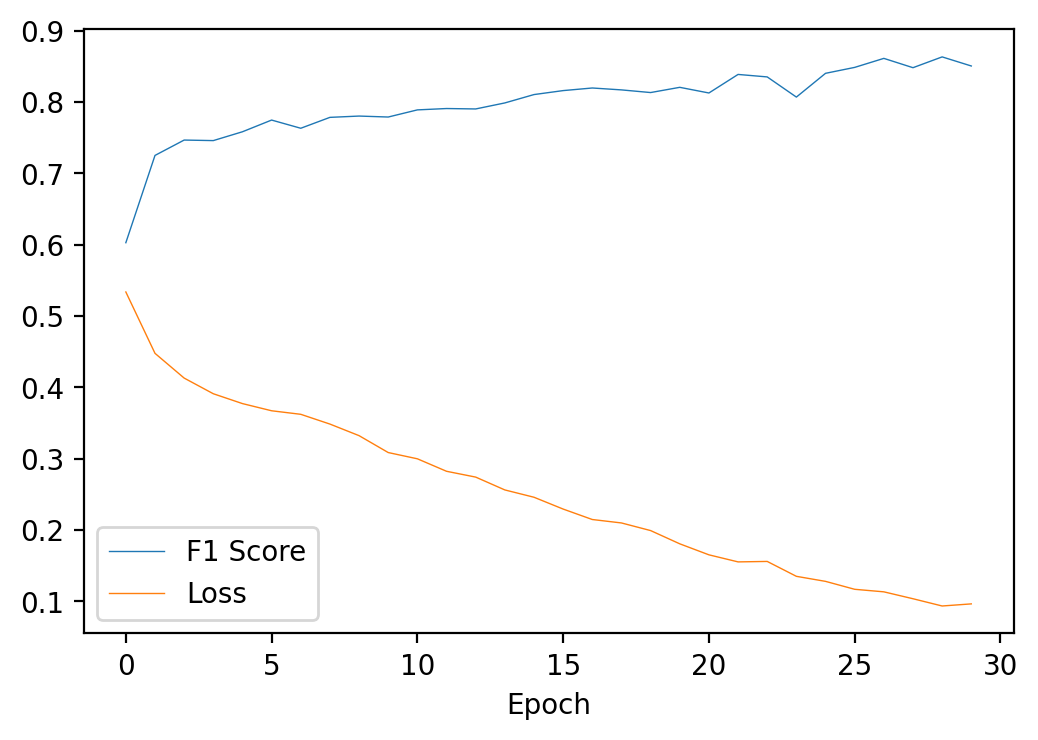

In [19]:
model = Model(300, 200, embeddings, word2i["<PAD>"], 2)

tokenizer = Tokenizer()
batch_size = 8

train_args, train_labels = generate_input(df_train_arguments)
train_input_batches = [b for b in chunk(train_args, batch_size)]
train_label_batches = [b for b in chunk(train_labels, batch_size)]
# Tokenize + encode
train_input_batches = [tokenizer(batch) for batch in train_input_batches]

# Validation dataset
vali_args, vali_labels = generate_input(df_vali_arguments)
vali_input_batches = [b for b in chunk(vali_args, batch_size)]
vali_label_batches = [b for b in chunk(vali_labels, batch_size)]
# Tokenize + encode
vali_input_batches = [tokenizer(batch) for batch in vali_input_batches]

encoded_train_args = [encode_sentences(batch, word2i) for batch in train_input_batches]
encoded_dev_args = [encode_sentences(batch, word2i) for batch in vali_input_batches]
encoded_train_labels = [encode_labels(batch) for batch in train_label_batches]
encoded_dev_labels = [encode_labels(batch) for batch in vali_label_batches]

num_epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

model = training_loop(
    num_epochs,
    encoded_train_args,
    encoded_train_labels,
    encoded_dev_args,
    encoded_dev_labels,
    optimizer,
    model
)

In [18]:
"""
##### TEST 1:
loss: 0.16, F1: 0.82, 30 epochs, 8 batch size, 0.001 LR, 100x65 dim
##### TEST 2:
loss: 0.35, F1: 0.72, 30 epochs, 8 batch size, 0.001 LR, 50x65 dim
##### TEST 3:
loss: 0.05, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 200x120 dim
##### TEST 4:
loss: 0.03, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 300x200 dim

##### TEST 5:
loss: 0.02, F1: 0.85, 30 epochs, 16 batch size, 0.001 LR, 300x200 dim
##### TEST 6:
loss: 0.03, F1: 0.87, 30 epochs, 8 batch size, 0.0005 LR, 300x200 dim
##### TEST 7:
loss: 0.04, F1: 0.83, 30 epochs, 16 batch size, 0.0005 LR, 300x200 dim
##### TEST 8:
loss: 0.03, F1: 0.87, 30 epochs, 32 batch size, 0.001 LR, 300x200 dim
##### TEST 9:
loss: 0.03, F1: 0.85, 30 epochs, 48 batch size, 0.001 LR, 300x200 dim

##### TEST 10:
loss: 0.01, F1: 0.86, 50 epochs, 32 batch size, 0.001 LR, 300x200 dim
"""

'\n##### TEST 1:\nloss: 0.16, F1: 0.82, 30 epochs, 8 batch size, 0.001 LR, 100x65 dim\n##### TEST 2:\nloss: 0.35, F1: 0.72, 30 epochs, 8 batch size, 0.001 LR, 50x65 dim\n##### TEST 3:\nloss: 0.05, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 200x120 dim\n##### TEST 4:\nloss: 0.03, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 300x200 dim\n\n##### TEST 5:\nloss: 0.02, F1: 0.85, 30 epochs, 16 batch size, 0.001 LR, 300x200 dim\n##### TEST 6:\nloss: 0.03, F1: 0.87, 30 epochs, 8 batch size, 0.0005 LR, 300x200 dim\n##### TEST 7:\nloss: 0.04, F1: 0.83, 30 epochs, 16 batch size, 0.0005 LR, 300x200 dim\n##### TEST 8:\nloss: 0.03, F1: 0.87, 30 epochs, 32 batch size, 0.001 LR, 300x200 dim\n##### TEST 9:\nloss: 0.03, F1: 0.85, 30 epochs, 48 batch size, 0.001 LR, 300x200 dim\n\n##### TEST 10:\nloss: 0.01, F1: 0.86, 50 epochs, 32 batch size, 0.001 LR, 300x200 dim\n'